# The Deep Learning Model

In [1]:
# setting up some important path
# My Drive/
# >>>>> Colab Notebooks/
#     >>>>>>> HBV_LSTM_UBNB/
#               >>>>>>>> data/
#               >>>>>>>> models/
#               >>>>>>>> output/

dir_data = '/content/drive/My Drive/Colab Notebooks/HBV_LSTM_UBNB/Data' #where to store data
dir_models = '/content/drive/My Drive/Colab Notebooks/HBV_LSTM_UBNB/models' #where to save trained models
dir_output = '/content/drive/My Drive/Colab Notebooks/HBV_LSTM_UBNB/output' #where to save trained model outputs
dir_heat = '/content/drive/My Drive/Colab Notebooks/HBV_LSTM_UBNB/heat_maps' #where to save heatmaps

In [2]:
# Import some of the libraries I will be using later

from keras.callbacks import ModelCheckpoint
from keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
#%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
## for the plotting
import seaborn as sns
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
#from mpl_toolkits.axes_grid.inset_locator import inset_axes, InsetPosition
import numpy as np
import pandas as pd
#import geopandas as gpd
import seaborn as sns
from scipy import interpolate
from scipy.stats import ks_2samp, pearsonr
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
import pickle
import os
from random import seed
from datetime import datetime, date
from google.colab import drive

#from pyproj import Transformer
#from pyproj import Proj, transform

In [3]:
# Connect to the Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('default')
##### Define some of the important functions I will be using later

###################################
## loading and saving data using pickle
##########################

def save_pickle(data,dir):
    with open(dir_data + '/' + dir, 'wb') as f:
        pickle.dump(data, f)

def load_pickle(dir):
    with open(dir_data + '/' + dir, 'rb') as f:
        return pickle.load(f)
###########################################
# Build the not yet trained Encoder- decoder LSTM model (two layers encoder)
##########################################
def build_encoder_decoder_model_two_layers(learning_rate):
    # Encoder
    encoder_inputs = Input(shape=(365, 3))
    encoder_lstm1 = LSTM(128, return_sequences=True, return_state=True)
    encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)

    encoder_lstm2 = LSTM(128, return_state=True)
    encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_outputs1)
    encoder_states = [state_h2, state_c2]

    # Decoder
    decoder_inputs = Input(shape=(14, 1))  # Dummy input, not used
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(1, activation='linear')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile the model
    model.compile(loss=tf.keras.losses.mse,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model
###########################################
# Build the not yet trained Encoder- decoder LSTM model (one layers encoder)
##########################################
def build_encoder_decoder_model(learning_rate):
    # Encoder
    encoder_inputs = Input(shape=(365, 3))
    encoder_lstm1 = LSTM(128, return_sequences=True, return_state=True)
    encoder_outputs1, state_h1, state_c1 = encoder_lstm1(encoder_inputs)
    encoder_dropout1 = Dropout(0.25)(encoder_outputs1)  # Add dropout layer

    encoder_lstm2 = LSTM(128, return_state=True)
    encoder_outputs2, state_h2, state_c2 = encoder_lstm2(encoder_dropout1)
    #encoder_dropout2 = Dropout(0.5)(encoder_outputs2)  # Add dropout layer
    encoder_states = [state_h2, state_c2]

    # Decoder
    decoder_inputs = Input(shape=(7, 1))  # Dummy input, not used
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    #decoder_dropout = Dropout(0.2)(decoder_outputs)  # Add dropout layer
    decoder_dense = Dense(1, activation='linear')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Compile the model
    model.compile(loss=tf.keras.losses.mse,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

    return model


  #################################
## save and load mode  as .h5 files
###################################
def save_model(model,name):
  model.save("./drive/MyDrive/Colab Notebooks/HBV_LSTM_UBNB/models/{}.h5".format(name))
  print("Saved model to disk")
def load_model(name):
  from keras.models import load_model
  load = load_model('./drive/MyDrive/Colab Notebooks/HBV_LSTM_UBNB/models/{}.h5'.format(name))
  return load

####################################33
###### finding NSE between two time series
########################################

def nse(y_obs, y_model):

  """
  Calculates the Nash-Sutcliffe Efficiency (NSE), evaluated between simulated and observed streamflow.

  Use: NSE = nse(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  nse = 1 - np.sum((y_model - y_obs)**2) / np.sum((y_obs - np.mean(y_obs))**2) #calculate NSE

  return nse
####################################33
###### finding NSE lnQ between two time series
########################################

def nse_lnq(y_obs, y_model):
    """
    Calculates the Nash-Sutcliffe Efficiency (NSE) for log-transformed streamflow,
    evaluated between simulated and observed streamflow.

    Use: NSE_lnq = nse_lnq(y_obs, y_model)

    y_obs, y_model --> these are arrays of the same length (1 x N or N x 1)
    where N is the number of observations in time
    """
    if not isinstance(y_obs, np.ndarray):  # if tensor (or not array), convert to numpy array
        y_obs = np.array(y_obs)
    if not isinstance(y_model, np.ndarray):
        y_model = np.array(y_model)

    y_model = y_model.reshape((-1,1))  # make sure model and obs have same shape
    y_obs = y_obs.reshape((-1,1))

    # Apply log transformation with handling for non-positive values
    epsilon = 1e-6  # small constant to avoid log(0)
    ln_y_obs = np.log(np.maximum(y_obs, epsilon))
    ln_y_model = np.log(np.maximum(y_model, epsilon))

    # Calculate NSE for log-transformed values
    nse_lnq = 1 - np.sum((ln_y_model - ln_y_obs)**2) / np.sum((ln_y_obs - np.mean(ln_y_obs))**2)

    return nse_lnq

import numpy as np

####################################33
###### finding NSE sqrt between two time series
########################################



def nse_sqrt(y_obs, y_model):
    """
    Calculates the Nash-Sutcliffe Efficiency (NSE) for square root-transformed streamflow,
    evaluated between simulated and observed streamflow.

    Use: NSE_sqrt = nse_sqrt(y_obs, y_model)

    y_obs, y_model --> these are arrays of the same length (1 x N or N x 1)
    where N is the number of observations in time
    """
    if not isinstance(y_obs, np.ndarray):  # if tensor (or not array), convert to numpy array
        y_obs = np.array(y_obs)
    if not isinstance(y_model, np.ndarray):
        y_model = np.array(y_model)

    y_model = y_model.reshape((-1,1))  # make sure model and obs have same shape
    y_obs = y_obs.reshape((-1,1))

    # Apply square root transformation with handling for negative values
    sqrt_y_obs = np.sqrt(np.maximum(y_obs, 0))
    sqrt_y_model = np.sqrt(np.maximum(y_model, 0))

    # Calculate NSE for square root-transformed values
    nse_sqrt = 1 - np.sum((sqrt_y_model - sqrt_y_obs)**2) / np.sum((sqrt_y_obs - np.mean(sqrt_y_obs))**2)

    return nse_sqrt

#################################################
# finding R corelation coefficient
########################################
def c_c(y_obs, y_model):
    """
    Calculates the Pearson correlation coefficient, evaluated between observed and modeled data.

    Use: r = correlation_coefficient(y_obs, y_model)

    y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
    """

    if not isinstance(y_obs, np.ndarray): # if tensor (or not array), convert to numpy array
        y_obs = np.array(y_obs)
    if not isinstance(y_model, np.ndarray):
        y_model = np.array(y_model)

    y_model = y_model.reshape((-1,1)) # make sure model and obs have same shape
    y_obs = y_obs.reshape((-1,1))

    # Calculate correlation coefficient
    covariance_matrix = np.cov(y_obs.T, y_model.T)
    covariance = covariance_matrix[0, 1]
    std_y_obs = np.std(y_obs)
    std_y_model = np.std(y_model)

    correlation_coefficient = covariance / (std_y_obs * std_y_model)

    return correlation_coefficient
#################################################
# finding KGE
#################################
def kge(y_obs, y_model):
  """
  Calculates the Kling-Gupta Efficiency (KGE), evaluated between simulated and observed streamflow.

  Use: KGE = kge(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
    y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
    y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  #calculate mean of observations and simulations
  y_obs_mean = np.mean(y_obs)
  y_model_mean = np.mean(y_model)

  #calculate standard deviation of observations and simulations
  y_obs_std = np.std(y_obs)
  y_model_std = np.std(y_model)

  #calculate correlation coefficient between observations and simulations
  r = np.corrcoef(y_obs.flatten(), y_model.flatten())[0,1]

  #calculate alpha (measure of flow variability error)
  alpha = y_model_std / y_obs_std

  #calculate beta (measure of flow bias)
  beta = y_model_mean / y_obs_mean

  #calculate KGE
  kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

  return kge
######################################
### PBIAS
##############
def pbias(y_obs, y_model):
  """
  Calculates the Percent Bias (PBIAS), evaluated between simulated and observed streamflow.

  Use: PBIAS = pbias(y_obs, y_model)

  y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
  """

  if not isinstance(y_obs, np.ndarray): #if tensor (or not array), convert to numpy array
      y_obs = np.array(y_obs)
  if not isinstance(y_model, np.ndarray):
      y_model = np.array(y_model)

  y_model = y_model.reshape((-1,1)) #make sure model and obs have same shape
  y_obs = y_obs.reshape((-1,1))

  pbias = 100 * np.sum(y_model - y_obs) / np.sum(y_obs) #calculate PBIAS

  return pbias

######################################
### MSE
##############
def mse(y_obs, y_model):
    """
    Calculates the Mean Squared Error (MSE) between simulated and observed values.

    Use: MSE = mse(y_obs, y_model)

    y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
    """
    if not isinstance(y_obs, np.ndarray):  # if not numpy array, convert to numpy array
        y_obs = np.array(y_obs)
    if not isinstance(y_model, np.ndarray):
        y_model = np.array(y_model)

    y_model = y_model.reshape((-1, 1))  # ensure model and obs have the same shape
    y_obs = y_obs.reshape((-1, 1))

    mse = np.mean((y_model - y_obs) ** 2)  # calculate MSE
    return mse
######################################
### PBIAS
##############

def rmse(y_obs, y_model):
    """
    Calculates the Root Mean Squared Error (RMSE) between simulated and observed values.

    Use: RMSE = rmse(y_obs, y_model)

    y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time
    """
    return np.sqrt(mse(y_obs, y_model))  # RMSE is the square root of MSE
import numpy as np

######################################
### R2
##############
def r2(y_obs, y_model):
    """
    Calculates the Coefficient of Determination, \( R^2 \), between observed and modeled values.

    Use: R2 = r2(y_obs, y_model)

    y_obs, y_model --> these are arrays of the same length (1 x N or N x 1) where N is the number of observations in time.

    The function returns the \( R^2 \) value, which indicates the proportion of variance in the dependent variable that is predictable from the independent variable(s).
    """
    if not isinstance(y_obs, np.ndarray):  # Convert input to numpy array if not already
        y_obs = np.array(y_obs)
    if not isinstance(y_model, np.ndarray):
        y_model = np.array(y_model)

    y_model = y_model.reshape((-1, 1))  # Ensure both model and obs have the same shape
    y_obs = y_obs.reshape((-1, 1))

    # Calculate \( R^2 \)
    ss_res = np.sum((y_obs - y_model) ** 2)  # Sum of squares of residuals
    ss_tot = np.sum((y_obs - np.mean(y_obs)) ** 2)  # Total sum of squares
    r2_value = 1 - (ss_res / ss_tot)  # \( R^2 \) formula

    return r2_value

## Loading the data

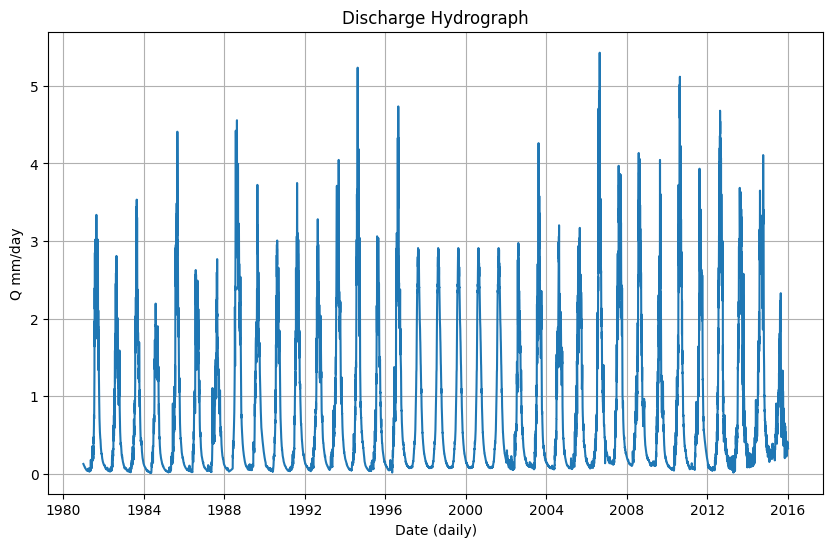

In [5]:
# reading the data from the drive and visualize them

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(dir_data + '/Data.xlsx')
# Assuming the DataFrame has columns named 'Date' and 'Discharge'
# Plot the discharge hydrograph
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Q mm'])
plt.xlabel('Date (daily)')
plt.ylabel('Q mm/day')
plt.title('Discharge Hydrograph')
plt.grid(True)
plt.show()


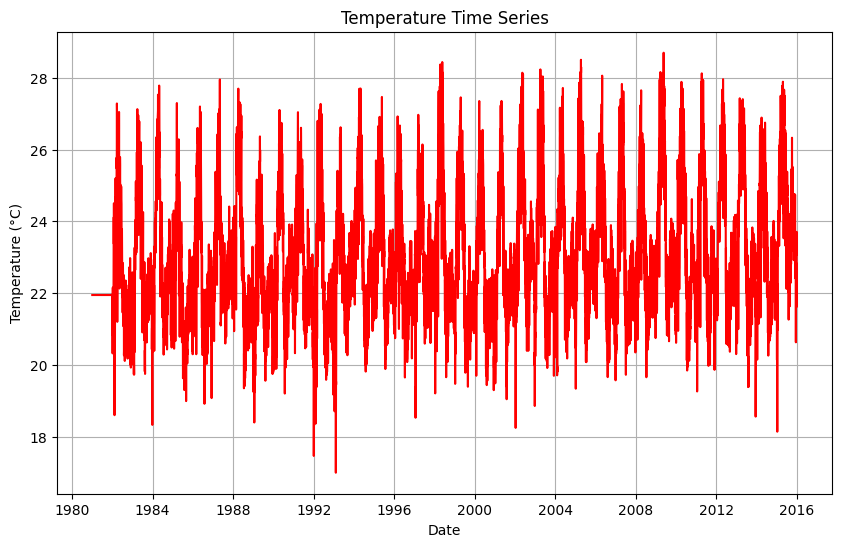

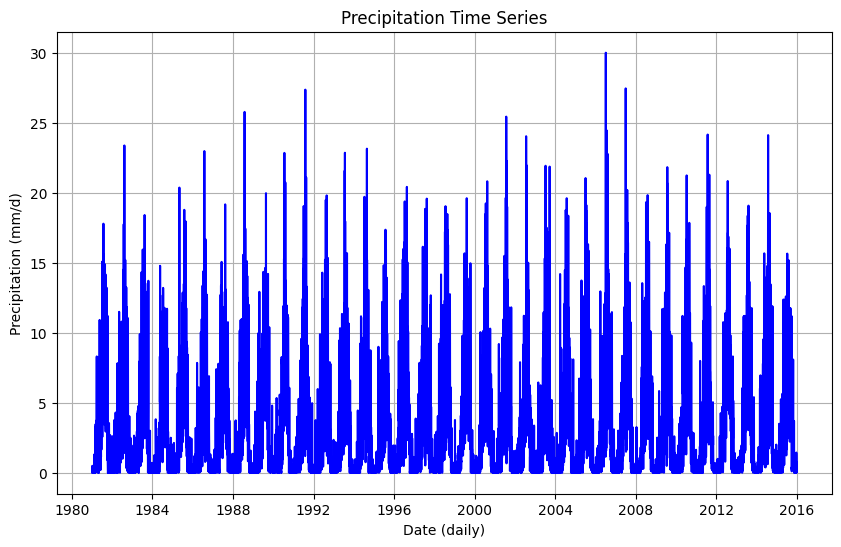

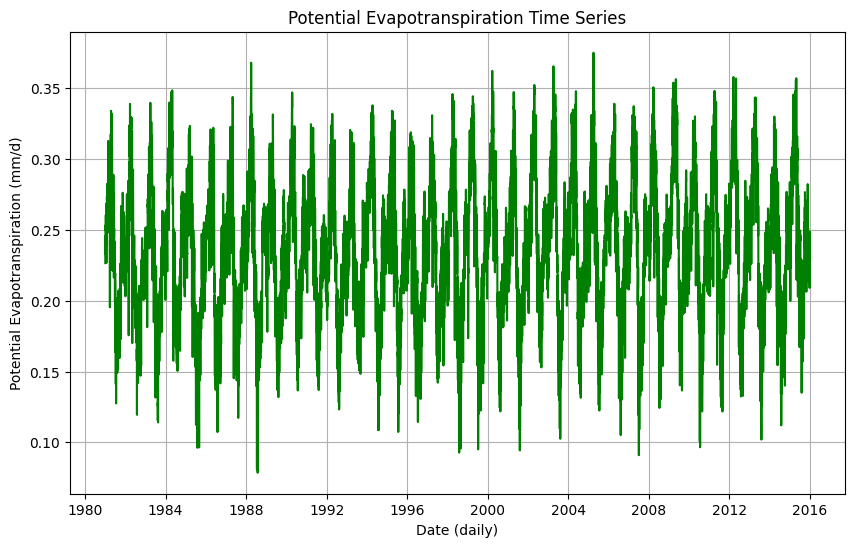

In [6]:
# ploting the tempratuer precipitation and Epot

# Plot the temperature time series
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['temp C'], color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Time Series')
plt.grid(True)
plt.show()

# Plot the precipitation time series
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['p mm'], color='blue')
plt.xlabel('Date (daily)')
plt.ylabel('Precipitation (mm/d)')
plt.title('Precipitation Time Series')
plt.grid(True)
plt.show()

# Plot the potential evapotranspiration time series
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Epot mm'], color= 'green')
plt.xlabel('Date (daily)')
plt.ylabel('Potential Evapotranspiration (mm/d)')
plt.title('Potential Evapotranspiration Time Series')
plt.grid(True)
plt.show()


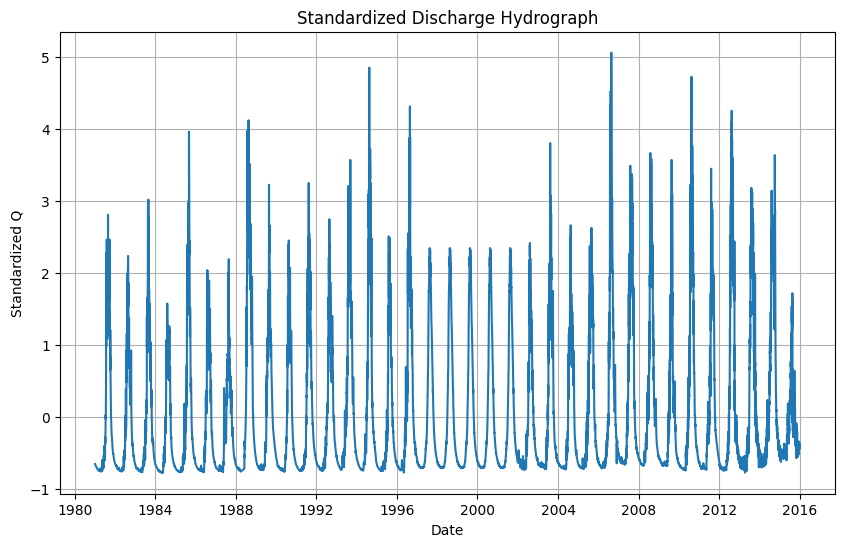

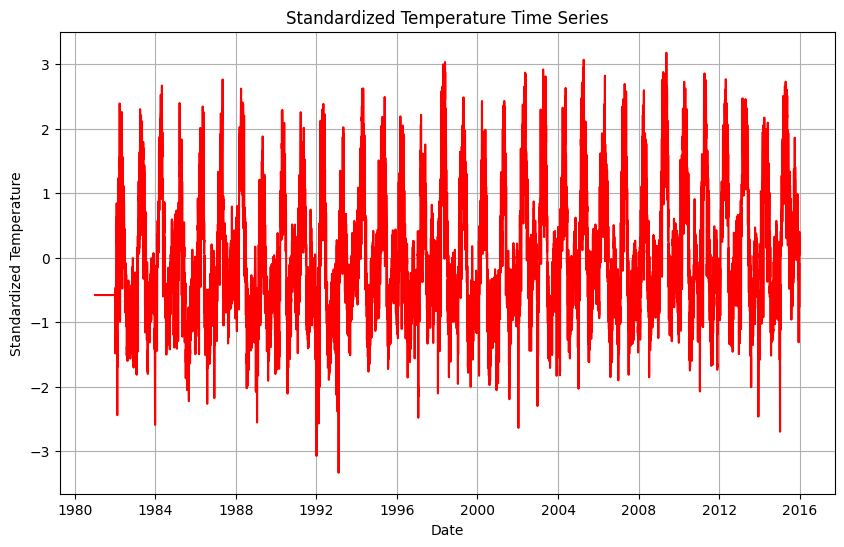

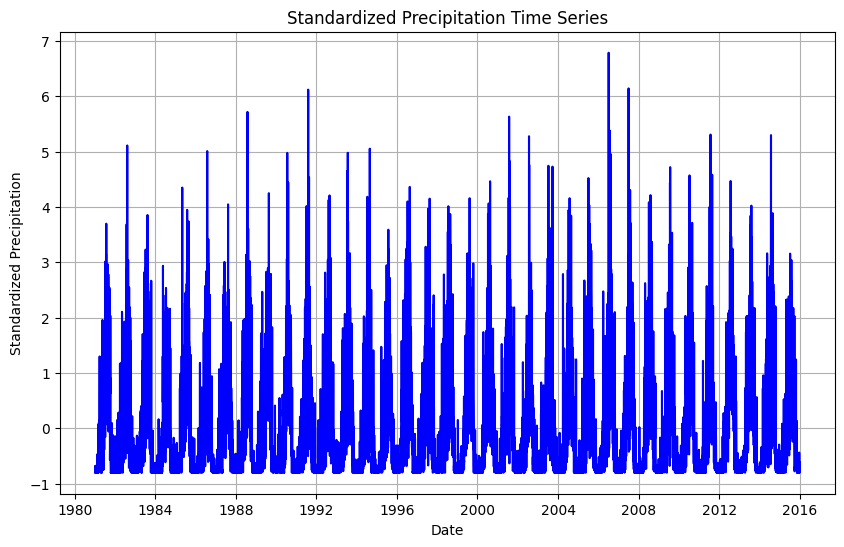

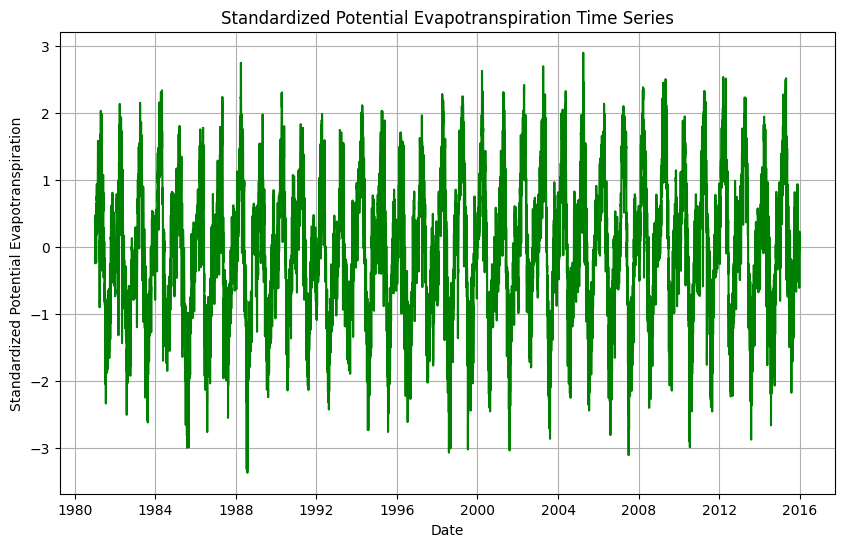

In [7]:
# Standardize the data by substracting the mean and dividing by the std
# prompt: can you standardized all the data by substracting the mean and dividing by the standard diviation
### standardization is used to make the optimization easier while training the model, it is a standard practice
# Standardize the data

df_std = df.copy()
for column in ['Q mm', 'temp C', 'p mm', 'Epot mm']:
  df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
  #print("/"+coulmn +'/mean:'+ str(df_std[column].mean())+"/std:"+ str(df_std[column].std()))

# Plot the standardized discharge hydrograph
plt.figure(figsize=(10, 6))
plt.plot(df_std['Date'], df_std['Q mm'])
plt.xlabel('Date')
plt.ylabel('Standardized Q')
plt.title('Standardized Discharge Hydrograph')
plt.grid(True)
plt.show()


# Plot the standardized temperature time series
plt.figure(figsize=(10, 6))
plt.plot(df_std['Date'], df_std['temp C'],color='red')
plt.xlabel('Date')
plt.ylabel('Standardized Temperature')
plt.title('Standardized Temperature Time Series')
plt.grid(True)
plt.show()

# Plot the standardized precipitation time series
plt.figure(figsize=(10, 6))
plt.plot(df_std['Date'], df_std['p mm'], color='blue')
plt.xlabel('Date')
plt.ylabel('Standardized Precipitation')
plt.title('Standardized Precipitation Time Series')
plt.grid(True)
plt.show()

# Plot the standardized potential evapotranspiration time series
plt.figure(figsize=(10, 6))
plt.plot(df_std['Date'], df_std['Epot mm'], color='green')
plt.xlabel('Date')
plt.ylabel('Standardized Potential Evapotranspiration')
plt.title('Standardized Potential Evapotranspiration Time Series')
plt.grid(True)
plt.show()


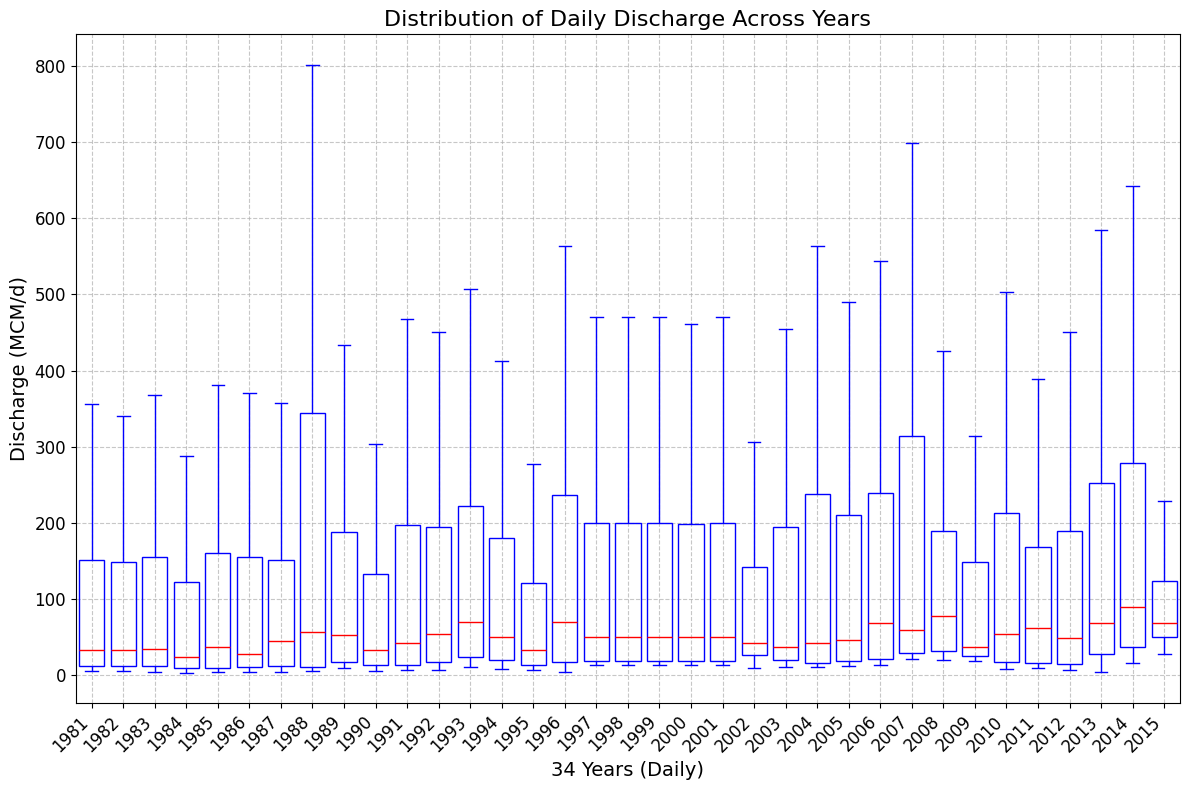

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming the discharge data is in cubic meters per second (cms) and needs to be converted to cubic meters per day (cmd)
conversion_factor = (176000*10**6/(1000*10**6))  # convert to MCM/d
df['Q cmd'] = df['Q mm'] * conversion_factor

# Extract year from the 'Date' column
df['Year'] = df['Date'].dt.year

# Create a box plot for daily discharge in each year
plt.figure(figsize=(12, 8))
sns.boxplot(x='Year', y='Q cmd', data=df, showfliers=False,
            boxprops=dict(facecolor='none', edgecolor='blue'),
            medianprops=dict(color='red'), whiskerprops=dict(color='blue'), capprops=dict(color='blue'))
plt.xlabel('34 Years (Daily)', fontsize=14)
plt.ylabel('Discharge (MCM/d)', fontsize=14)
plt.title('Distribution of Daily Discharge Across Years', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Preparign the examples (input:(365,3), output:(14,1))

In [9]:
# prompt: # Leave room for 365 input days and 7 output days:::: instead of this use the 1 365 day of 1981 to preidct for the 7 days of  1982 an so on, stop  at teh day n-7

# Assuming 'df' is your DataFrame with columns 'Date', 'Q mm', 'temp C', 'p mm', 'Epot mm'

# Extract the time series data
dates = df_std['Date'].values
discharge = df_std['Q mm'].values
temperature = df_std['temp C'].values
precipitation = df_std['p mm'].values
pet = df_std['Epot mm'].values
lt=14
# Create input-output pairs with 365 input days and 7 output days
input_data = []
output_data = []
for i in range(len(dates) - 365 - lt + 1):
    input_seq = np.stack([ precipitation[i:i+365], temperature[i:i+365],pet[i:i+365],], axis=-1)  # Stack discharge, temp, and precip
    output_seq = discharge[i+365:i+365+lt]
    input_data.append(input_seq)
    output_data.append(output_seq)

# Convert lists to numpy arrays
input_data = np.array(input_data)
output_data = np.array(output_data)

print("Input data shape:", input_data.shape)
print("Output data shape:", output_data.shape)


Input data shape: (12405, 365, 3)
Output data shape: (12405, 14)


## split into training and validation and testing
training: 1980-2000

validation: 2001:2005

testing:2006-2015


In [10]:
# prompt: I would like to split the data  input data and out put data)into training validation and testing, between 1982-2000 for training from 2001-2005 for validation from 2006- the end for testing get the nuber of days in those period and divide teh data accordingly. I would like to have x_train,  y_train, x_val ,y_val, x_test, y_test

# Calculate indices for splitting
start_train = (datetime(1982, 1, 1) - datetime(1982, 1, 1)).days
end_train = (datetime(2001, 1, 1) - datetime(1982, 1, 1)).days
start_val = (datetime(2001, 1, 1) - datetime(1982, 1, 1)).days
end_val = (datetime(2006, 1, 1) - datetime(1982, 1, 1)).days

# Split the data
x_train = input_data[start_train:end_train]
y_train = output_data[start_train:end_train]
x_val = input_data[start_val:end_val]
y_val = output_data[start_val:end_val]
x_test = input_data[end_val:]
y_test = output_data[end_val:]

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (6940, 365, 3)
y_train shape: (6940, 14)
x_val shape: (1826, 365, 3)
y_val shape: (1826, 14)
x_test shape: (3639, 365, 3)
y_test shape: (3639, 14)


## building and training 10 ensembles of the model


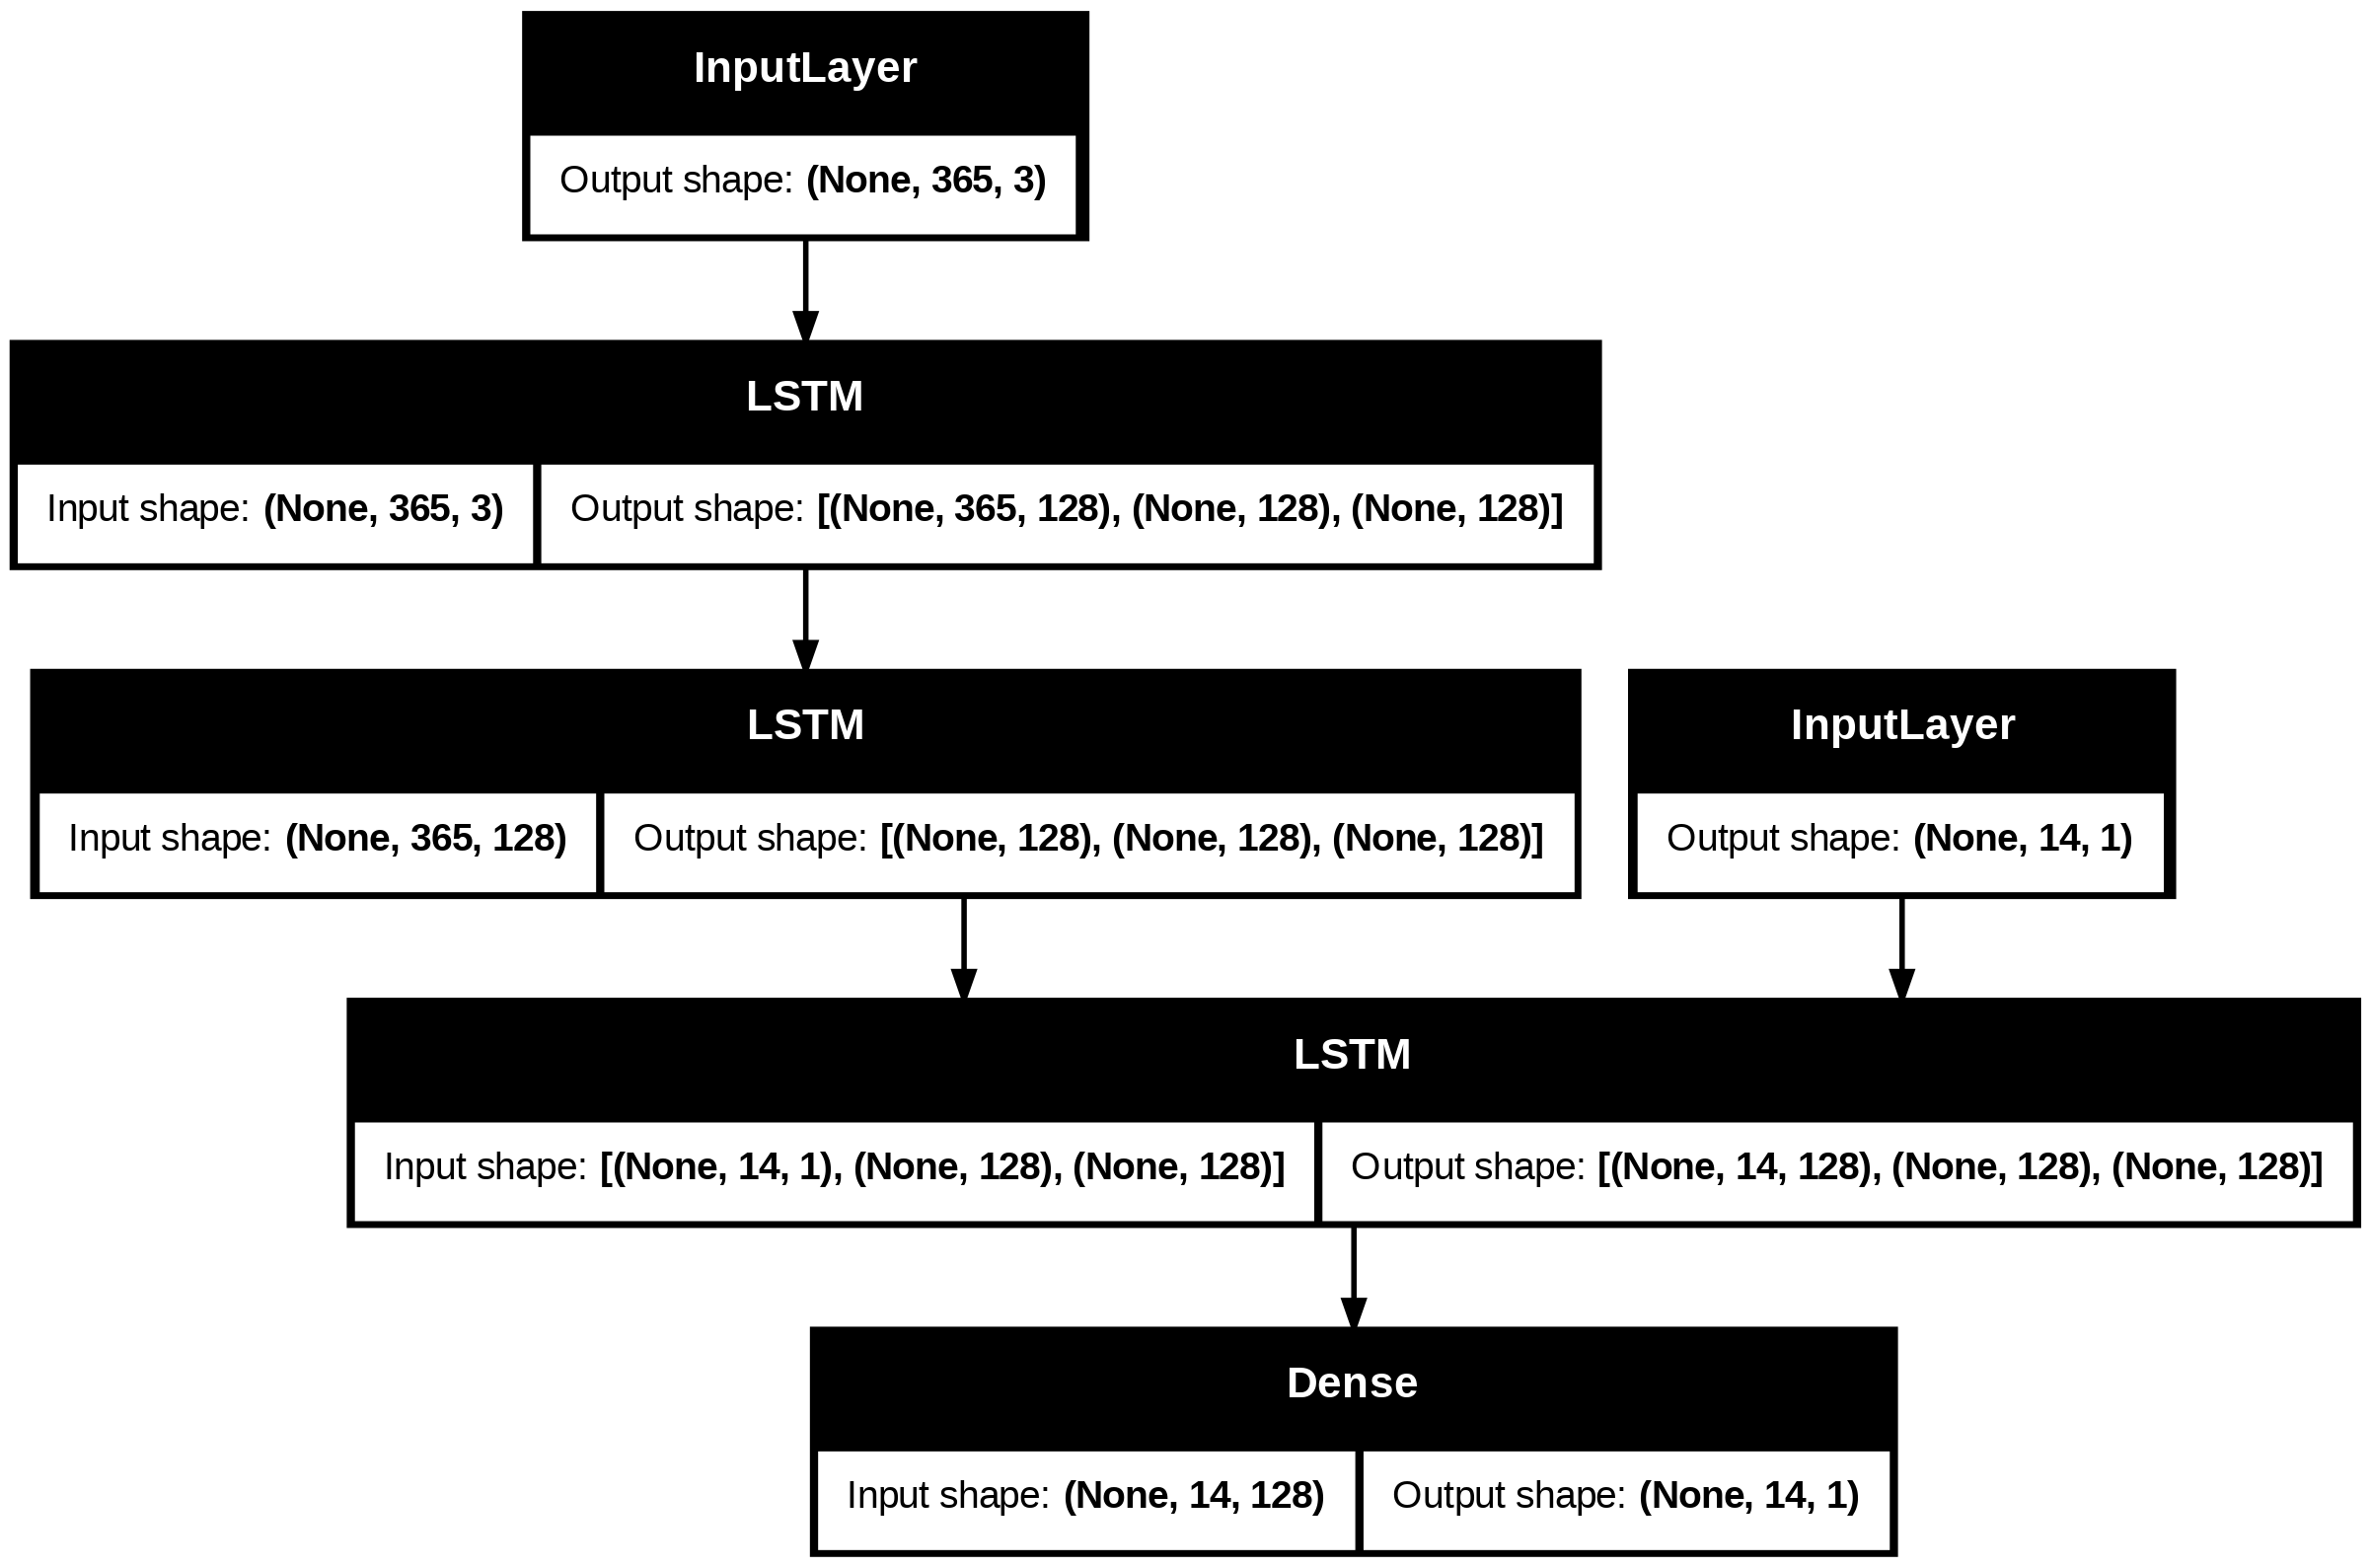

In [ ]:
# build the model and visualize it
model = build_encoder_decoder_model_two_layers(learning_rate=0.001)
tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 365, 3)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 365, 128),     │         67,584 │ input_layer[0][0]      │
│                           │ (None, 128), (None,    │                │                        │
│                           │ 128)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 14, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 128), (None,   │        131,584 │ lstm[0][0]             │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 14, 128),      │         66,560 │ input_layer_1[0][0],   │
│                           │ (None, 128), (None,    │                │ lstm_1[0][1],          │
│                           │ 128)]                  │                │ lstm_1[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 14, 1)          │            129 │ lstm_2[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 265,857 (1.01 MB)

 Trainable params: 265,857 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training 10 ensembles of the model to account for uncerienty in parameters initialization
# cross validation set is used to monitor the training and prevent overfitting
# prompt:  I want to train 10 modes with 10 different random seeds to make the repuducability possibe, save all the models in the dir models, and make predictions with each of the model during training testing and validation and save them as CSV file in dir results::: save the models in dir_models

# Train 10 models with different random seeds
num_models = 10
for i in range(num_models):
    seed(i)  # Set random seed for reproducibility
    tf.random.set_seed(i)
    print('training model {}'.format(i))
    # Build the model
    model = build_encoder_decoder_model_two_layers(learning_rate=0.001)

    # Dummy input for the decoder
    decoder_input_data = np.zeros((x_train.shape[0], 14, 1))

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit([x_train, decoder_input_data], y_train,
                        epochs=20, batch_size=32,
                        validation_data=([x_val, np.zeros((x_val.shape[0], 14, 1))], y_val),
                        callbacks=[early_stopping])

    # Save the model
    model_name = f"model_{i}"
    save_model(model, model_name)
    print('making predictions for model {} ...'.format(i))
    # Make predictions
    y_train_pred = model.predict([x_train, np.zeros((x_train.shape[0], 14, 1))])
    y_val_pred = model.predict([x_val, np.zeros((x_val.shape[0], 14, 1))])
    y_test_pred = model.predict([x_test, np.zeros((x_test.shape[0], 14, 1))])
    print('saving predictions for model {} ....'.format(i))
    # Reshape predictions for saving as CSV
    y_train_pred_reshaped = y_train_pred.reshape(y_train_pred.shape[0], -1)
    y_val_pred_reshaped = y_val_pred.reshape(y_val_pred.shape[0], -1)
    y_test_pred_reshaped = y_test_pred.reshape(y_test_pred.shape[0], -1)
    # save the predictions
    pd.DataFrame(y_train_pred_reshaped).to_csv(dir_output + f"/y_train_pred_{model_name}.csv", index=False)
    pd.DataFrame(y_val_pred_reshaped).to_csv(dir_output + f"/y_val_pred_{model_name}.csv", index=False)
    pd.DataFrame(y_test_pred_reshaped).to_csv(dir_output + f"/y_test_pred_{model_name}.csv", index=False)

training model 0
Epoch 1/20
217/217 [==============================] - 13s 40ms/step - loss: 0.1397 - val_loss: 0.0766
Epoch 2/20
217/217 [==============================] - 6s 30ms/step - loss: 0.0961 - val_loss: 0.1038
Epoch 3/20
217/217 [==============================] - 8s 35ms/step - loss: 0.0896 - val_loss: 0.0749
Epoch 4/20
217/217 [==============================] - 6s 29ms/step - loss: 0.0781 - val_loss: 0.0953
Epoch 5/20
217/217 [==============================] - 8s 35ms/step - loss: 0.0704 - val_loss: 0.0906
Epoch 6/20
217/217 [==============================] - 6s 29ms/step - loss: 0.0571 - val_loss: 0.0887
Epoch 7/20
217/217 [==============================] - 8s 35ms/step - loss: 0.0467 - val_loss: 0.0832
Epoch 8/20
217/217 [==============================] - 6s 29ms/step - loss: 0.0363 - val_loss: 0.1103


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk
making predictions for model 0 ...
114/114 [==============================] - 1s 11ms/step
saving predictions for model 0 ....
training model 1
Epoch 1/20
217/217 [==============================] - 13s 37ms/step - loss: 0.1354 - val_loss: 0.0623
Epoch 2/20
217/217 [==============================] - 7s 32ms/step - loss: 0.0940 - val_loss: 0.1053
Epoch 3/20
217/217 [==============================] - 7s 32ms/step - loss: 0.0885 - val_loss: 0.0926
Epoch 4/20
217/217 [==============================] - 7s 30ms/step - loss: 0.0820 - val_loss: 0.0798
Epoch 5/20
217/217 [==============================] - 7s 32ms/step - loss: 0.0654 - val_loss: 0.1037
Epoch 6/20
217/217 [==============================] - 7s 30ms/step - loss: 0.0539 - val_loss: 0.1219
Saved model to disk
making predictions for model 1 ...
114/114 [==============================] - 2s 16ms/step
saving predictions for model 1 ....
training model 2
Epoch 1/20
217/217 [==============================] - 19s 53ms/st

## Exploring the results

In [11]:
# prompt: I would like to get the results of all the 10 models and report them as ensimbles for each lead times plot the average at each time steps and also the +-std

import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get a list of all prediction files for each lead time
lead_times = range(1, 15)  # 1 to 7 days ahead
all_predictions = {lead_time: [] for lead_time in lead_times}
num_models=10
for model_num in range(num_models):
    model_name = f"model_{model_num}"
    for lead_time in lead_times:
        # Load predictions for this lead time and model
        file_path = dir_output + f"/y_test_pred_{model_name}.csv"
        df_results_lstm = pd.read_csv(file_path)
        all_predictions[lead_time].append(df_results_lstm.iloc[:, lead_time - 1].values)  # Extract the column for this lead time

# Calculate ensemble mean and standard deviation for each lead time
ensemble_means = {}
ensemble_stds = {}
for lead_time in lead_times:
    predictions_for_lead_time = np.array(all_predictions[lead_time])
    ensemble_means[lead_time] = np.mean(predictions_for_lead_time, axis=0)
    ensemble_stds[lead_time] = np.std(predictions_for_lead_time, axis=0)




In [12]:
# prompt: (y_pred_lead1 * df['Q mm'].std() + df['Q mm'].mean())* (176000*10**6/(1000*10**6)) I want to apply this to all the predictions destandardization and converting to million cubic meters by multiplying bby teh area. doit and keep the same names:::: not just for the mean but for all predictions as well

# Destandardize and convert all predictions to million cubic meters
for lead_time in lead_times:
    for i in range(len(all_predictions[lead_time])):
        all_predictions[lead_time][i] = (all_predictions[lead_time][i] * df['Q mm'].std() + df['Q mm'].mean()) * (176000*10**6/(1000*10**6))

# Recalculate ensemble means and standard deviations with destandardized values
ensemble_means = {}
ensemble_stds = {}
for lead_time in lead_times:
    predictions_for_lead_time = np.array(all_predictions[lead_time])
    ensemble_means[lead_time] = np.mean(predictions_for_lead_time, axis=0)
    ensemble_stds[lead_time] = np.std(predictions_for_lead_time, axis=0)

# Destandardize the test data for comparison
y_test_destd = (y_test * df['Q mm'].std() + df['Q mm'].mean()) * (176000*10**6/(1000*10**6))


In [ ]:
y_test_destd.shape

(3639, 14)

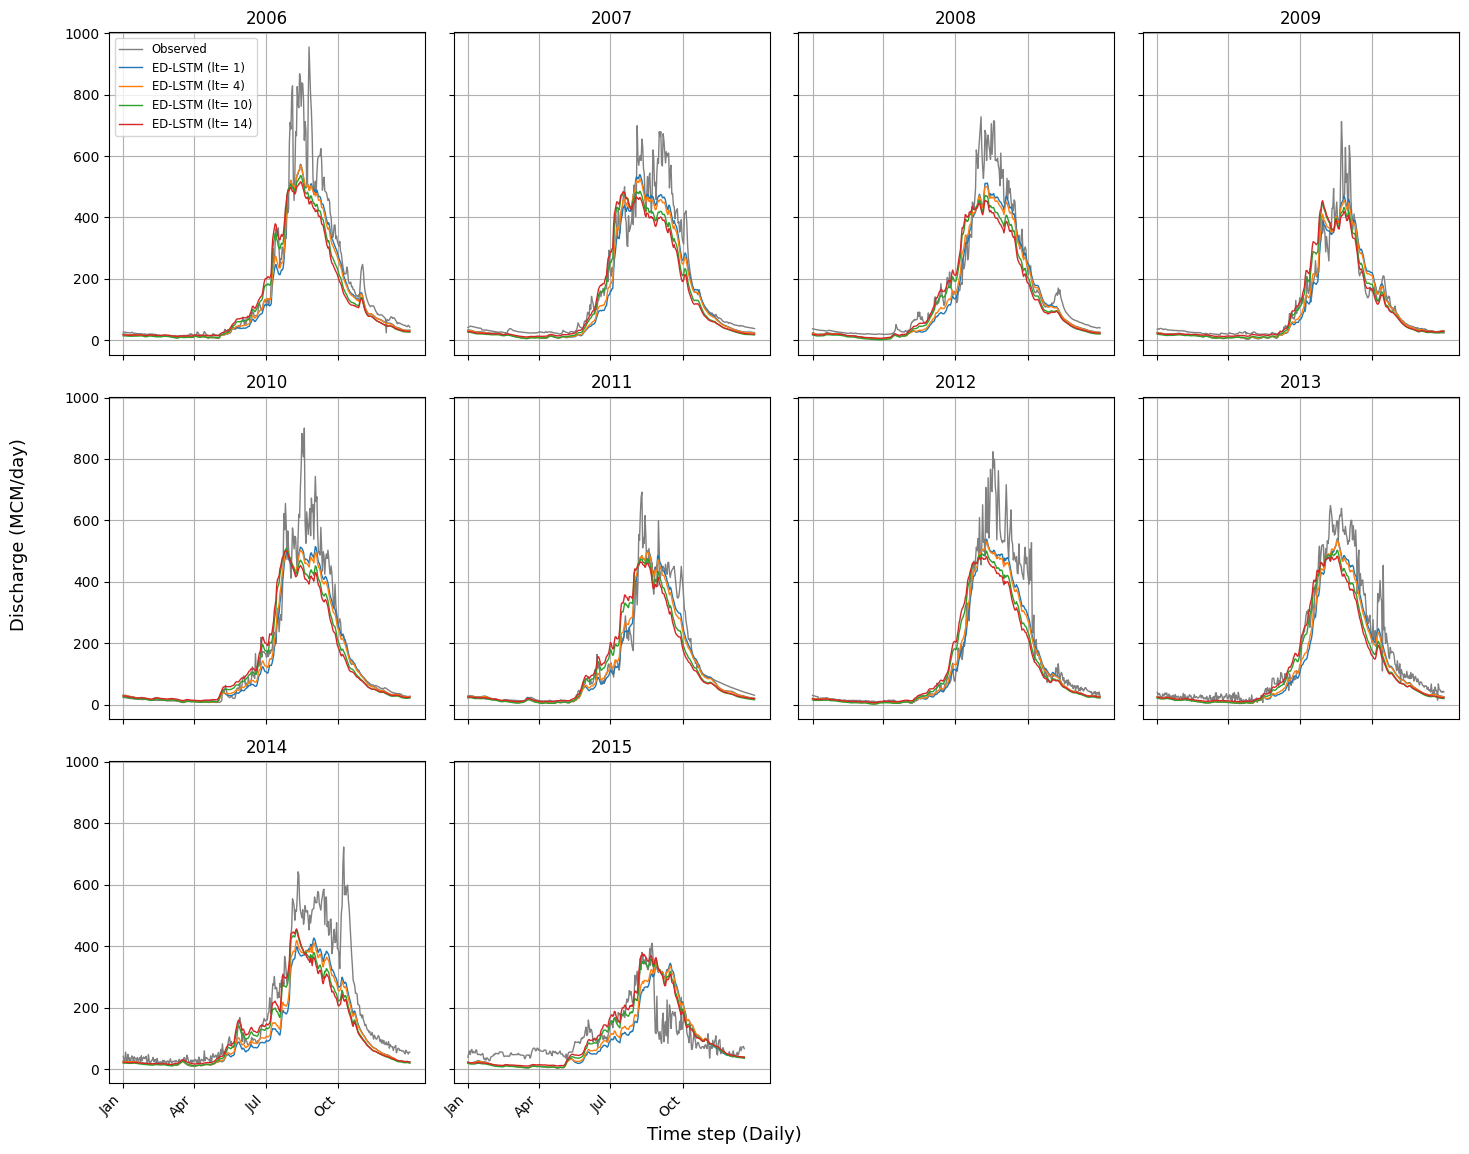

In [13]:
import matplotlib.pyplot as plt
from datetime import datetime

# Assuming y_test_destd and ensemble_means are defined and populated
years_to_plot = range(2006, 2016)  # Years in the test set
lead_times_to_plot = [1, 4, 10, 14]

# Create a figure with 12 subplots (3 rows and 4 columns)
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Plot observed and predicted data for each year
for i, year in enumerate(years_to_plot):
    start_index = (datetime(year, 1, 1) - datetime(2006, 1, 1)).days
    end_index = (datetime(year + 1, 1, 1) - datetime(2006, 1, 1)).days

    ax = axes[i]
    ax.plot(y_test_destd[start_index:end_index, 0], label='Observed', color='gray', linewidth=1)

    for lead_time in lead_times_to_plot:
        ax.plot(ensemble_means[lead_time][start_index:end_index], label=f'ED-LSTM (lt= {lead_time})', lw=1)

    ax.set_title(f'{year}')
    ax.grid(True)

    if i >= 6:  # Set X-axis labels on the bottom row
        # Approximate start days of each quarter (3 months)
        month_starts = [0, 90, 181, 273]  # Approximate start days of Jan, Apr, Jul, Oct
        month_labels = ['Jan', 'Apr', 'Jul', 'Oct']
        ax.set_xticks(month_starts)
        ax.set_xticklabels(month_labels, rotation=45, ha="right")

# Hide the last two subplots (bottom right)
for j in range(len(years_to_plot), len(axes)):
    axes[j].axis('off')

# Add a single Y-axis label for the entire figure
fig.text(0.03, 0.5, 'Discharge (MCM/day)', va='center', ha='center', rotation='vertical', fontsize=13)
fig.text(0.5, 0, 'Time step (Daily)', va='center', ha='center', fontsize=13)

# Add the legend to the first subplot in the upper left corner
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='upper left', fontsize='small')

plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.show()


### hydrographs

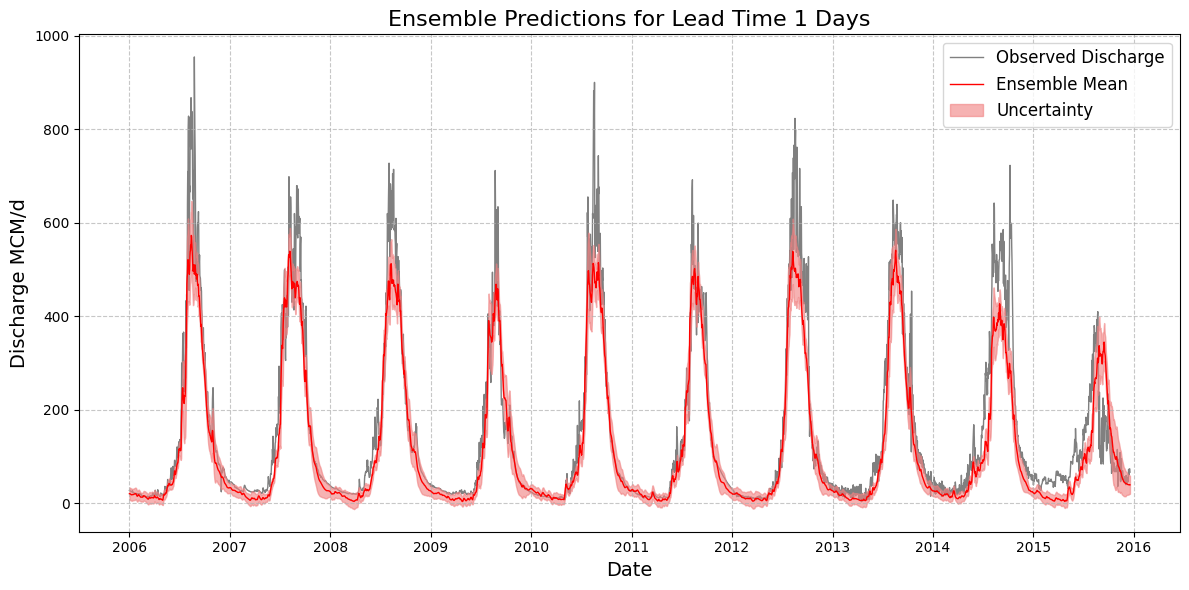

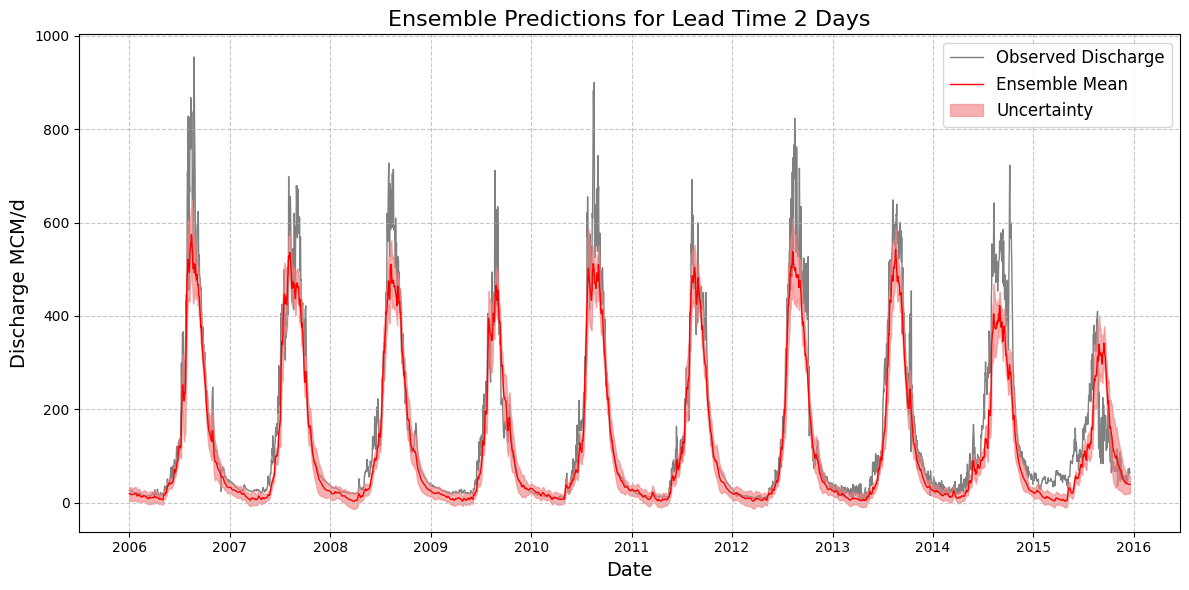

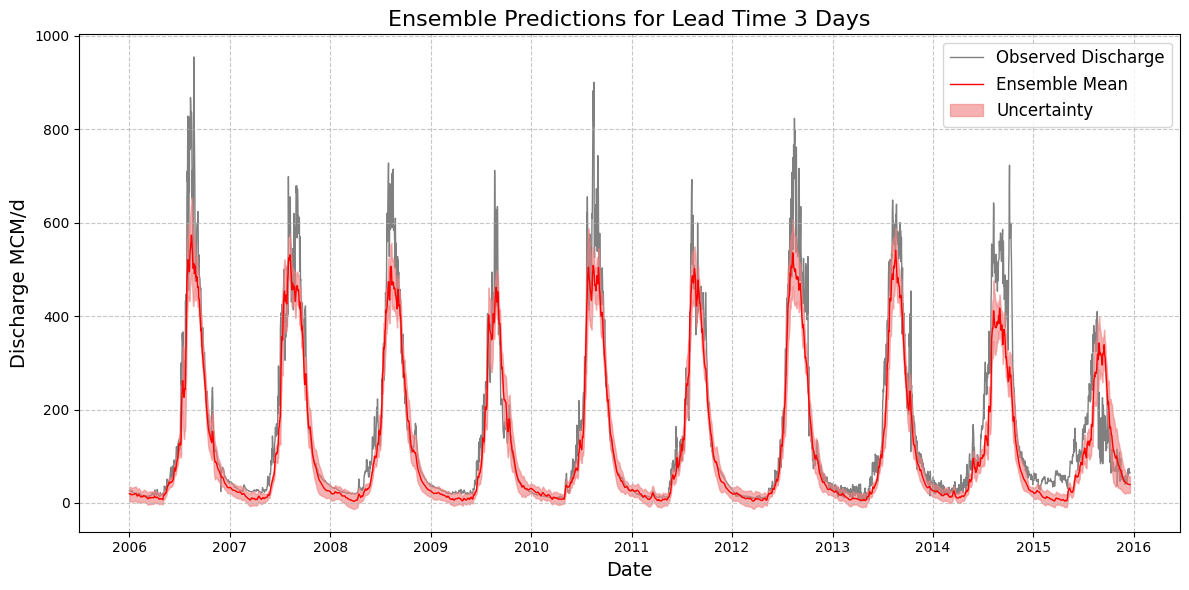

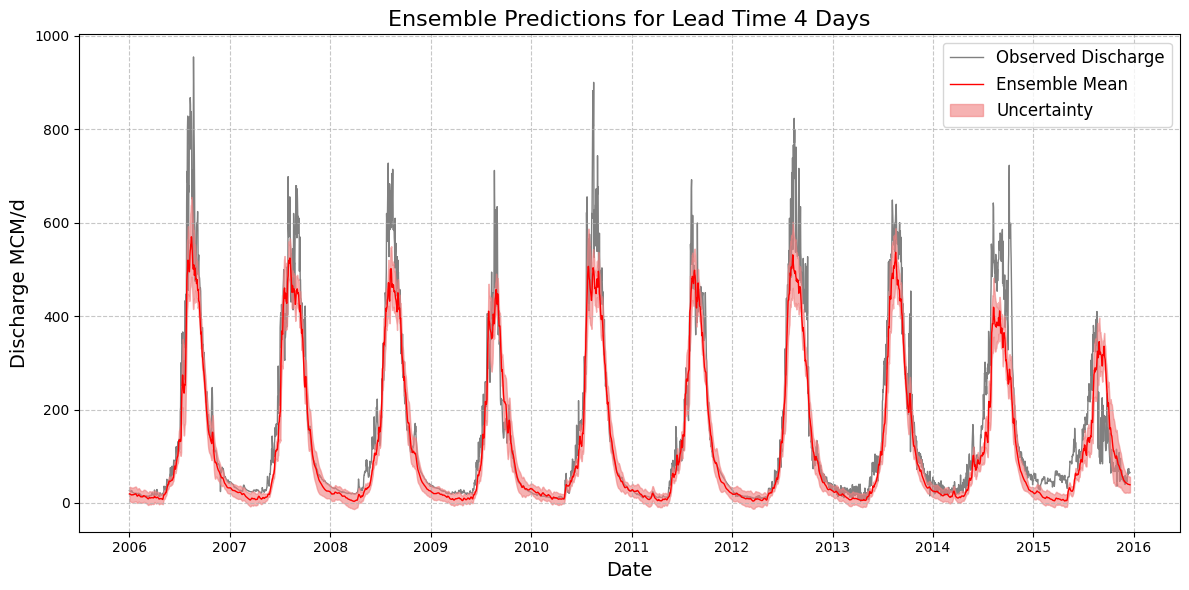

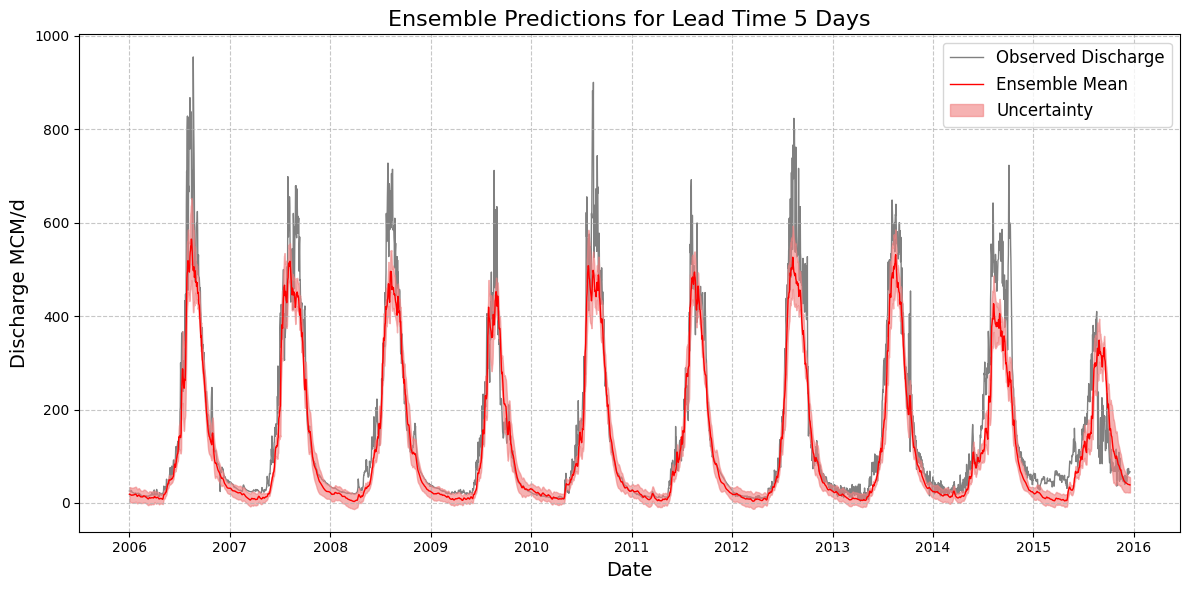

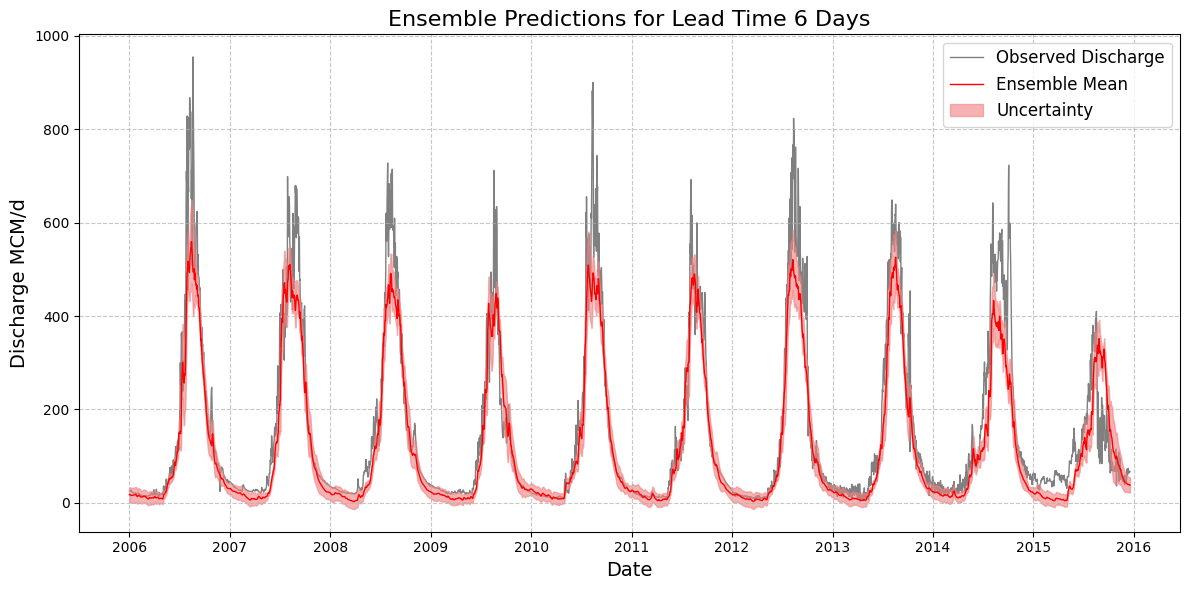

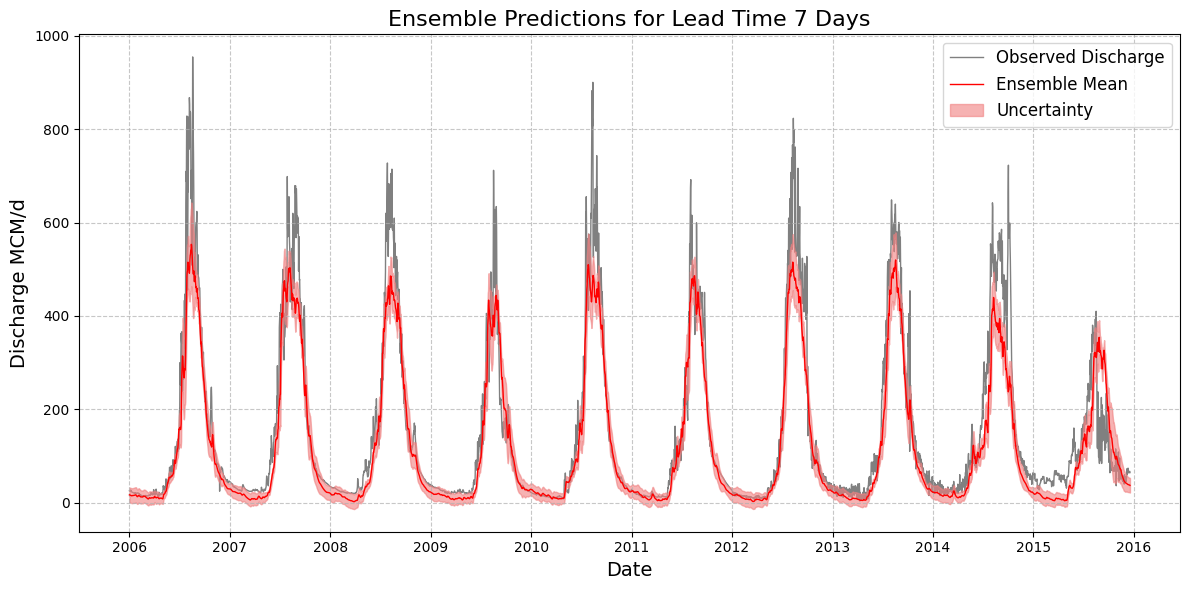

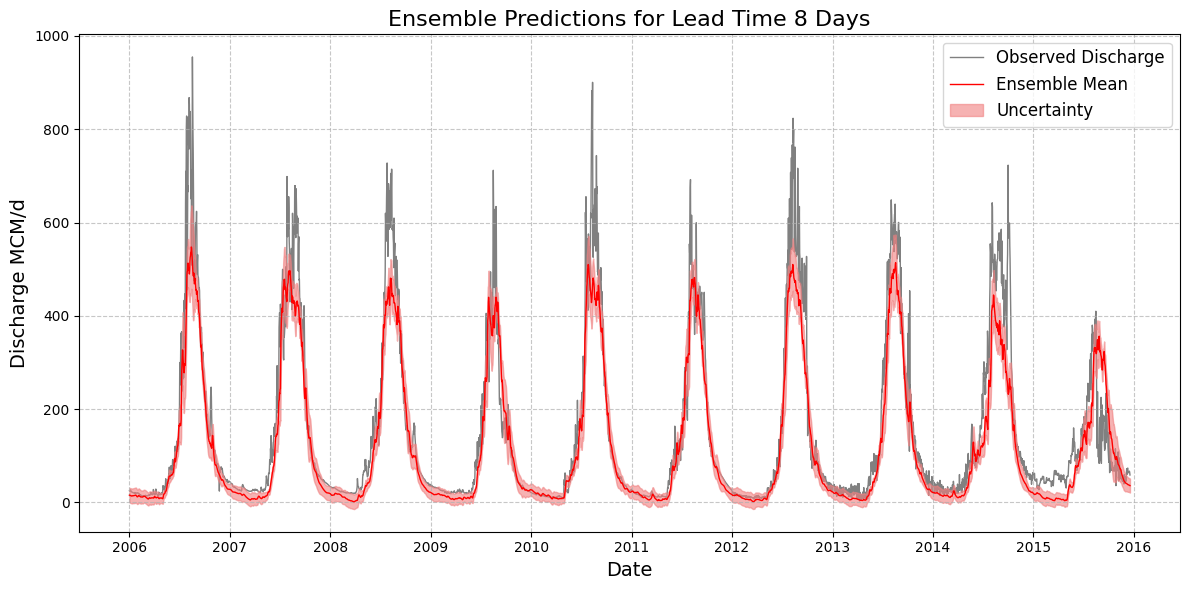

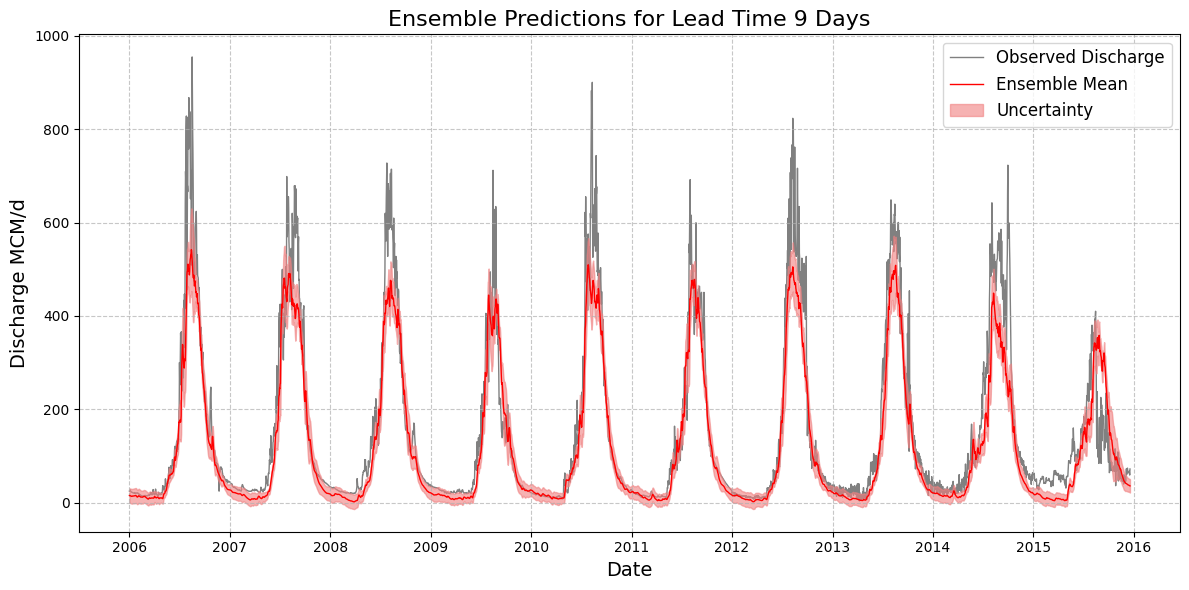

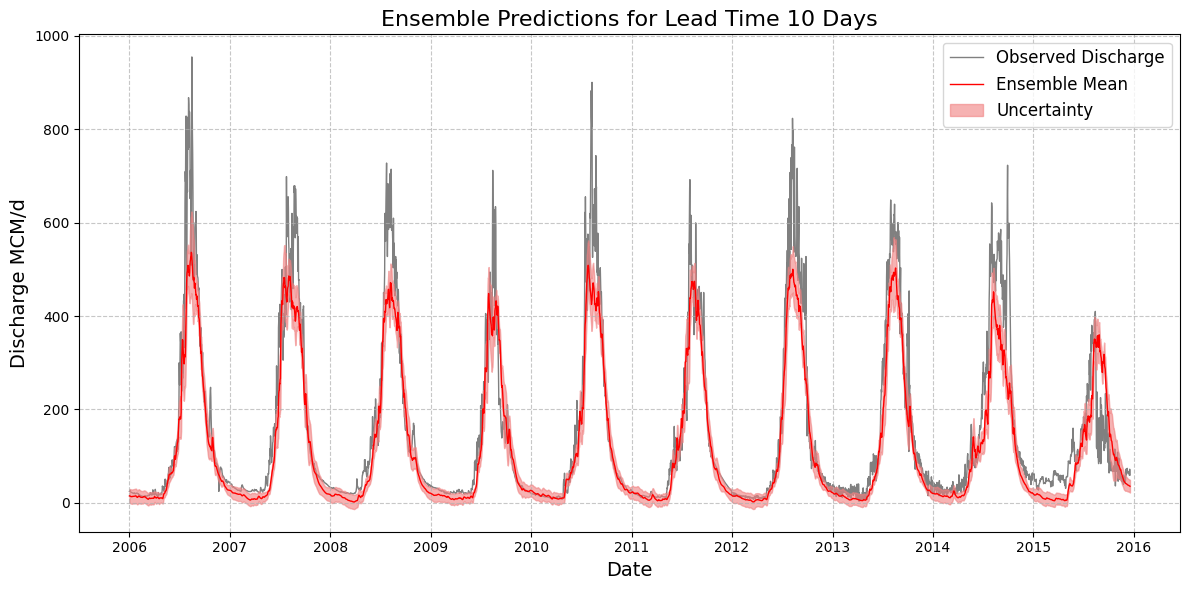

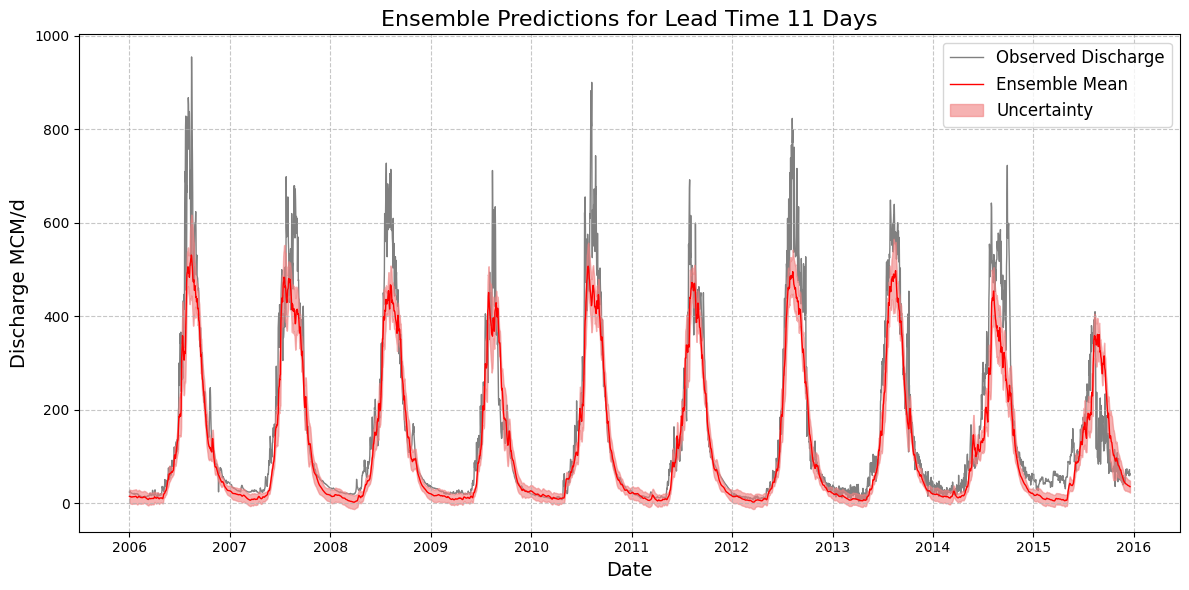

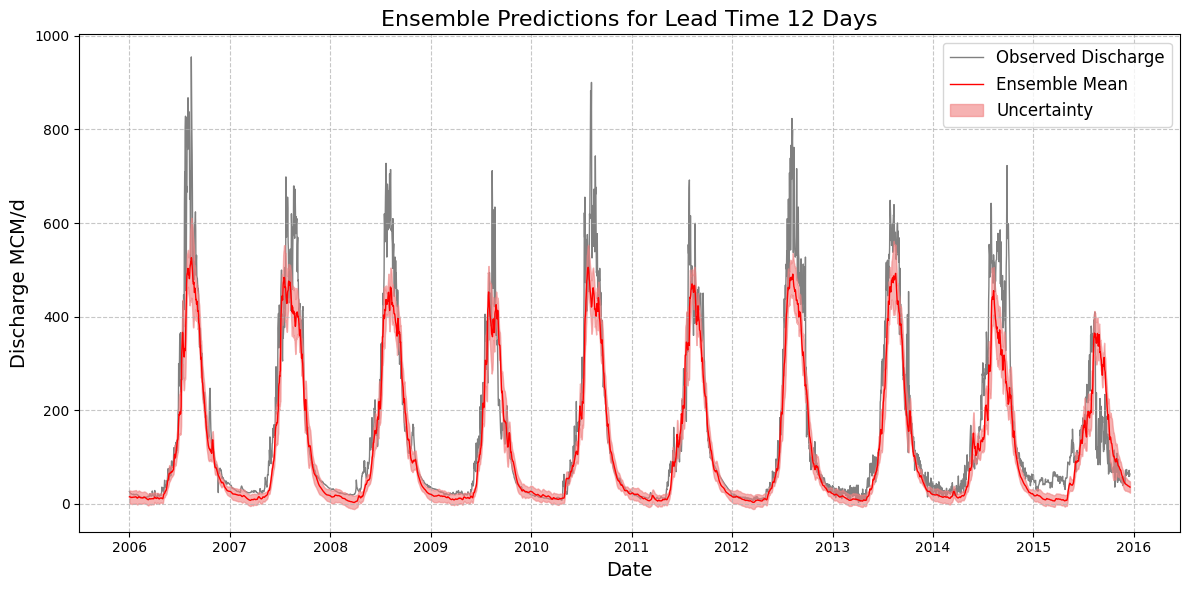

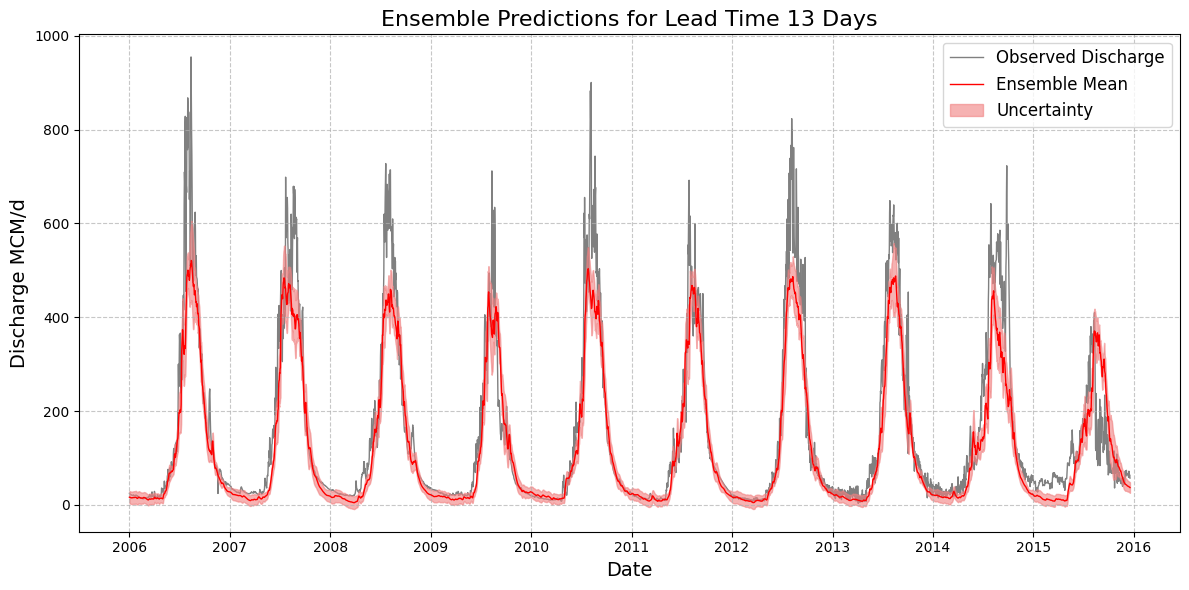

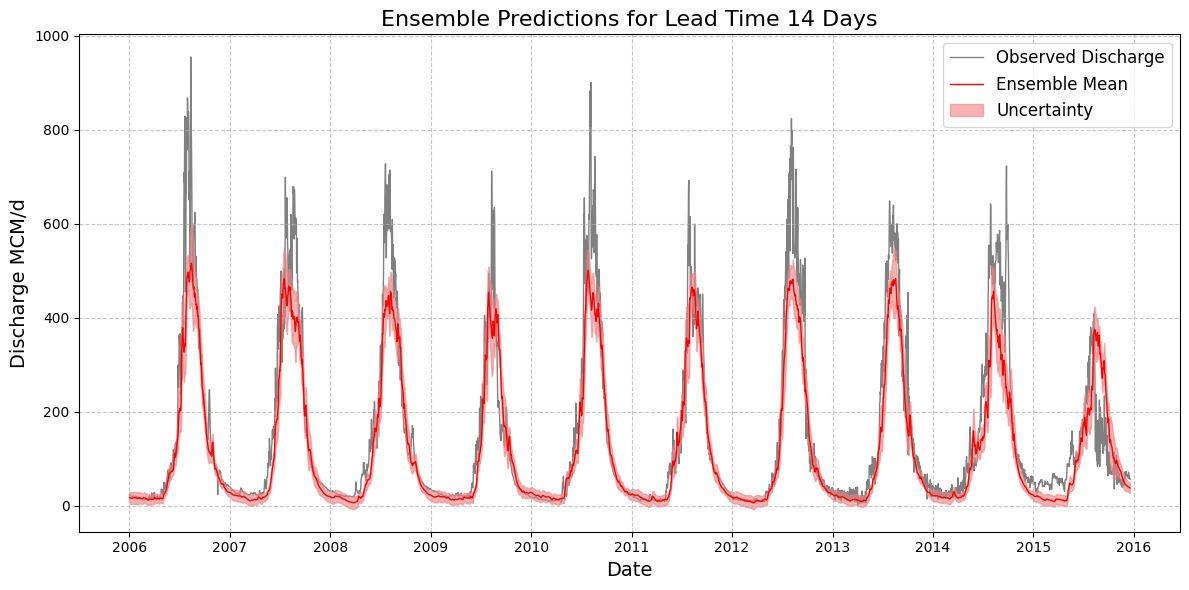

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have 3650 days (10 years of daily data from 2006 to 2015)
dates = pd.date_range(start='2006-01-01', end='2015-12-31', freq='D')

# Ensure you have your ensemble_means, ensemble_stds already calculated
# Example datasets (replace with actual data):
# lead_times = [1, 2, 3, 4, 5, 6, 7]
# y_test_destd is your actual observed data aligned with these dates

for lead_time in lead_times:
    plt.figure(figsize=(12, 6))

    # Making sure each plot uses the correct part of the date range
    # Adjust this if your dataset doesn't cover all dates for each lead time
    valid_dates = dates[:len(ensemble_means[lead_time])]  # This clips the date range to match the available data length for each lead time

    # Plot observed discharge
    plt.plot(valid_dates, y_test_destd[:, lead_time - 1], label="Observed Discharge", color='gray', linewidth=1, zorder=1)

    # Plot ensemble mean
    plt.plot(valid_dates, ensemble_means[lead_time], label="Ensemble Mean", color='red', linewidth=1)

    # Plot 95% prediction interval
    plt.fill_between(valid_dates,
                     ensemble_means[lead_time] - 2 * ensemble_stds[lead_time],
                     ensemble_means[lead_time] + 2 * ensemble_stds[lead_time],
                     color='lightcoral', alpha=0.6, label="Uncertainty")

    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Discharge MCM/d", fontsize=14)
    plt.title(f"Ensemble Predictions for Lead Time {lead_time} Days", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


### correlation plots

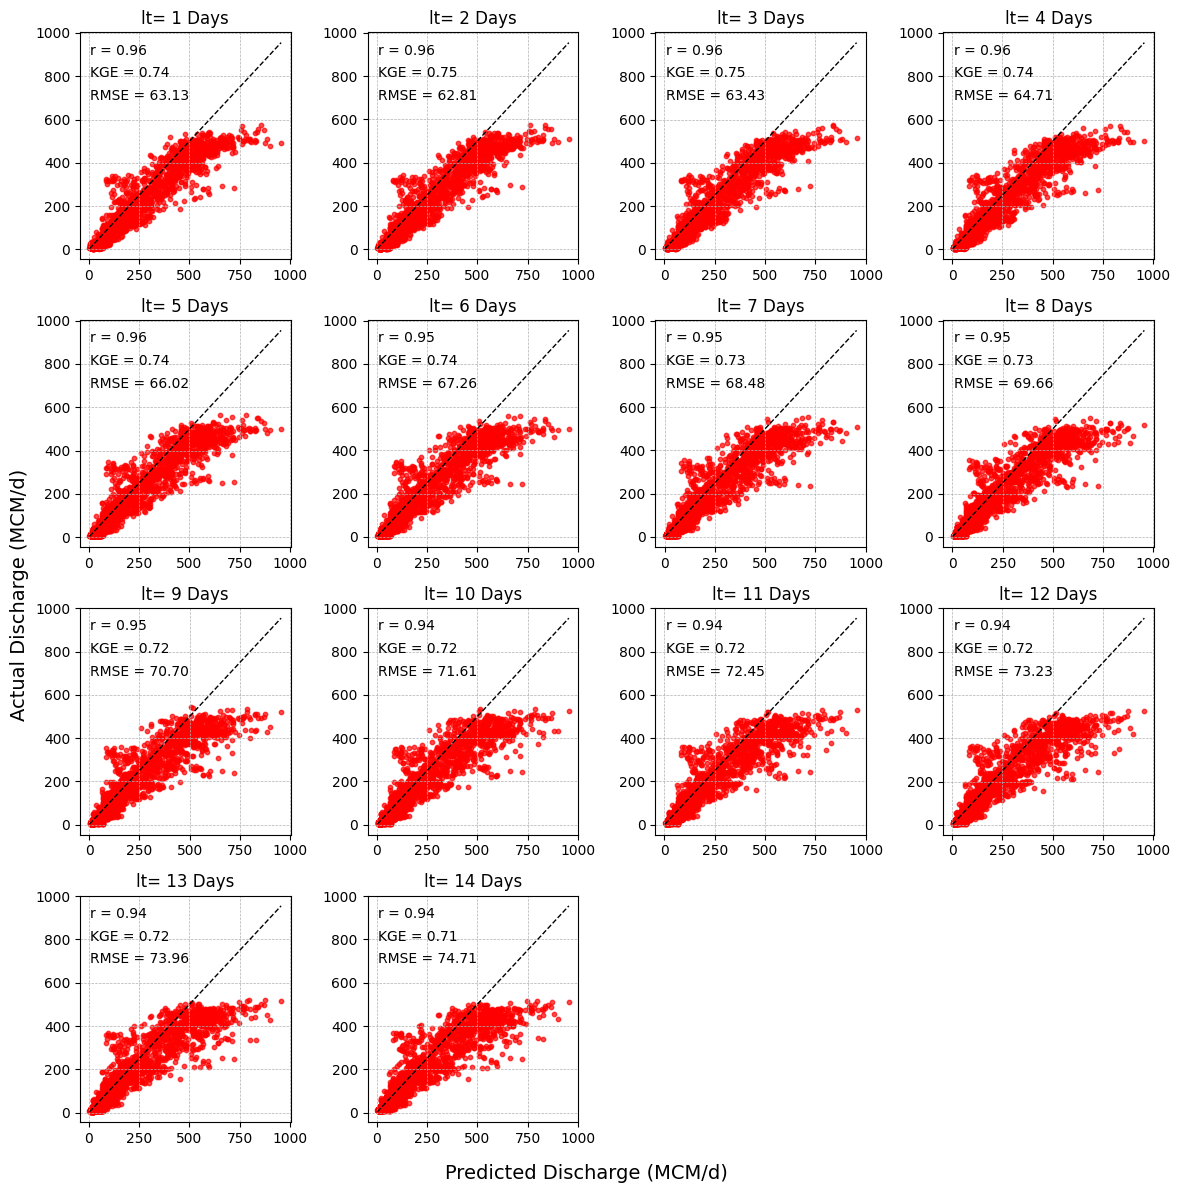

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the ensemble means and y_test from the previous code

# Plot NSE plots for each lead time
lead_times = range(1, 15)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))  # Adjust to 5 rows, 3 columns for 14 plots
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, lead_time in enumerate(lead_times):
    ax = axes[i]

    # Scatter plot of actual vs. predicted values
    ax.scatter(y_test_destd[:, lead_time - 1], ensemble_means[lead_time], s=10, alpha=0.7, color='red')

    # Calculate and display NSE score
    NSE = nse(y_test_destd[:, lead_time - 1], ensemble_means[lead_time])
    KGE = kge(y_test_destd[:, lead_time - 1], ensemble_means[lead_time])
    R2 = r2(y_test_destd[:, lead_time - 1], ensemble_means[lead_time])
    R = c_c(y_test_destd[:, lead_time - 1], ensemble_means[lead_time])
    RMSE = rmse(y_test_destd[:, lead_time - 1], ensemble_means[lead_time])
    ax.text(0.05, 0.95, f"r = {R:.2f}", transform=ax.transAxes, fontsize=10, va='top')
    ax.text(0.05, 0.85, f"KGE = {KGE:.2f}", transform=ax.transAxes, fontsize=10, va='top')
    ax.text(0.05, 0.75, f"RMSE = {RMSE:.2f}", transform=ax.transAxes, fontsize=10, va='top')
    # Diagonal line for reference
    min_value = min(np.min(y_test_destd[:, lead_time - 1]), np.min(ensemble_means[lead_time]))
    max_value = max(np.max(y_test_destd[:, lead_time - 1]), np.max(ensemble_means[lead_time]))
    ax.plot([min_value, max_value], [min_value, max_value], 'k--', lw=1)

   # ax.set_xlabel('Predicted Discharge' if i // 3 == 4 else '')  # Only set x-labels for the bottom row
    #ax.set_ylabel('Actual Discharge' if i % 3 == 0 else '')  # Only set y-labels for the first column
    ax.set_title(f"lt= {lead_time} Days", fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Set overall labels for the figure
fig.supxlabel('Predicted Discharge (MCM/d)', fontsize=14)
fig.supylabel('Actual Discharge (MCM/d)', fontsize=14)

plt.tight_layout()
plt.show()


### different metrics vs lead time plot

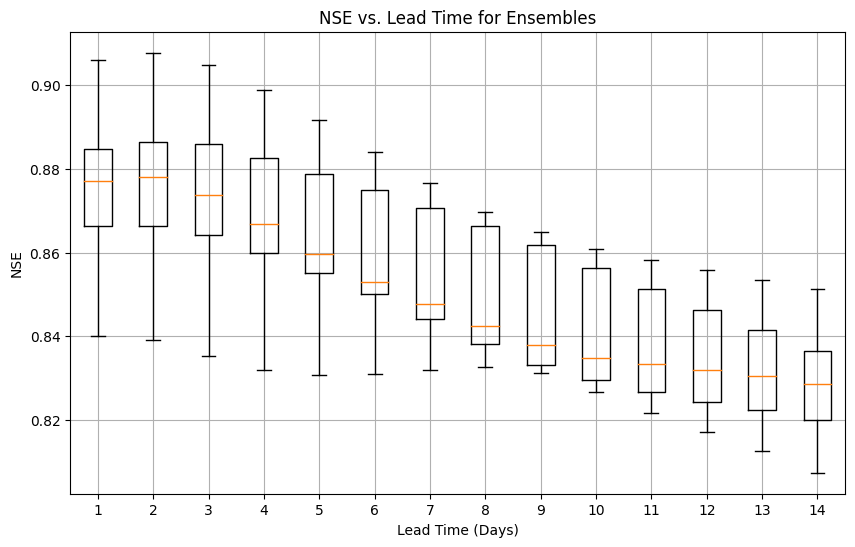

In [ ]:
# prompt: plot the NSE vs lead time for as box block for the ensimbles for each lead time do it for all the lead times

# Calculate NSE for each model and lead time
nse_values_lstm = []
for lead_time in lead_times:
    lead_time_nse = []
    for i in range(num_models):
        y_pred_lead = all_predictions[lead_time][i]
        nse_lead = nse(y_test_destd[:, lead_time - 1], y_pred_lead)
        lead_time_nse.append(nse_lead)
    nse_values_lstm.append(lead_time_nse)

# Create box plot for NSE vs. lead time
plt.figure(figsize=(10, 6))
plt.boxplot(nse_values_lstm, labels=lead_times)
plt.xlabel('Lead Time (Days)')
plt.ylabel('NSE')
plt.title('NSE vs. Lead Time for Ensembles')
plt.grid(True)
plt.show()


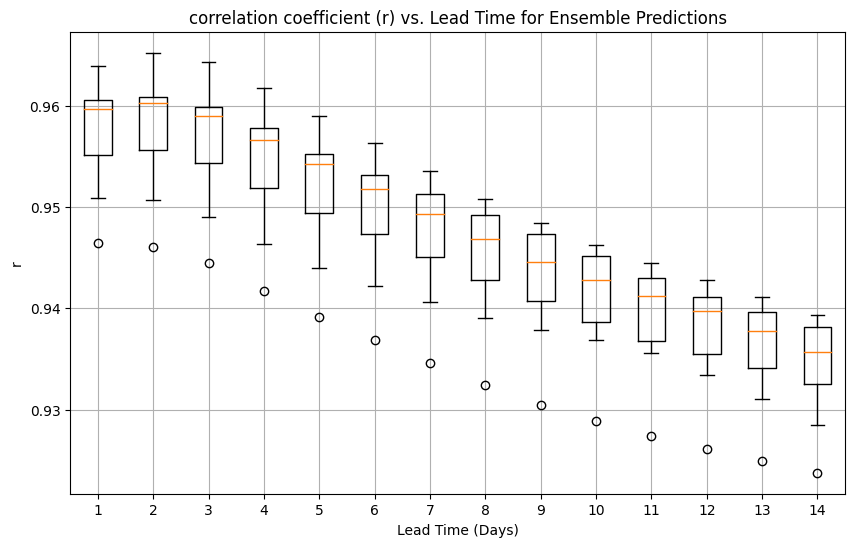

In [ ]:
# prompt: plot the R2 vs lead time for as box block for the ensimbles for each lead time

from sklearn.metrics import r2_score

# Calculate R2 for each model and lead time
r2_values_lstm = {lead_time: [] for lead_time in lead_times}
for lead_time in lead_times:
    for model_predictions in all_predictions[lead_time]:
        r2_values_lstm[lead_time].append(c_c(y_test_destd[:, lead_time - 1], model_predictions))

# Create box plot for R2 vs. lead time
plt.figure(figsize=(10, 6))
plt.boxplot([r2_values_lstm[lead_time] for lead_time in lead_times], labels=[f"{i}" for i in lead_times])
plt.xlabel("Lead Time (Days)")
plt.ylabel("r")
plt.title("correlation coefficient (r) vs. Lead Time for Ensemble Predictions")
plt.grid(True)
plt.show()



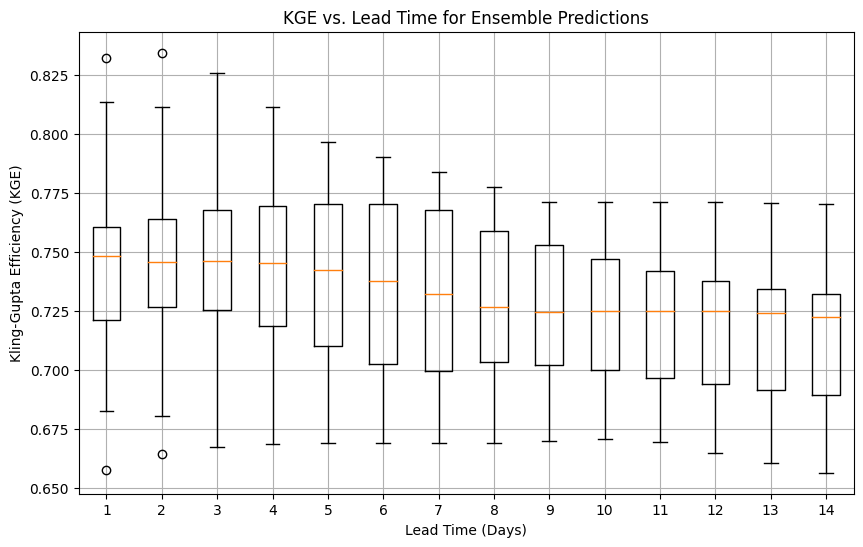

In [ ]:
# prompt: plot the KGE vs lead time for as box block for the ensimbles for each lead time, do not use hydroeval

from sklearn.metrics import mean_squared_error



# Calculate KGE for each model and lead time
kge_values_lstm = {lead_time: [] for lead_time in lead_times}
for lead_time in lead_times:
    for model_predictions in all_predictions[lead_time]:
        kge_values_lstm[lead_time].append(kge(y_test_destd[:, lead_time - 1], model_predictions))

# Create box plot for KGE vs. lead time
plt.figure(figsize=(10, 6))
plt.boxplot([kge_values_lstm[lead_time] for lead_time in lead_times], labels=[f"{i}" for i in lead_times])
plt.xlabel("Lead Time (Days)")
plt.ylabel("Kling-Gupta Efficiency (KGE)")
plt.title("KGE vs. Lead Time for Ensemble Predictions")
plt.grid(True)
plt.show()


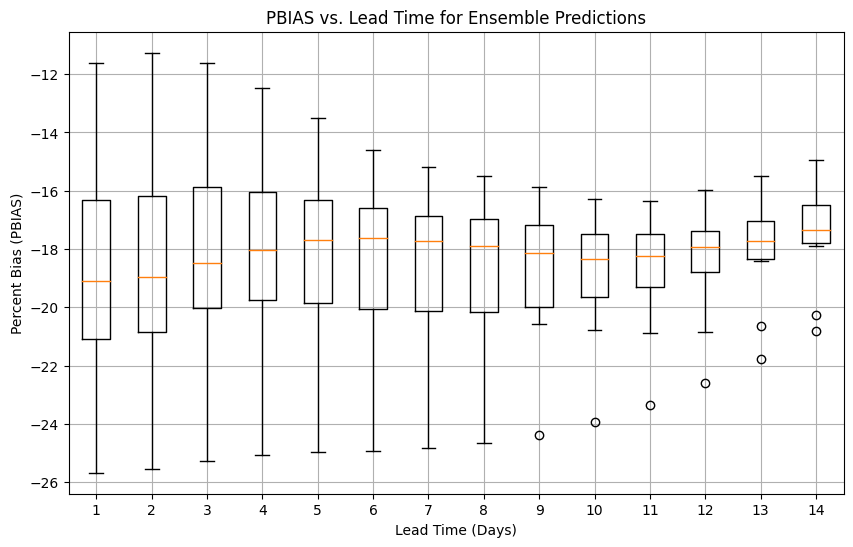

In [ ]:
# prompt: plot the PBIAS vs lead time for as box block for the ensimbles for each lead time



# Calculate PBIAS for each model and lead time
pbias_values_lstm = {lead_time: [] for lead_time in lead_times}
for lead_time in lead_times:
    for model_predictions in all_predictions[lead_time]:
        pbias_values_lstm[lead_time].append(pbias(y_test_destd[:, lead_time - 1], model_predictions))

# Create box plot for PBIAS vs. lead time
plt.figure(figsize=(10, 6))
plt.boxplot([pbias_values_lstm[lead_time] for lead_time in lead_times], labels=[f"{i}" for i in lead_times])
plt.xlabel("Lead Time (Days)")
plt.ylabel("Percent Bias (PBIAS)")
plt.title("PBIAS vs. Lead Time for Ensemble Predictions")
plt.grid(True)
plt.show()



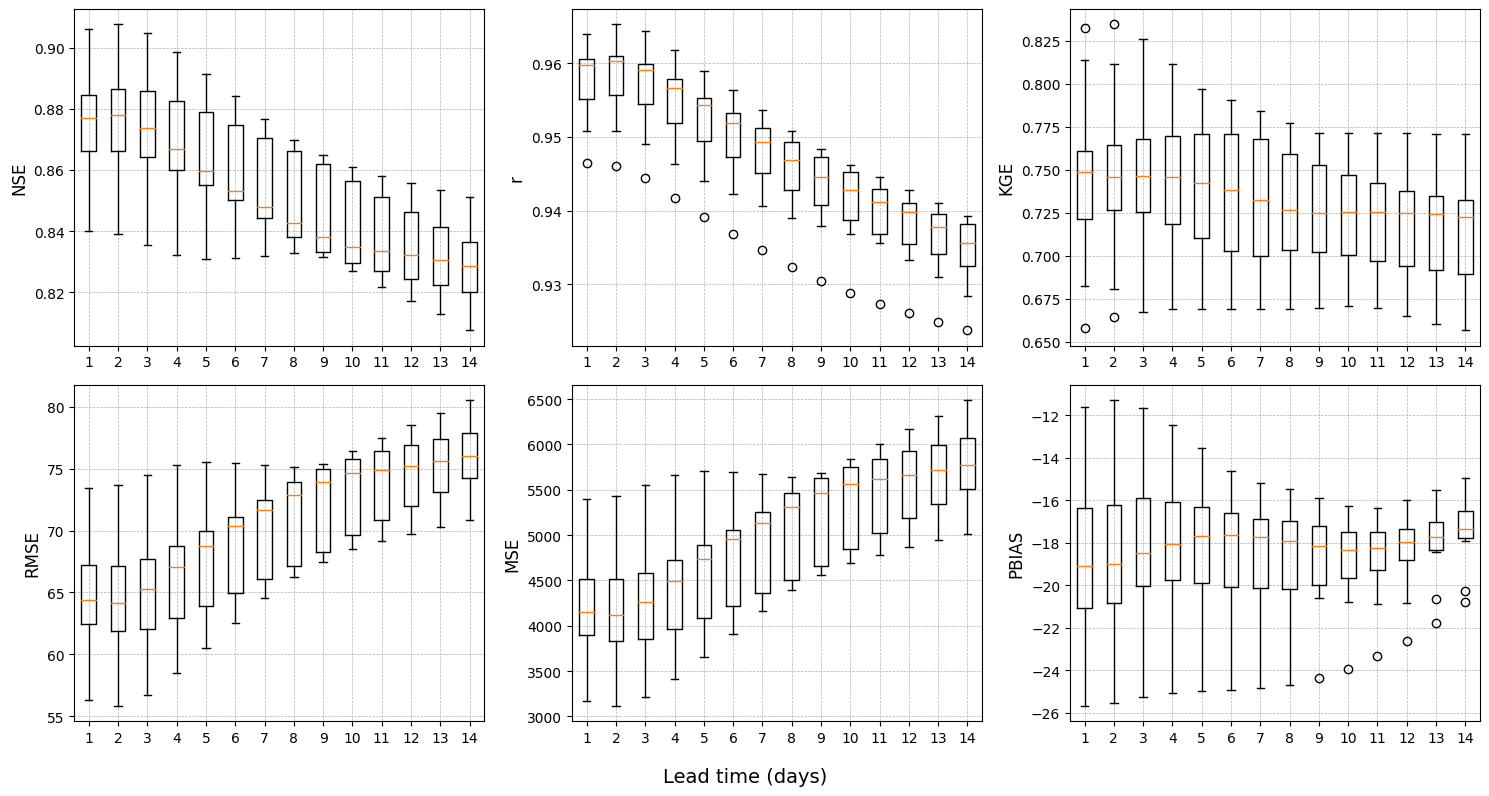

In [ ]:
# prompt: in one figure for a publication I wuold like to show NSE R2 KGE RMSE MSA PBIAS vs all lead times, every one in seperate graph but all in the same figure suitbale for publication

# Calculate metrics for each model and lead time
lead_times = range(1, 15)
num_models = 10

nse_values = {lead_time: [] for lead_time in lead_times}
r_values = {lead_time: [] for lead_time in lead_times}
kge_values = {lead_time: [] for lead_time in lead_times}
rmse_values = {lead_time: [] for lead_time in lead_times}
msa_values = {lead_time: [] for lead_time in lead_times}
pbias_values = {lead_time: [] for lead_time in lead_times}

for lead_time in lead_times:
    for model_predictions in all_predictions[lead_time]:
        nse_values[lead_time].append(nse(y_test_destd[:, lead_time - 1], model_predictions))
        r_values[lead_time].append(c_c(y_test_destd[:, lead_time - 1], model_predictions))
        kge_values[lead_time].append(kge(y_test_destd[:, lead_time - 1], model_predictions))
        rmse_values[lead_time].append(rmse(y_test_destd[:, lead_time - 1], model_predictions))
        msa_values[lead_time].append(mse(y_test_destd[:, lead_time - 1], model_predictions))
        pbias_values[lead_time].append(pbias(y_test_destd[:, lead_time - 1], model_predictions))

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns
axes = axes.flatten()

# Plot each metric vs. lead time
metrics = [nse_values, r_values, kge_values, rmse_values, msa_values, pbias_values]
metric_names = ['NSE', 'r', 'KGE', 'RMSE', 'MSE', 'PBIAS']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i]
    ax.boxplot([metric[lead_time] for lead_time in lead_times], labels=[f"{i}" for i in lead_times])
    #ax.set_xlabel("Lead Time (Days)", fontsize=12)
    ax.set_ylabel(metric_name, fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

# Adjust layout and display the plot
fig.supxlabel('Lead time (days)', fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# prompt: save all the metrics dictinories in the results folder in a way that we can read them again , the are all for the lstm model so use an indicative name save the all in one pickle

import pickle

# Assuming 'dir_output' is defined and points to your results folder
results_file_path = os.path.join(dir_output, 'lstm_metrics.pkl')

# Create a dictionary to hold all the metrics
all_metrics = {
    'nse': nse_values,
    'r': r_values,
    'kge': kge_values,
    'rmse': rmse_values,
    'msa': msa_values,
    'pbias': pbias_values
}

# Save the dictionary to a pickle file
with open(results_file_path, 'wb') as f:
    pickle.dump(all_metrics, f)

print(f"All metrics saved to: {results_file_path}")


All metrics saved to: /content/drive/My Drive/Colab Notebooks/HBV_LSTM_UBNB/output/lstm_metrics.pkl


In [ ]:
# prompt: read them again

# Assuming 'dir_output' is the same as before
results_file_path = os.path.join(dir_output, 'lstm_metrics.pkl')

# Load the metrics from the pickle file
with open(results_file_path, 'rb') as f:
    all_metrics = pickle.load(f)

# Now you can access the metrics like this:
nse_values = all_metrics['nse']
#r2_values = all_metrics['r2']
# ... and so on for other metrics

# Example: Print the NSE values for lead time 1



In [ ]:
all_metrics


{'nse': {1: [0.8806989635315446,
   0.9059860713537762,
   0.8690999797565072,
   0.8846160832299479,
   0.8400917838239277,
   0.8733713176073603,
   0.8489023033143022,
   0.8845148633878831,
   0.8653288716094626,
   0.896038871884563],
  2: [0.8845412297120345,
   0.9076682627996802,
   0.8688394305958278,
   0.8799741214823256,
   0.8390462569903159,
   0.8759746678568543,
   0.8545397670921857,
   0.8870259227305534,
   0.8654619325047768,
   0.8977685128961634],
  3: [0.8847830887038017,
   0.9048134547510244,
   0.865562712118193,
   0.873905420092717,
   0.8353812723744237,
   0.8734302695323415,
   0.8545729639502115,
   0.8862666302960672,
   0.8638315612022393,
   0.8956792661166845],
  4: [0.8817157710334708,
   0.8987442804304913,
   0.8602521622437027,
   0.8659282874032931,
   0.8320777063997513,
   0.8676955177303151,
   0.8512546678176119,
   0.8829514045540111,
   0.8598411710633603,
   0.8907700365017566],
  5: [0.8776780632111207,
   0.8915522769151321,
   0.854860

In [ ]:
# prompt: in a table report NSE R2 KGE RMSE PBIAS RMSE for lead times 1,4,7,10,14, make the metrics in the rows and the lead times coulmsn , lead times horizontally

# Calculate metrics for each model and lead time
lead_times = [1, 4, 7, 10, 14]
num_models = 10

nse_values = {lead_time: [] for lead_time in lead_times}
r2_values = {lead_time: [] for lead_time in lead_times}
kge_values = {lead_time: [] for lead_time in lead_times}
rmse_values = {lead_time: [] for lead_time in lead_times}
msa_values = {lead_time: [] for lead_time in lead_times}
pbias_values = {lead_time: [] for lead_time in lead_times}

for lead_time in lead_times:
    for model_predictions in all_predictions[lead_time]:
        nse_values[lead_time].append(nse(y_test_destd[:, lead_time - 1], model_predictions))
        r2_values[lead_time].append(r2(y_test_destd[:, lead_time - 1], model_predictions))
        kge_values[lead_time].append(kge(y_test_destd[:, lead_time - 1], model_predictions))
        rmse_values[lead_time].append(rmse(y_test_destd[:, lead_time - 1], model_predictions))
        msa_values[lead_time].append(mse(y_test_destd[:, lead_time - 1], model_predictions))
        pbias_values[lead_time].append(pbias(y_test_destd[:, lead_time - 1], model_predictions))

# Create a DataFrame for the table
data = {
    'Metric': ['NSE', 'R2', 'KGE', 'RMSE', 'MSA', 'PBIAS'],
    'Lead Time 1': [np.mean(nse_values[1]), np.mean(r2_values[1]), np.mean(kge_values[1]),
                     np.mean(rmse_values[1]), np.mean(msa_values[1]), np.mean(pbias_values[1])],
    'Lead Time 4': [np.mean(nse_values[4]), np.mean(r2_values[4]), np.mean(kge_values[4]),
                     np.mean(rmse_values[4]), np.mean(msa_values[4]), np.mean(pbias_values[4])],
    'Lead Time 7': [np.mean(nse_values[7]), np.mean(r2_values[7]), np.mean(kge_values[7]),
                     np.mean(rmse_values[7]), np.mean(msa_values[7]), np.mean(pbias_values[7])],
    'Lead Time 10': [np.mean(nse_values[10]), np.mean(r2_values[10]), np.mean(kge_values[10]),
                      np.mean(rmse_values[10]), np.mean(msa_values[10]), np.mean(pbias_values[10])],
    'Lead Time 14': [np.mean(nse_values[14]), np.mean(r2_values[14]), np.mean(kge_values[14]),
                      np.mean(rmse_values[14]), np.mean(msa_values[14]), np.mean(pbias_values[14])]
}

df_table = pd.DataFrame(data)

# Display the table
df_table


Metric  Lead Time 1  Lead Time 4  Lead Time 7  Lead Time 10  Lead Time 14
0    NSE     0.874865     0.869123     0.854643      0.841829      0.828248
1     R2     0.874865     0.869123     0.854643      0.841829      0.828248
2    KGE     0.745197     0.743057     0.731866      0.722493      0.714725
3   RMSE    64.794214    66.278171    69.919887     72.967111     76.035758
4    MSA  4222.749624  4415.655476  4903.181008   5334.346176   5790.932507
5  PBIAS   -18.714803   -18.180032   -18.537627    -18.812231    -17.515225

### Metrics for different flow regimes

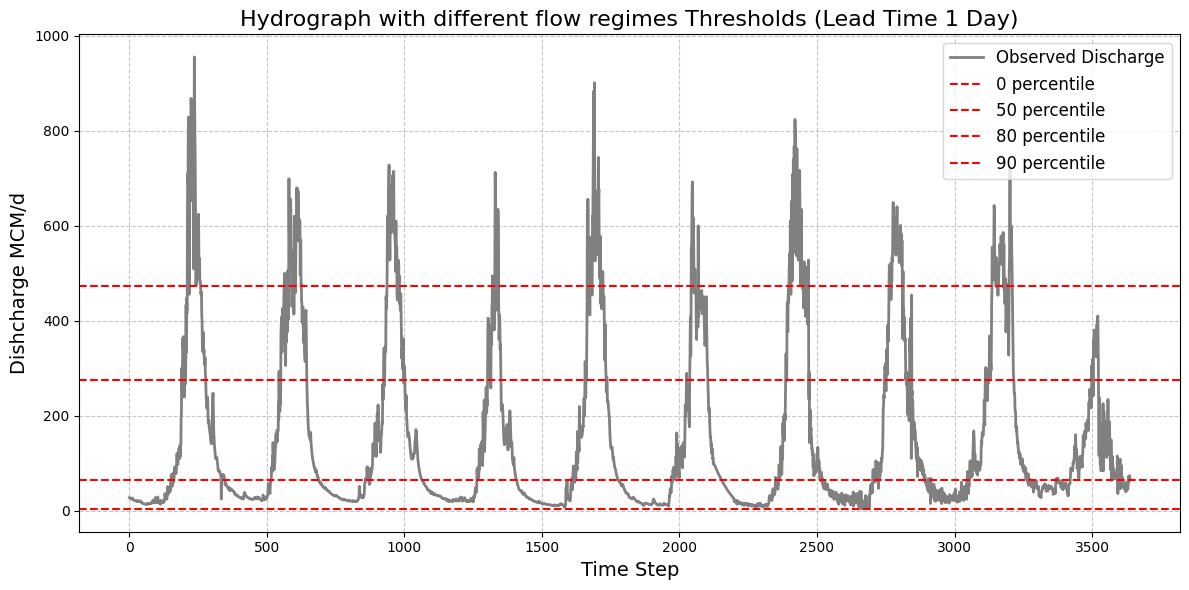

In [14]:


# Calculating the percentiles by soring all the data in a decending order and applying 1-(m/n+1) where m is the rank and n is the number of data
return_periods = [1, 2, 5, 10]
thresholds = {}
for rp in return_periods:
    thresholds[rp] = np.percentile(y_test_destd[:, 0], 100 - (100 / rp))  # Lead time 1 is at index 0

# Plot the hydrograph with return period thresholds
plt.figure(figsize=(12, 6))

# Observed discharge
plt.plot( y_test_destd[:, 0], label="Observed Discharge", color='gray', linewidth=2)

# Return period thresholds
for rp, threshold in thresholds.items():
   plt.axhline(y=threshold, color='red', linestyle='--', label=f"{int(100-(1/rp)*100)} percentile")

plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Dishcharge MCM/d", fontsize=14)
plt.title("Hydrograph with different flow regimes Thresholds (Lead Time 1 Day)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [16]:
# prompt: now calculate the events abov each threshold but less than the next one exept for the last threshold just aove it, just give me teh count, report the indexces as well

# Calculate events above each threshold but less than the next one
event_counts = {}
event_indices = {}
sorted_thresholds = sorted(thresholds.values())

for i in range(len(sorted_thresholds) - 1):
    lower_threshold = sorted_thresholds[i]
    upper_threshold = sorted_thresholds[i + 1]

    event_indices[i] = np.where((y_test_destd[:, 0] > lower_threshold) & (y_test_destd[:, 0] <= upper_threshold))[0]
    event_counts[i] = len(event_indices[i])

# Events above the last threshold
last_threshold = sorted_thresholds[-1]
event_indices[len(sorted_thresholds) - 1] = np.where(y_test_destd[:, 0] > last_threshold)[0]
event_counts[len(sorted_thresholds) - 1] = len(event_indices[len(sorted_thresholds) - 1])

# Print the counts and indices
for i, count in event_counts.items():
    print(f"Events above threshold {i+1} but below threshold {i+2 if i < len(event_counts) - 1 else 'end'}: {count}")
   # print(f"Indices: {event_indices[i]}")


Events above threshold 1 but below threshold 2: 1819
Events above threshold 2 but below threshold 3: 1091
Events above threshold 3 but below threshold 4: 364
Events above threshold 4 but below threshold end: 364


In [ ]:
event_counts

{0: 1819, 1: 1091, 2: 364, 3: 364}

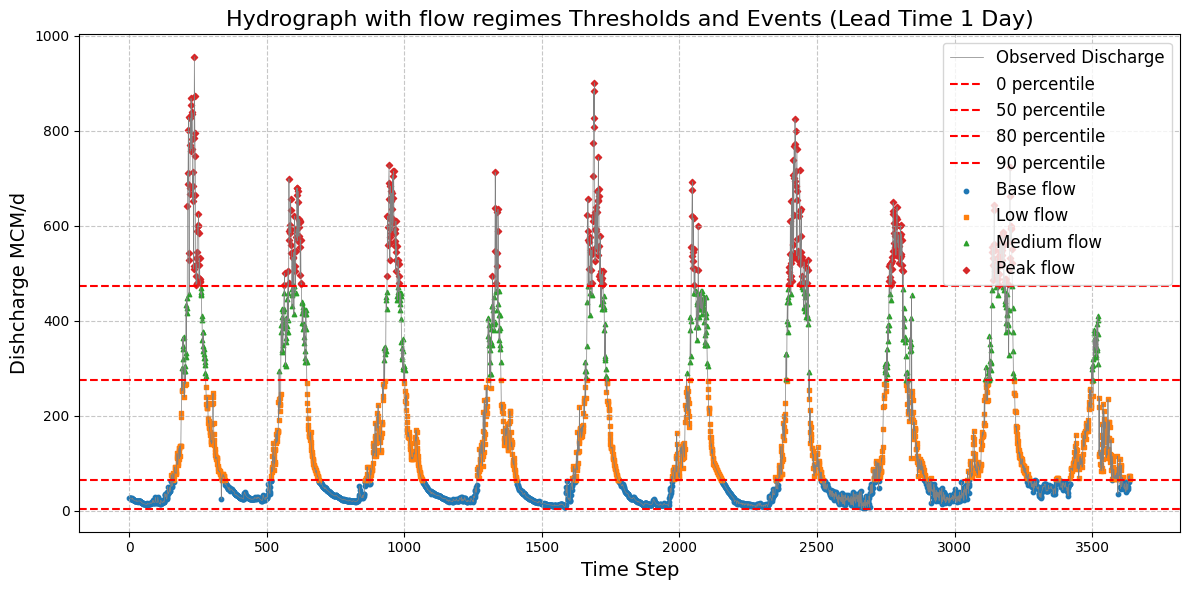

In [17]:
# prompt: can you plot those events in the hydrograp with different markers

# Plot the hydrograph with return period thresholds and event markers
plt.figure(figsize=(12, 6))

# Observed discharge
plt.plot(y_test_destd[:, 0], label="Observed Discharge", color='gray', linewidth=0.5)

# Return period thresholds
for rp, threshold in thresholds.items():
   plt.axhline(y=threshold, color='red', linestyle='--', label=f"{int(100-(1/rp)*100)} percentile")



regimes = ['Base','Low','Medium','Peak']
# Plot events with different markers
markers = ['o', 's', '^', 'D', 'v']  # Different markers for each event category
for i, indices in event_indices.items():
    if indices.size > 0:  # Check if there are events in this category
        plt.scatter( indices, y_test_destd[indices, 0], marker=markers[i], s=10, label=f"{regimes[i]} flow")

plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Dishcharge MCM/d", fontsize=14)
plt.title("Hydrograph with flow regimes Thresholds and Events (Lead Time 1 Day)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


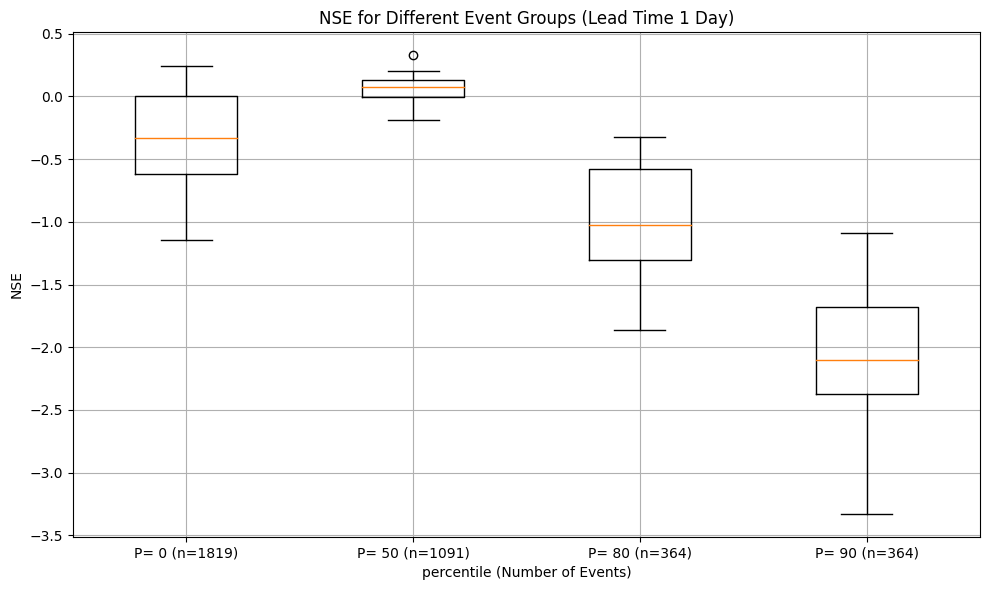

In [ ]:
# prompt: for those events can you fined the NSE for diffferent events group, n the x axis denote the teh nuber of event in the x axis labels, make it as box plot, and show they, returnperiod as well in the x axis denot the return period in the x axil labels, return period (number of events) in the x axis

# Calculate NSE for each event group and model
nse_values_by_event = {}
for i, indices in event_indices.items():
    nse_values_by_event[i] = []
    for model_num in range(num_models):
        y_pred_event = all_predictions[1][model_num][indices]  # Lead time 1 predictions for this event group
        y_obs_event = y_test_destd[indices, 0]
        if len(y_obs_event) > 0:  # Check if there are events to calculate NSE for
            nse_value = nse(y_obs_event, y_pred_event)
            nse_values_by_event[i].append(nse_value)

# Create box plot for NSE vs. event group
plt.figure(figsize=(10, 6))
boxplot_data = [nse_values_by_event[i] for i in sorted(nse_values_by_event.keys())]
# x-axis labels with return period and number of events
x_labels = [f"P= {int(100-(1/return_periods[i])*100)} (n={event_counts[i]})" for i in sorted(nse_values_by_event.keys())]
plt.boxplot(boxplot_data, labels=x_labels)
plt.xlabel('percentile (Number of Events)')
plt.ylabel('NSE')
plt.title('NSE for Different Event Groups (Lead Time 1 Day)')
plt.grid(True)
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


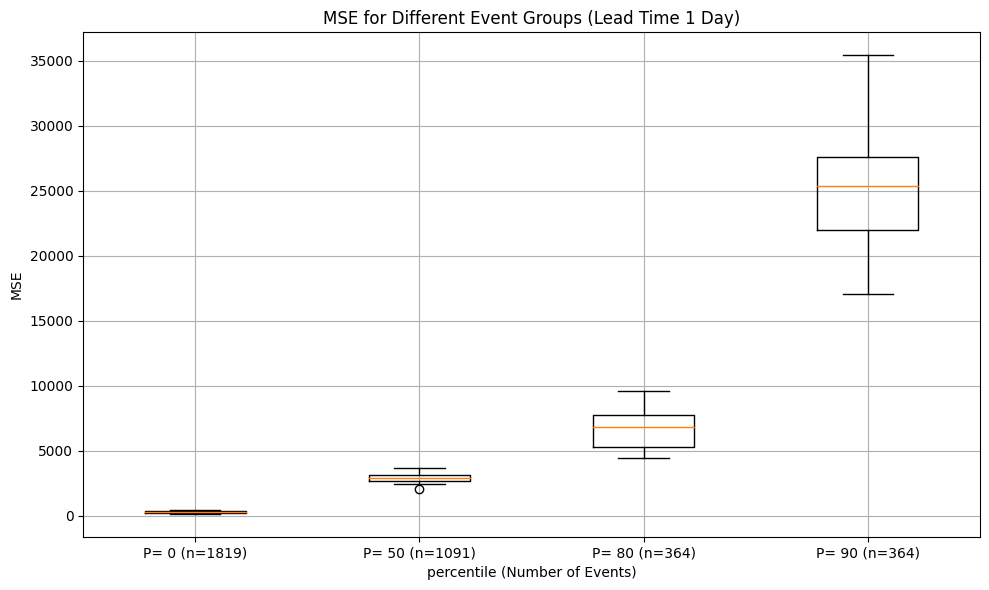

In [ ]:
# prompt: do the same for mse

# Calculate MSE for each event group and model
mse_values_by_event = {}
for i, indices in event_indices.items():
    mse_values_by_event[i] = []
    for model_num in range(num_models):
        y_pred_event = all_predictions[1][model_num][indices]  # Lead time 1 predictions for this event group
        y_obs_event = y_test_destd[indices, 0]
        if len(y_obs_event) > 0:  # Check if there are events to calculate MSE for
            mse_value = mse(y_obs_event, y_pred_event)  # Calculate MSE
            mse_values_by_event[i].append(mse_value)

# Create box plot for MSE vs. event group
plt.figure(figsize=(10, 6))
boxplot_data = [mse_values_by_event[i] for i in sorted(mse_values_by_event.keys())]
# x-axis labels with return period and number of events
x_labels = [f"P= {int(100-(1/return_periods[i])*100)} (n={event_counts[i]})" for i in sorted(mse_values_by_event.keys())]
plt.boxplot(boxplot_data, labels=x_labels)
plt.xlabel('percentile (Number of Events)')
plt.ylabel('MSE')
plt.title('MSE for Different Event Groups (Lead Time 1 Day)')
plt.grid(True)
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


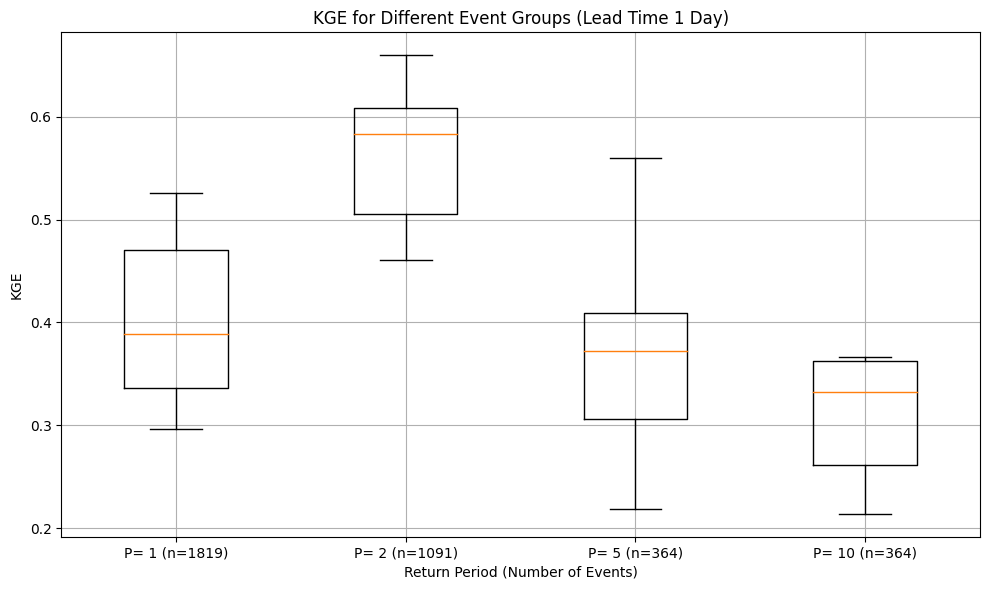

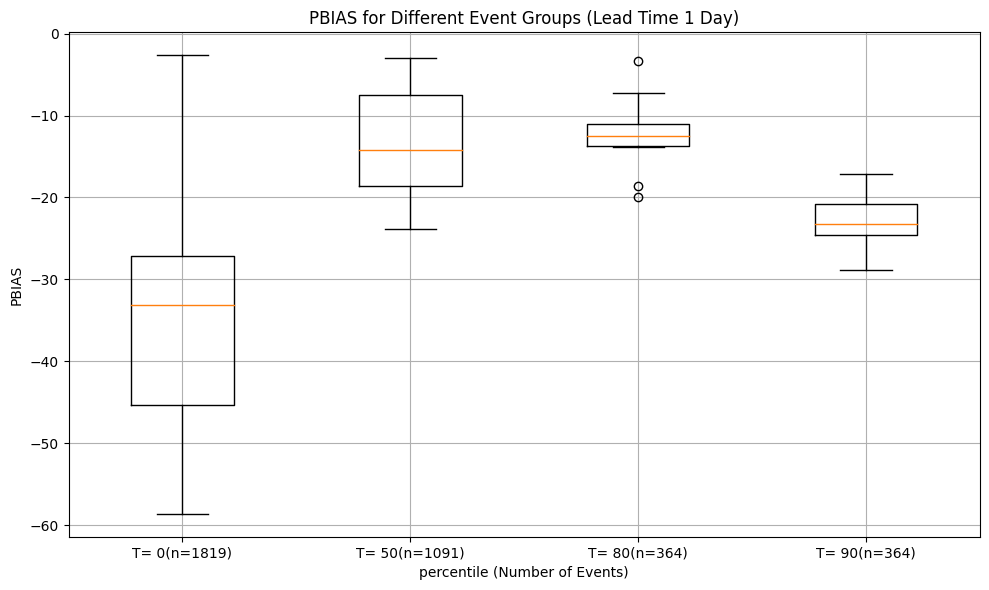

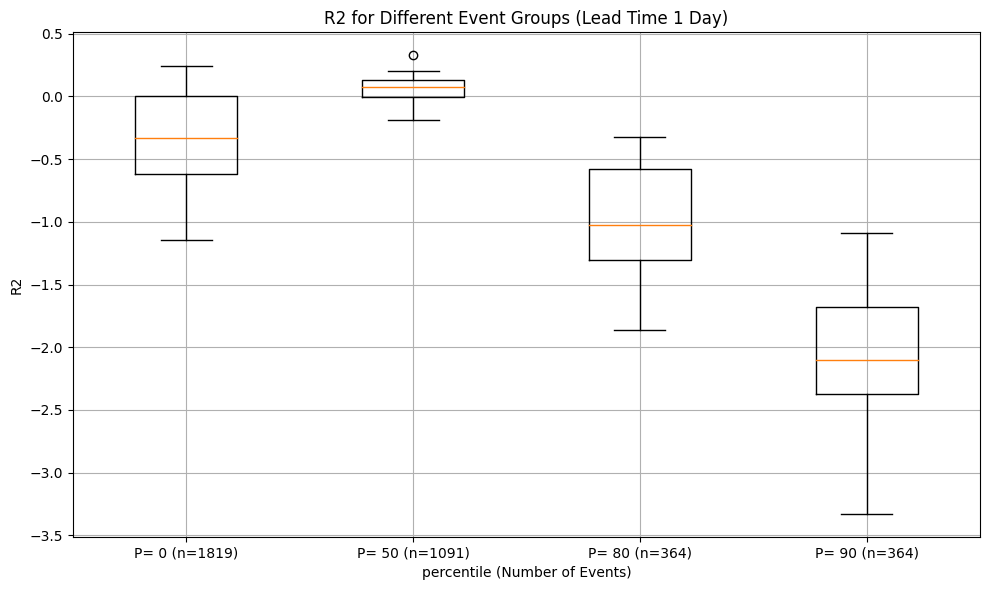

In [ ]:
# prompt: do the same for KGE, PBIAS, R2

# Calculate KGE for each event group and model
kge_values_by_event = {}
for i, indices in event_indices.items():
    kge_values_by_event[i] = []
    for model_num in range(num_models):
        y_pred_event = all_predictions[1][model_num][indices]  # Lead time 1 predictions for this event group
        y_obs_event = y_test_destd[indices, 0]
        if len(y_obs_event) > 0:  # Check if there are events to calculate KGE for
            kge_value = kge(y_obs_event, y_pred_event)
            kge_values_by_event[i].append(kge_value)

# Create box plot for KGE vs. event group
plt.figure(figsize=(10, 6))
boxplot_data = [kge_values_by_event[i] for i in sorted(kge_values_by_event.keys())]
# x-axis labels with return period and number of events
x_labels = [f"P= {return_periods[i]} (n={event_counts[i]})" for i in sorted(kge_values_by_event.keys())]
plt.boxplot(boxplot_data, labels=x_labels)
plt.xlabel('Return Period (Number of Events)')
plt.ylabel('KGE')
plt.title('KGE for Different Event Groups (Lead Time 1 Day)')
plt.grid(True)
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Calculate PBIAS for each event group and model
pbias_values_by_event = {}
for i, indices in event_indices.items():
    pbias_values_by_event[i] = []
    for model_num in range(num_models):
        y_pred_event = all_predictions[1][model_num][indices]  # Lead time 1 predictions for this event group
        y_obs_event = y_test_destd[indices, 0]
        if len(y_obs_event) > 0:  # Check if there are events to calculate PBIAS for
            pbias_value = pbias(y_obs_event, y_pred_event)
            pbias_values_by_event[i].append(pbias_value)

# Create box plot for PBIAS vs. event group
plt.figure(figsize=(10, 6))
boxplot_data = [pbias_values_by_event[i] for i in sorted(pbias_values_by_event.keys())]
# x-axis labels with return period and number of events
x_labels = [f"T= {int(100-(1/return_periods[i])*100)}(n={event_counts[i]})" for i in sorted(pbias_values_by_event.keys())]
plt.boxplot(boxplot_data, labels=x_labels)
plt.xlabel('percentile (Number of Events)')
plt.ylabel('PBIAS')
plt.title('PBIAS for Different Event Groups (Lead Time 1 Day)')
plt.grid(True)
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

# Calculate R2 for each event group and model
r2_values_by_event = {}
for i, indices in event_indices.items():
    r2_values_by_event[i] = []
    for model_num in range(num_models):
        y_pred_event = all_predictions[1][model_num][indices]  # Lead time 1 predictions for this event group
        y_obs_event = y_test_destd[indices, 0]
        if len(y_obs_event) > 0:  # Check if there are events to calculate R2 for
            r2_value = r2(y_obs_event, y_pred_event)
            r2_values_by_event[i].append(r2_value)

# Create box plot for R2 vs. event group
plt.figure(figsize=(10, 6))
boxplot_data = [r2_values_by_event[i] for i in sorted(r2_values_by_event.keys())]
# x-axis labels with return period and number of events
x_labels = [f"P= {int(100-(1/return_periods[i])*100)} (n={event_counts[i]})" for i in sorted(r2_values_by_event.keys())]
plt.boxplot(boxplot_data, labels=x_labels)
plt.xlabel('percentile (Number of Events)')
plt.ylabel('R2')
plt.title('R2 for Different Event Groups (Lead Time 1 Day)')
plt.grid(True)
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


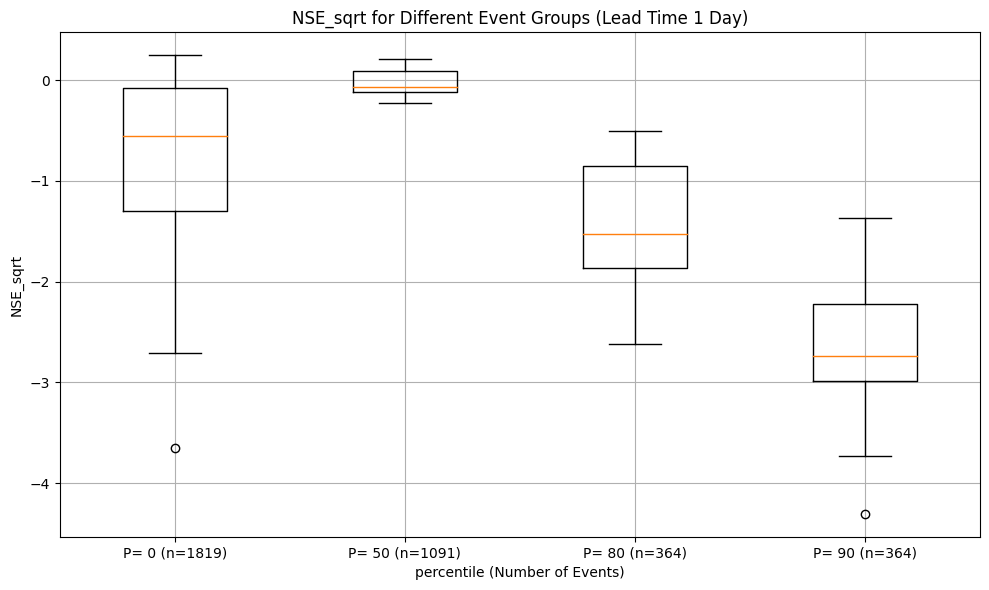

In [ ]:
# prompt: do the same for  nse_sqrt

# Calculate NSE_sqrt for each event group and model
nse_sqrt_values_by_event = {}
for i, indices in event_indices.items():
    nse_sqrt_values_by_event[i] = []
    for model_num in range(num_models):
        y_pred_event = all_predictions[1][model_num][indices]  # Lead time 1 predictions for this event group
        y_obs_event = y_test_destd[indices, 0]
        if len(y_obs_event) > 0:  # Check if there are events to calculate NSE_sqrt for
            nse_sqrt_value = nse_sqrt(y_obs_event, y_pred_event)  # Assuming you have a function called nse_sqrt
            nse_sqrt_values_by_event[i].append(nse_sqrt_value)

# Create box plot for NSE_sqrt vs. event group
plt.figure(figsize=(10, 6))
boxplot_data = [nse_sqrt_values_by_event[i] for i in sorted(nse_sqrt_values_by_event.keys())]
# x-axis labels with return period and number of events
x_labels = [f"P= {int(100-(1/return_periods[i])*100)} (n={event_counts[i]})" for i in sorted(nse_sqrt_values_by_event.keys())]
plt.boxplot(boxplot_data, labels=x_labels)
plt.xlabel('percentile (Number of Events)')
plt.ylabel('NSE_sqrt')
plt.title('NSE_sqrt for Different Event Groups (Lead Time 1 Day)')
plt.grid(True)
#plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
# # prompt: save all the metrics for all the return period groups for all the lead times, in the folder output , use indcitive name, dont calcualte threshold again or return perido use the  defined vcalues

# # Assuming 'dir_output' is defined and points to your results folder
# results_file_path = os.path.join(dir_output, 'lstm_metrics_by_return_period.pkl')

# # Initialize a dictionary to store all metrics
# all_metrics_by_return_period = {}

# # Calculate metrics for each lead time
# for lead_time in lead_times:
#     all_metrics_by_return_period[lead_time] = {}

#     # Calculate metrics for each event group within the lead time
#     for i, indices in event_indices.items():
#         all_metrics_by_return_period[lead_time][i] = {
#             'nse': [],
#             'kge': [],
#             'pbias': [],
#             'rmse': [],
#             'mse': [],
#             'r': [],
#         }
#         for model_num in range(num_models):
#             y_pred_event = all_predictions[lead_time][model_num][indices]
#             y_obs_event = y_test_destd[indices, lead_time - 1]
#             if len(y_obs_event) > 0:
#                 all_metrics_by_return_period[lead_time][i]['nse'].append(nse(y_obs_event, y_pred_event))
#                 all_metrics_by_return_period[lead_time][i]['kge'].append(kge(y_obs_event, y_pred_event))
#                 all_metrics_by_return_period[lead_time][i]['pbias'].append(pbias(y_obs_event, y_pred_event))
#                 all_metrics_by_return_period[lead_time][i]['rmse'].append(rmse(y_obs_event, y_pred_event))
#                 all_metrics_by_return_period[lead_time][i]['mse'].append(mse(y_obs_event, y_pred_event))
#                 all_metrics_by_return_period[lead_time][i]['r'].append(c_c(y_obs_event, y_pred_event))

# # Save the dictionary to a pickle file
# with open(results_file_path, 'wb') as f:
#     pickle.dump(all_metrics_by_return_period, f)

# print(f"All metrics by return period saved to: {results_file_path}")


All metrics by return period saved to: /content/drive/My Drive/Colab Notebooks/HBV_LSTM_UBNB/output/lstm_metrics_by_return_period.pkl


In [ ]:
# # prompt: save all the metrics for all the lead times  for different T groups in a way that we can read them later, they are metrics for lstm for differtn return period, use indictave name

# # Assuming all your metrics dictionaries (nse_values_by_event, r2_values_by_event, etc.)
# # are already calculated as in your provided code...

# # Create a dictionary to hold all the metrics
# all_metrics_by_event = {
#     'nse': nse_values_by_event,
#     'r2': r2_values_by_event,
#     'kge': kge_values_by_event,
#     'rmse': rmse_values_by_event,
#     'msa': msa_values_by_event,
#     'pbias': pbias_values_by_event
# }

# # Define the filename for saving the metrics
# filename = 'lstm_metrics_by_return_period.pkl'

# # Save the dictionary to a pickle file
# with open(filename, 'wb') as f:
#     pickle.dump(all_metrics_by_event, f)

# print(f"All metrics by return period saved to: {filename}")


All metrics by return period saved to: lstm_metrics_by_return_period.pkl


In [ ]:
# prompt: read them again all for lead time 1 and 14

# Assuming 'dir_output' is the same as before
results_file_path = os.path.join(dir_output, 'lstm_metrics_by_return_period.pkl')

# Load the metrics from the pickle file
with open(results_file_path, 'rb') as f:
    all_metrics_by_return_period = pickle.load(f)



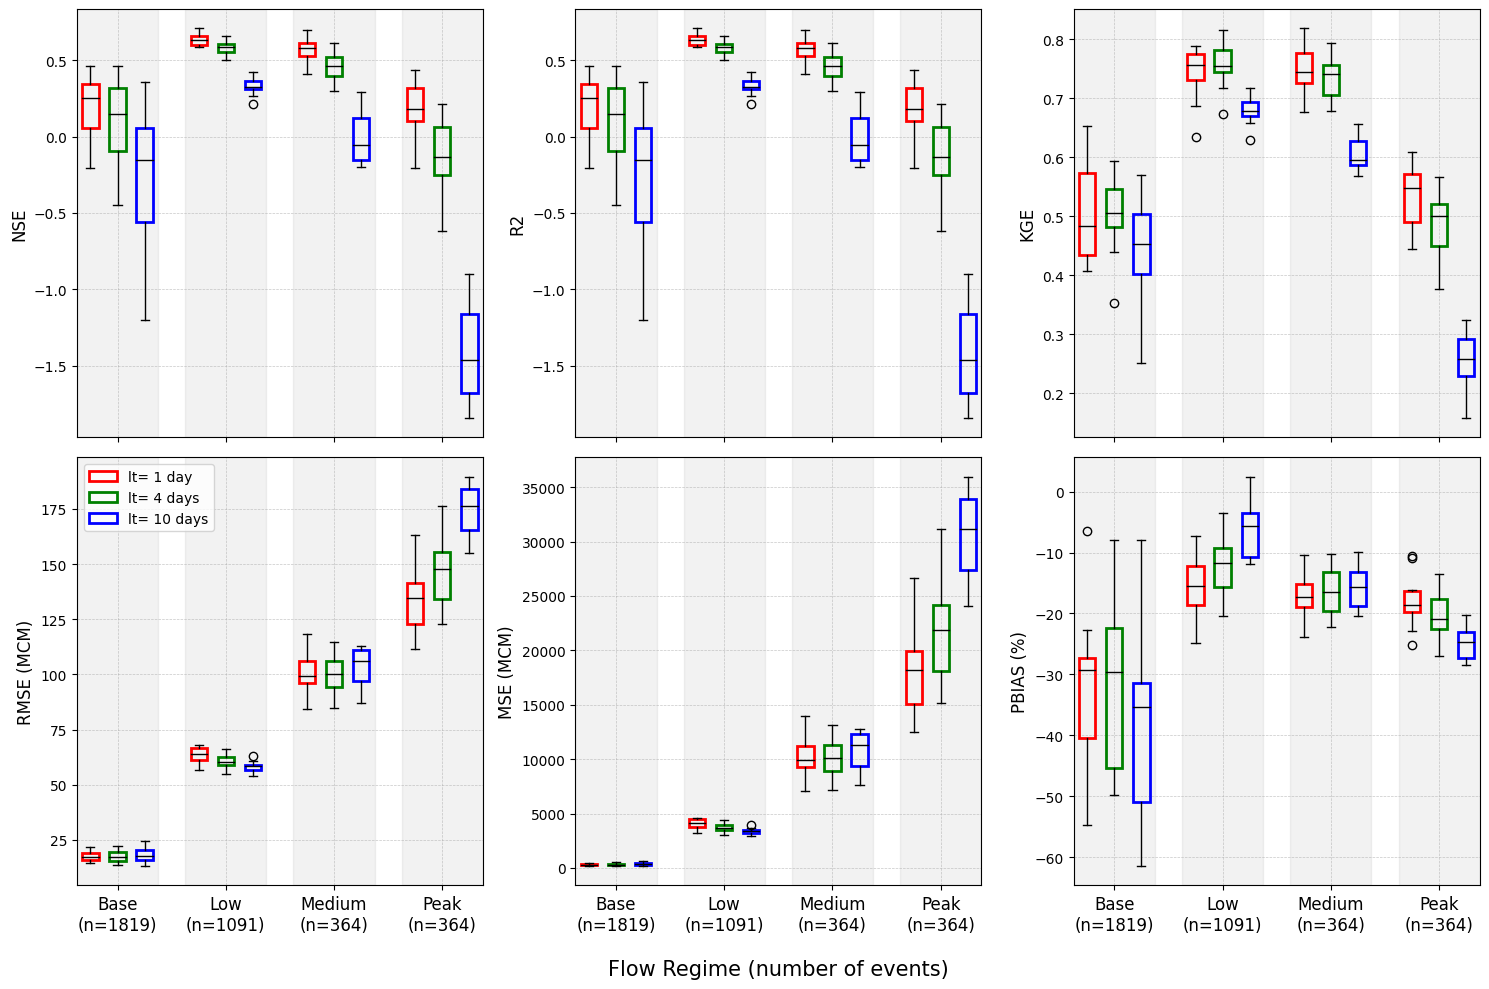

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Define metric names and their display labels
metric_names = ['nse', 'r2', 'kge', 'rmse', 'mse', 'pbias']
metric_labels = {'nse': 'NSE', 'r2': 'R2', 'kge': 'KGE',
                 'rmse': 'RMSE (MCM)', 'mse': 'MSE (MCM)', 'pbias': 'PBIAS (%)'}

# Colors for the outlines of the box plots for lead times 1, 7, and 14
colors = ['red', 'green', 'blue']

for i, metric_name in enumerate(metric_names):
    ax = axes[i]
    boxplot_data = []
    positions = []
    x_labels = []

    for rp in range(4):  # Return period groups 0 to 3
        boxplot_data.extend([
            all_metrics_by_return_period[1][rp][metric_name],
            all_metrics_by_return_period[4][rp][metric_name],
            all_metrics_by_return_period[10][rp][metric_name]
        ])
        positions.extend([rp * 4 - 1, rp * 4, rp * 4 + 1])  # Adjusting for three boxes per return period
        x_labels.append(f"{regimes[rp]}\n(n={event_counts[rp]})")

    # Creating box plots with hollow boxes
    bp = ax.boxplot(boxplot_data, positions=positions, patch_artist=True, widths=0.6, notch=False)

    # Set color for the outlines and make boxes hollow
    for patch, medline, color in zip(bp['boxes'], bp['medians'], colors * 4):  # 4 return period groups
        patch.set_facecolor('none')  # Make box hollow
        patch.set_edgecolor(color)  # Set the color of the outline
        patch.set_linewidth(2)  # Set the thickness of the outline
        medline.set_color('black')  # Set median line color

    ax.set_ylabel(metric_labels[metric_name], fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Set x-ticks and labels
    ax.set_xticks([rp * 4 for rp in range(4)])
    if i >= 3:  # Only set x-tick labels for the bottom row
        ax.set_xticklabels(x_labels, rotation=0, ha="center", fontsize=12)
    else:
        ax.set_xticklabels([])

    # Add legend in a specific subplot
    if i == 3:  # Add legend in the fourth subplot
        ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2]],
                  ["lt= 1 day", "lt= 4 days", "lt= 10 days"],
                  loc='upper left', fontsize=10)

    # Highlighting return period lines
    for rp in range(4):
        ax.axvspan(rp * 4 - 1.5, rp * 4 + 1.5, color='grey', alpha=0.1)

# Set x-axis label for the bottom row
axes[4].set_xlabel('Flow Regime (number of events)', fontsize=15, labelpad=18)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# HBV-light conceptual model

## Loading the result of the model runs

In [18]:
# prompt: in the dir output  there is folder hbv_output read have the follwing excel files, hbv_chirps_results_testing, hbv_chirps_results_calibration, hbv_era_results_testing, hbv_era_results_calibration...  read them to data frame and give the df proper names

# Read Excel files into DataFrames
hbv_chirps_results_testing = pd.read_excel(dir_output + "/hbv_output/hbv_chirps_results_testing.xlsx")
hbv_chirps_results_calibration = pd.read_excel(dir_output + "/hbv_output/hbv_chirps_results_calibration.xlsx")
hbv_era_results_testing = pd.read_excel(dir_output + "/hbv_output/hbv_era_results_testing.xlsx")
hbv_era_results_calibration = pd.read_excel(dir_output + "/hbv_output/hbv_era_results_calibration.xlsx")




In [19]:
print(hbv_chirps_results_testing.shape)
print(hbv_era_results_testing.shape)
print(hbv_chirps_results_calibration.shape)
print(hbv_era_results_calibration.shape)

(3652, 12)
(3652, 12)
(8766, 12)
(8766, 12)


### hydrographs

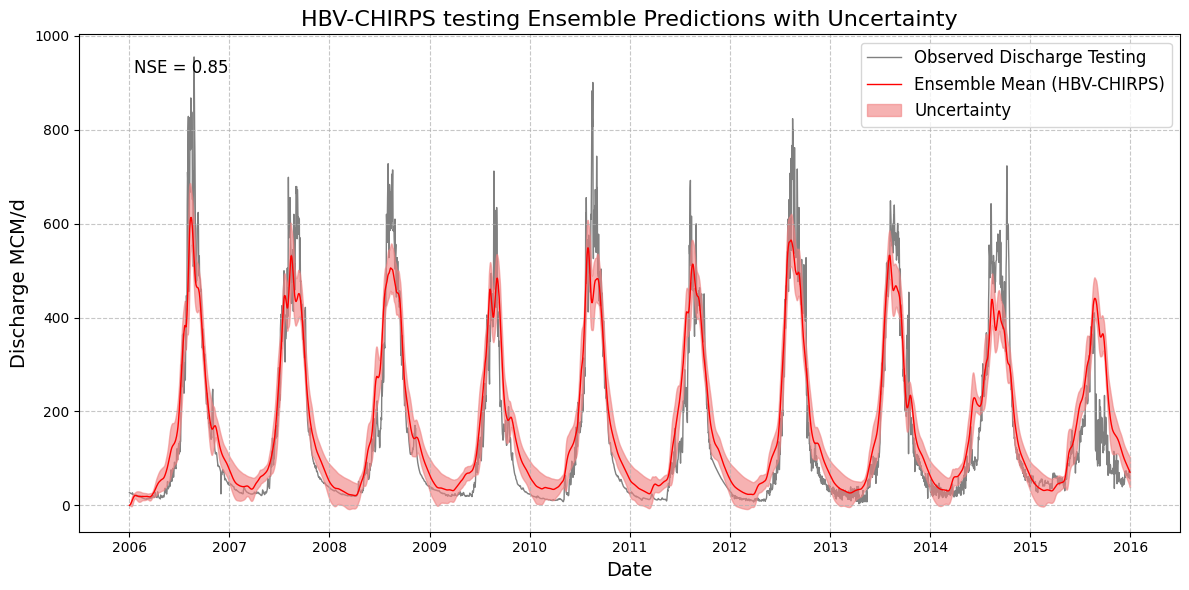

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the conversion factor
conversion_factor = 176000 / 1000

# Assuming 'hbv_chirps_results_testing' is your DataFrame
# Extract relevant columns and apply the conversion factor
hbv_chirps_results_testing['Date'] = pd.to_datetime(hbv_chirps_results_testing['Date'])
qobs = hbv_chirps_results_testing['Qobs'] * conversion_factor
qsims = hbv_chirps_results_testing[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                    'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']] * conversion_factor

# Calculate ensemble mean and standard deviation
ensemble_mean = qsims.mean(axis=1)
ensemble_std = qsims.std(axis=1)

# Calculate NSE
def nse(observed, simulated):
    return 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

nse_chirps_test_mean = nse(qobs, ensemble_mean)

# Plotting
plt.figure(figsize=(12, 6))

# Observed discharge
plt.plot(hbv_chirps_results_testing['Date'], qobs, label="Observed Discharge Testing", color='gray', linewidth=1, zorder=1)

# Ensemble mean
plt.plot(hbv_chirps_results_testing['Date'], ensemble_mean, label="Ensemble Mean (HBV-CHIRPS)", color='red', linewidth=1)

# 95% prediction interval
plt.fill_between(hbv_chirps_results_testing['Date'],
                 ensemble_mean - 2 * ensemble_std,
                 ensemble_mean + 2 * ensemble_std,
                 color='lightcoral', alpha=0.6, label="Uncertainty")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Discharge MCM/d", fontsize=14)  # Adjust units as needed
plt.title("HBV-CHIRPS testing Ensemble Predictions with Uncertainty", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display NSE value on the plot
plt.text(0.05, 0.95, f"NSE = {nse_chirps_test_mean:.2f}", transform=plt.gca().transAxes, fontsize=12, va='top')

plt.tight_layout()
plt.show()


In [21]:
pbias(qobs[qobs>900], ensemble_mean[qobs>900])

-48.18742293464858

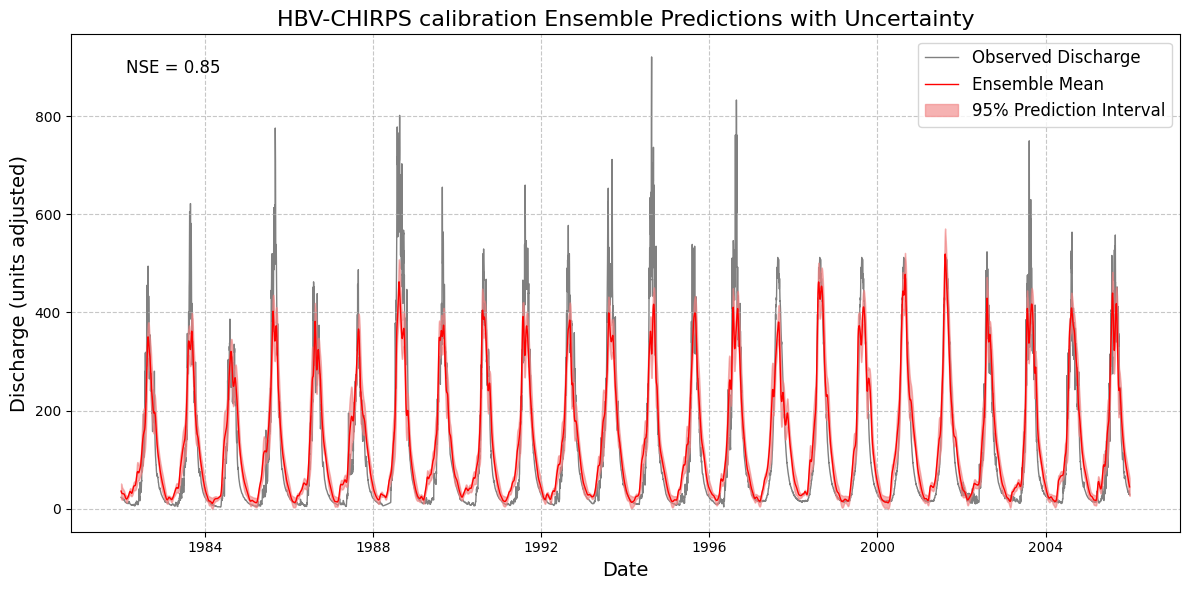

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the conversion factor
conversion_factor = 176000 / 1000

# Assuming 'hbv_chirps_results_testing' is your DataFrame
# Extract relevant columns and apply the conversion factor
hbv_chirps_results_calibration['Date'] = pd.to_datetime(hbv_chirps_results_calibration['Date'])
qobs = hbv_chirps_results_calibration['Qobs'] * conversion_factor
qsims = hbv_chirps_results_calibration[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                    'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']] * conversion_factor

# Calculate ensemble mean and standard deviation
ensemble_mean = qsims.mean(axis=1)
ensemble_std = qsims.std(axis=1)

# Calculate NSE
def nse(observed, simulated):
    return 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

nse_chirps_cal_mean = nse(qobs, ensemble_mean)

# Plotting
plt.figure(figsize=(12, 6))

# Observed discharge
plt.plot(hbv_chirps_results_calibration['Date'], qobs, label="Observed Discharge", color='gray', linewidth=1, zorder=1)

# Ensemble mean
plt.plot(hbv_chirps_results_calibration['Date'], ensemble_mean, label="Ensemble Mean ", color='red', linewidth=1)

# 95% prediction interval
plt.fill_between(hbv_chirps_results_calibration['Date'],
                 ensemble_mean - 2 * ensemble_std,
                 ensemble_mean + 2 * ensemble_std,
                 color='lightcoral', alpha=0.6, label="95% Prediction Interval")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Discharge (units adjusted)", fontsize=14)  # Adjust units as needed
plt.title("HBV-CHIRPS calibration Ensemble Predictions with Uncertainty", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display NSE value on the plot
plt.text(0.05, 0.95, f"NSE = {nse_chirps_cal_mean:.2f}", transform=plt.gca().transAxes, fontsize=12, va='top')

plt.tight_layout()
plt.show()


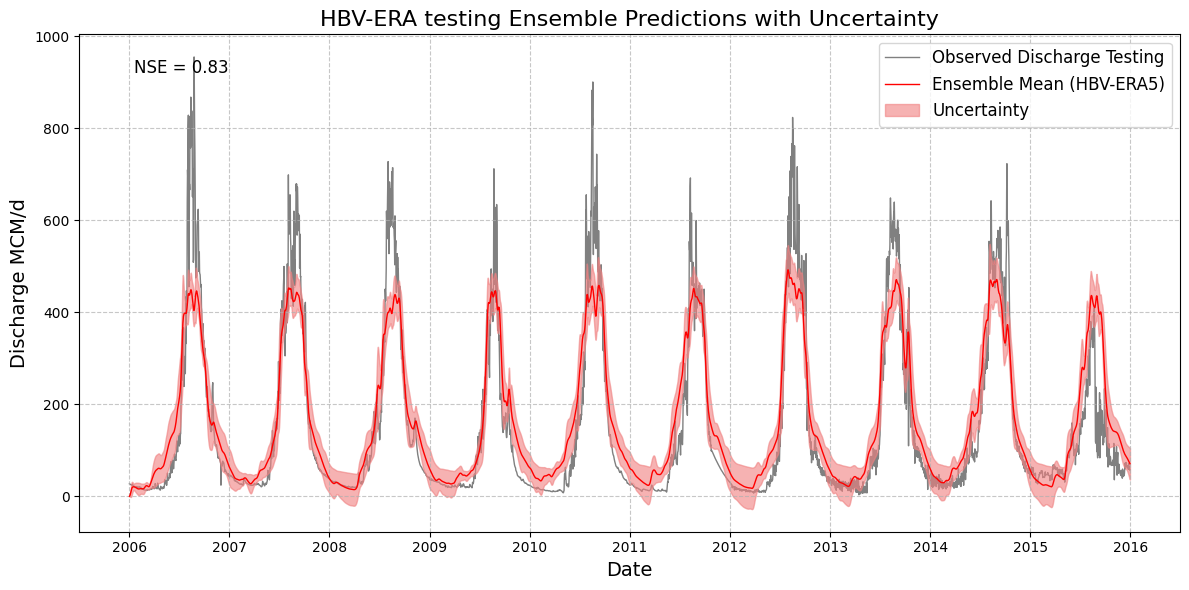

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the conversion factor
conversion_factor = 176000 / 1000

# Assuming 'hbv_chirps_results_testing' is your DataFrame
# Extract relevant columns and apply the conversion factor
hbv_era_results_testing['Date'] = pd.to_datetime(hbv_chirps_results_testing['Date'])
qobs = hbv_era_results_testing['Qobs'] * conversion_factor
qsims = hbv_era_results_testing[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                    'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']] * conversion_factor

# Calculate ensemble mean and standard deviation
ensemble_mean = qsims.mean(axis=1)
ensemble_std = qsims.std(axis=1)

# Calculate NSE
def nse(observed, simulated):
    return 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

nse_era_test_mean = nse(qobs, ensemble_mean)

# Plotting
plt.figure(figsize=(12, 6))

# Observed discharge
plt.plot(hbv_era_results_testing['Date'], qobs, label="Observed Discharge Testing", color='gray', linewidth=1, zorder=1)

# Ensemble mean
plt.plot(hbv_era_results_testing['Date'], ensemble_mean, label="Ensemble Mean (HBV-ERA5)", color='red', linewidth=1)

# 95% prediction interval
plt.fill_between(hbv_era_results_testing['Date'],
                 ensemble_mean - 2 * ensemble_std,
                 ensemble_mean + 2 * ensemble_std,
                 color='lightcoral', alpha=0.6, label="Uncertainty")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Discharge MCM/d", fontsize=14)  # Adjust units as needed
plt.title("HBV-ERA testing Ensemble Predictions with Uncertainty", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display NSE value on the plot
plt.text(0.05, 0.95, f"NSE = {nse_era_test_mean:.2f}", transform=plt.gca().transAxes, fontsize=12, va='top')

plt.tight_layout()
plt.show()


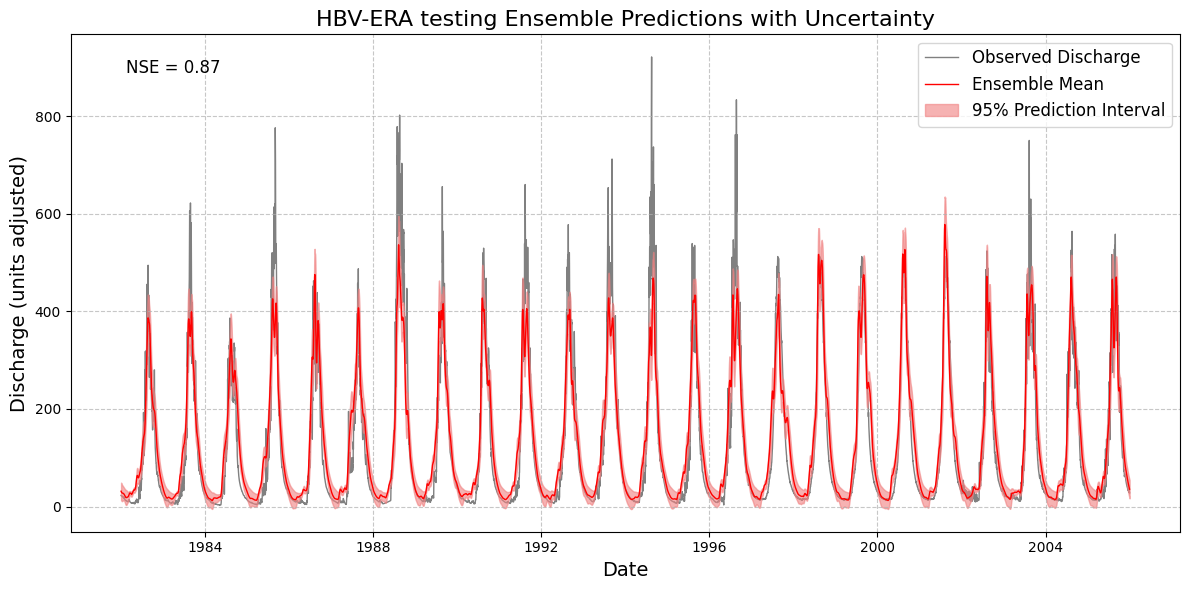

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Define the conversion factor
conversion_factor = 176000 / 1000

# Assuming 'hbv_chirps_results_testing' is your DataFrame
# Extract relevant columns and apply the conversion factor
hbv_era_results_calibration['Date'] = pd.to_datetime(hbv_era_results_calibration['Date'])
qobs = hbv_era_results_calibration['Qobs'] * conversion_factor
qsims = hbv_era_results_calibration[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                    'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']] * conversion_factor

# Calculate ensemble mean and standard deviation
ensemble_mean = qsims.mean(axis=1)
ensemble_std = qsims.std(axis=1)

# Calculate NSE
def nse(observed, simulated):
    return 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

nse_era_cal_mean = nse(qobs, ensemble_mean)

# Plotting
plt.figure(figsize=(12, 6))

# Observed discharge
plt.plot(hbv_era_results_calibration['Date'], qobs, label="Observed Discharge", color='gray', linewidth=1, zorder=1)

# Ensemble mean
plt.plot(hbv_era_results_calibration['Date'], ensemble_mean, label="Ensemble Mean", color='red', linewidth=1)

# 95% prediction interval
plt.fill_between(hbv_era_results_calibration['Date'],
                 ensemble_mean - 2 * ensemble_std,
                 ensemble_mean + 2 * ensemble_std,
                 color='lightcoral', alpha=0.6, label="95% Prediction Interval")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Discharge (units adjusted)", fontsize=14)  # Adjust units as needed
plt.title("HBV-ERA testing Ensemble Predictions with Uncertainty", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display NSE value on the plot
plt.text(0.05, 0.95, f"NSE = {nse_era_cal_mean:.2f}", transform=plt.gca().transAxes, fontsize=12, va='top')

plt.tight_layout()
plt.show()


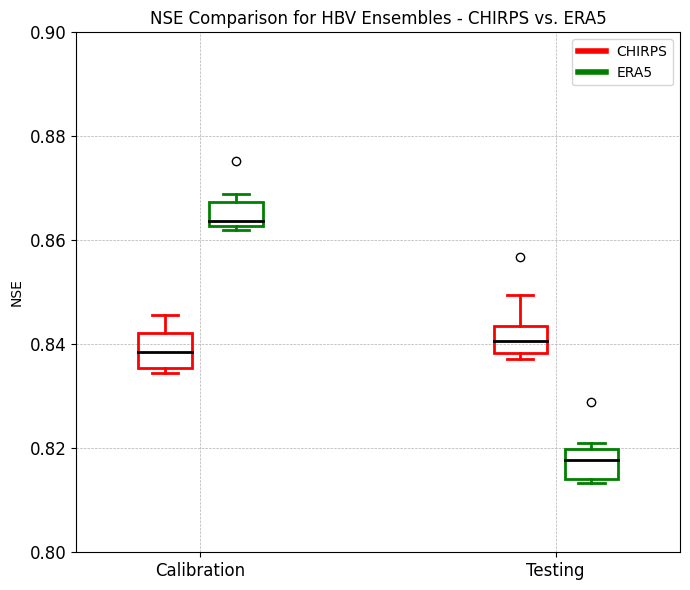

In [25]:
import matplotlib.pyplot as plt

# Define NSE values for each ensemble and product
nse_values = {
    'Calibration': {
        'CHIRPS': [nse(hbv_chirps_results_calibration['Qobs'], hbv_chirps_results_calibration[f'Qsim{i}']) for i in range(1, 11)],
        'ERA5': [nse(hbv_era_results_calibration['Qobs'], hbv_era_results_calibration[f'Qsim{i}']) for i in range(1, 11)]
    },
    'Testing': {
        'CHIRPS': [nse(hbv_chirps_results_testing['Qobs'], hbv_chirps_results_testing[f'Qsim{i}']) for i in range(1, 11)],
        'ERA5': [nse(hbv_era_results_testing['Qobs'], hbv_era_results_testing[f'Qsim{i}']) for i in range(1, 11)]
    }
}


# Setup for box plot visualization
plt.figure(figsize=(7, 6))
box_width = 0.3  # Width of the box plots
spacing = 0.1  # Minimal space between boxes to make them side-by-side

# Define positions for the box plots to make them centered on the axis ticks
mid_points = [1, 3]  # Mid points for Calibration and Testing
positions = [
    mid_points[0] - (box_width + spacing) / 2, mid_points[0] + (box_width + spacing) / 2,
    mid_points[1] - (box_width + spacing) / 2, mid_points[1] + (box_width + spacing) / 2
]

colors = ['red', 'green']  # Colors for CHIRPS and ERA5

# Loop to plot each product for both calibration and testing with hollow boxes
for i, period in enumerate(['Calibration', 'Testing']):
    for j, product in enumerate(['CHIRPS', 'ERA5']):
        bp = plt.boxplot(nse_values[period][product],
                         positions=[positions[i * 2 + j]],
                         widths=box_width,
                         patch_artist=True,
                         notch=False,  # Optional: add notch to indicate median confidence interval
                         boxprops=dict(facecolor='none', color=colors[j], linewidth=2),
                         whiskerprops=dict(color=colors[j], linewidth=2),
                         capprops=dict(color=colors[j], linewidth=2),
                         medianprops=dict(color='black', linewidth=2))

# Formatting the plot
plt.xticks(mid_points, ['Calibration', 'Testing'], fontsize=50)

plt.ylabel('NSE')
plt.ylim(0.8, 0.9)
plt.title('NSE Comparison for HBV Ensembles - CHIRPS vs. ERA5')
plt.legend([plt.Line2D([0], [0], color=colors[k], lw=4) for k in range(2)], ['CHIRPS', 'ERA5'], loc='upper right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.8)  # Adds a horizontal line at y=0 for reference
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()


In [26]:
# prompt: # prompt: calculate all the metrics for the HBV CHIRPS and ERA5 for all the 10 ensemble member and put them into a dictionari and savi metrics_hbv to the output folder, the functions are defined do define them agin, do it in this fashion metrics_hbv_ens['CHIRPS']['Calibration'][metric][1-10ens]



# Initialize the dictionary to store metrics
metrics_hbv_ens = {
    'CHIRPS': {
        'Calibration': {'nse': [], 'kge': [], 'pbias': [], 'rmse': [], 'mse': [], 'r2': []},
        'Testing': {'nse': [], 'kge': [], 'pbias': [], 'rmse': [], 'mse': [], 'r2': []}
    },
    'ERA5': {
        'Calibration': {'nse': [], 'kge': [], 'pbias': [], 'rmse': [], 'mse': [], 'r2': []},
        'Testing': {'nse': [], 'kge': [], 'pbias': [], 'rmse': [], 'mse': [], 'r2': []}
    }
}

# Calculate metrics for each ensemble member
for product in ['CHIRPS', 'ERA5']:
    for period in ['Calibration', 'Testing']:
        df = hbv_chirps_results_calibration if product == 'CHIRPS' and period == 'Calibration' else \
             hbv_chirps_results_testing if product == 'CHIRPS' and period == 'Testing' else \
             hbv_era_results_calibration if product == 'ERA5' and period == 'Calibration' else \
             hbv_era_results_testing
        qobs = df['Qobs']
        for i in range(1, 11):
            qsim = df[f'Qsim{i}']
            metrics_hbv_ens[product][period]['nse'].append(nse(qobs, qsim))
            metrics_hbv_ens[product][period]['kge'].append(kge(qobs*conversion_factor, qsim*conversion_factor))
            metrics_hbv_ens[product][period]['pbias'].append(pbias(qobs*conversion_factor, qsim*conversion_factor))
            metrics_hbv_ens[product][period]['rmse'].append(rmse(qobs*conversion_factor, qsim*conversion_factor))
            metrics_hbv_ens[product][period]['mse'].append(mse(qobs*conversion_factor, qsim*conversion_factor))
            metrics_hbv_ens[product][period]['r2'].append(r2(qobs, qsim))

# Save the metrics to a pickle file
metrics_file_path = os.path.join(dir_output, 'metrics_hbv_ensemble.pkl')
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics_hbv_ens, f)

print(f"HBV metrics saved to: {metrics_file_path}")


HBV metrics saved to: /content/drive/My Drive/Colab Notebooks/HBV_LSTM_UBNB/output/metrics_hbv_ensemble.pkl


[69.42050407344992,
 71.15196691388313,
 72.54243726098878,
 72.5568341112012,
 72.98485752313827,
 73.4947981650614,
 73.73978145421394,
 73.7628008428442,
 73.88748358956106,
 74.00355061114723]

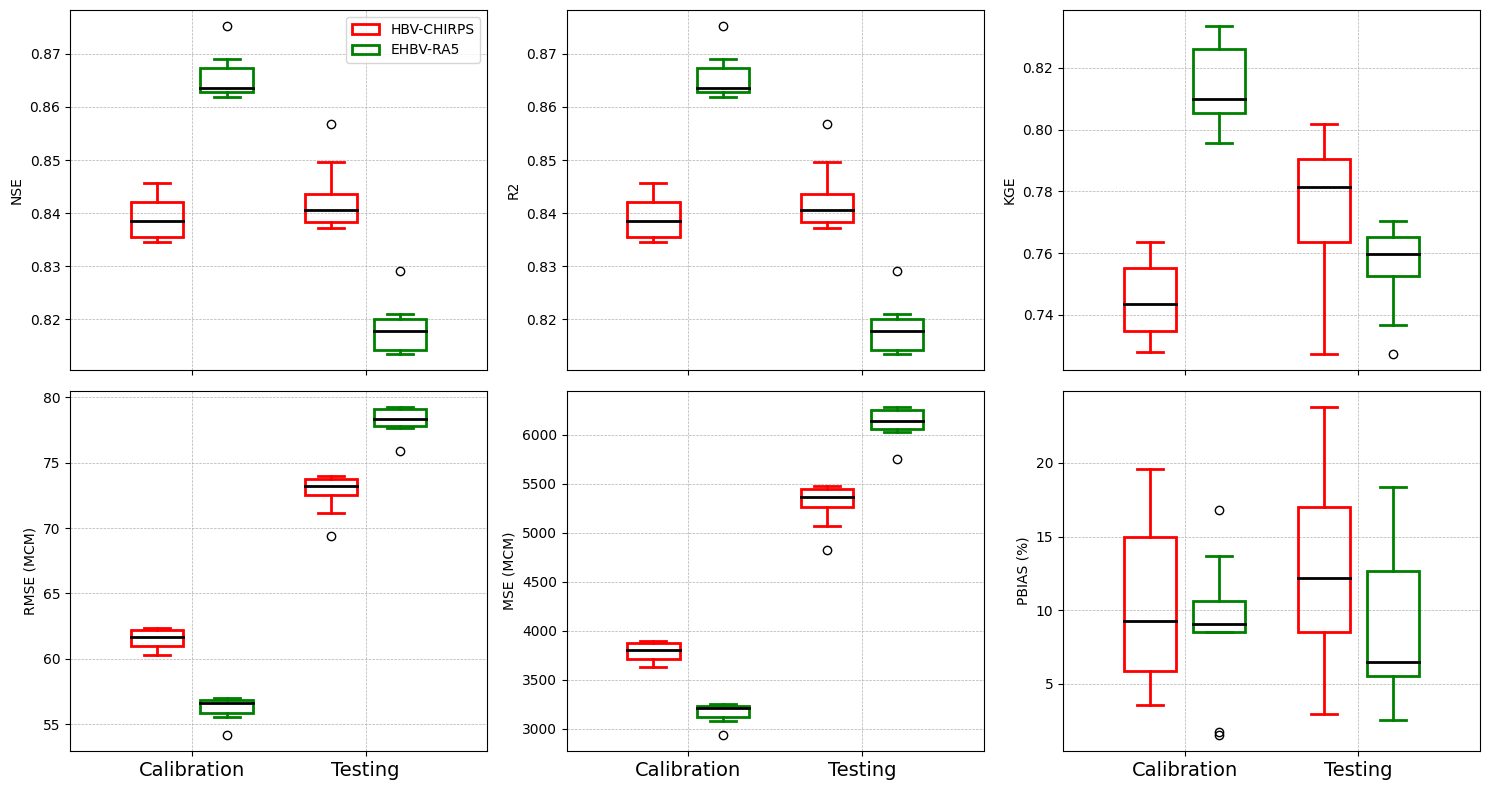

In [27]:
# prompt: read metrics hbv ensemble and plot the all the metrics for calibration and testing in one figure but differnt subplots , x axis just calibration and testing and teh boxes for the tow products centered around the axis

import pickle
import matplotlib.pyplot as plt

# Load the metrics from the pickle file
metrics_file_path = os.path.join(dir_output, 'metrics_hbv_ensemble.pkl')
with open(metrics_file_path, 'rb') as f:
    metrics_hbv_ens = pickle.load(f)

# Define the metrics to plot
metrics_to_plot = ['nse', 'r2', 'kge',  'rmse', 'mse', 'pbias']
metric_labels = {'nse': 'NSE', 'r2': 'R2', 'kge': 'KGE',
                 'rmse': 'RMSE (MCM)', 'mse': 'MSE (MCM)', 'pbias': 'PBIAS (%)'}

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Colors for the outlines of the box plots for CHIRPS and ERA5
colors = ['red', 'green']

# Box plot settings
box_width = 0.3
spacing = 0.1
mid_points = [1, 2]  # Mid points for Calibration and Testing
positions = [
    mid_points[0] - (box_width + spacing) / 2, mid_points[0] + (box_width + spacing) / 2,
    mid_points[1] - (box_width + spacing) / 2, mid_points[1] + (box_width + spacing) / 2
]

# Iterate over metrics and plot
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]

    # Extract data for the current metric
    data_chirps_cal = metrics_hbv_ens['CHIRPS']['Calibration'][metric]
    data_chirps_test = metrics_hbv_ens['CHIRPS']['Testing'][metric]
    data_era5_cal = metrics_hbv_ens['ERA5']['Calibration'][metric]
    data_era5_test = metrics_hbv_ens['ERA5']['Testing'][metric]

    # Create box plots
    bp_chirps_cal = ax.boxplot(data_chirps_cal, positions=[positions[0]], widths=box_width, patch_artist=True, notch=False,
                               boxprops=dict(facecolor='none', color=colors[0], linewidth=2),
                               whiskerprops=dict(color=colors[0], linewidth=2),
                               capprops=dict(color=colors[0], linewidth=2),
                               medianprops=dict(color='black', linewidth=2))
    bp_chirps_test = ax.boxplot(data_chirps_test, positions=[positions[2]], widths=box_width, patch_artist=True, notch=False,
                                boxprops=dict(facecolor='none', color=colors[0], linewidth=2),
                                whiskerprops=dict(color=colors[0], linewidth=2),
                                capprops=dict(color=colors[0], linewidth=2),
                                medianprops=dict(color='black', linewidth=2))
    bp_era5_cal = ax.boxplot(data_era5_cal, positions=[positions[1]], widths=box_width, patch_artist=True, notch=False,
                              boxprops=dict(facecolor='none', color=colors[1], linewidth=2),
                              whiskerprops=dict(color=colors[1], linewidth=2),
                              capprops=dict(color=colors[1], linewidth=2),
                              medianprops=dict(color='black', linewidth=2))
    bp_era5_test = ax.boxplot(data_era5_test, positions=[positions[3]], widths=box_width, patch_artist=True, notch=False,
                              boxprops=dict(facecolor='none', color=colors[1], linewidth=2),
                              whiskerprops=dict(color=colors[1], linewidth=2),
                              capprops=dict(color=colors[1], linewidth=2),
                              medianprops=dict(color='black', linewidth=2))

    # Set labels and title
    ax.set_ylabel(metric_labels[metric])
    if i>=3: ax.set_xticks(mid_points, ['Calibration', 'Testing'],fontsize=14)
    else: ax.set_xticks(mid_points, ['', ''])

    ax.grid(True, linestyle='--', linewidth=0.5)

    # Add legend
    if i == 0:
        ax.legend([bp_chirps_cal["boxes"][0], bp_era5_cal["boxes"][0]], ['HBV-CHIRPS', 'EHBV-RA5'], loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [ ]:
np.mean(metrics_hbv_ens['CHIRPS'] ['Testing'] ['mse'])

5295.137483787758

In [ ]:
# # prompt: save the nse values for the tow products for calibration and testing including the ensembles, make sure to save it into the output folder

# import pickle

# # Assuming 'dir_output' is defined as the output directory path
# output_filename = os.path.join(dir_output, 'hbv_nse_values.pkl')

# # Save the nse_values dictionary to a pickle file
# with open(output_filename, 'wb') as f:
#     pickle.dump(nse_values, f)

# print(f"NSE values saved to: {output_filename}")


NSE values saved to: /content/drive/My Drive/Colab Notebooks/HBV_LSTM_UBNB/output/hbv_nse_values.pkl


{'nse': {1: [0.8806989635315446, 0.9059860713537762, 0.8690999797565072, 0.8846160832299479, 0.8400917838239277, 0.8733713176073603, 0.8489023033143022, 0.8845148633878831, 0.8653288716094626, 0.896038871884563], 2: [0.8845412297120345, 0.9076682627996802, 0.8688394305958278, 0.8799741214823256, 0.8390462569903159, 0.8759746678568543, 0.8545397670921857, 0.8870259227305534, 0.8654619325047768, 0.8977685128961634], 3: [0.8847830887038017, 0.9048134547510244, 0.865562712118193, 0.873905420092717, 0.8353812723744237, 0.8734302695323415, 0.8545729639502115, 0.8862666302960672, 0.8638315612022393, 0.8956792661166845], 4: [0.8817157710334708, 0.8987442804304913, 0.8602521622437027, 0.8659282874032931, 0.8320777063997513, 0.8676955177303151, 0.8512546678176119, 0.8829514045540111, 0.8598411710633603, 0.8907700365017566], 5: [0.8776780632111207, 0.8915522769151321, 0.854860621349708, 0.8582851349627145, 0.8307790612336943, 0.861171010643788, 0.8472475201795344, 0.879212186756323, 0.85558184212

{'nse': {1: [0.8806989635315446, 0.9059860713537762, 0.8690999797565072, 0.8846160832299479, 0.8400917838239277, 0.8733713176073603, 0.8489023033143022, 0.8845148633878831, 0.8653288716094626, 0.896038871884563], 2: [0.8845412297120345, 0.9076682627996802, 0.8688394305958278, 0.8799741214823256, 0.8390462569903159, 0.8759746678568543, 0.8545397670921857, 0.8870259227305534, 0.8654619325047768, 0.8977685128961634], 3: [0.8847830887038017, 0.9048134547510244, 0.865562712118193, 0.873905420092717, 0.8353812723744237, 0.8734302695323415, 0.8545729639502115, 0.8862666302960672, 0.8638315612022393, 0.8956792661166845], 4: [0.8817157710334708, 0.8987442804304913, 0.8602521622437027, 0.8659282874032931, 0.8320777063997513, 0.8676955177303151, 0.8512546678176119, 0.8829514045540111, 0.8598411710633603, 0.8907700365017566], 5: [0.8776780632111207, 0.8915522769151321, 0.854860621349708, 0.8582851349627145, 0.8307790612336943, 0.861171010643788, 0.8472475201795344, 0.879212186756323, 0.85558184212

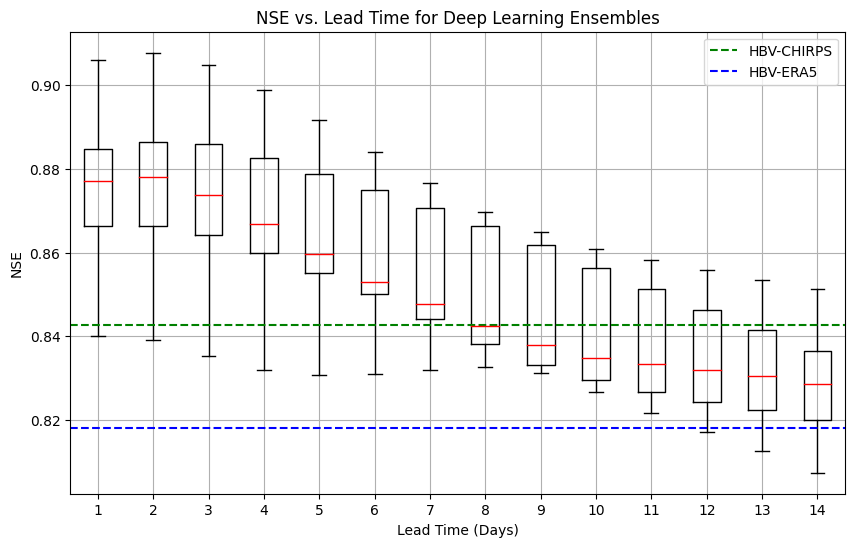

In [ ]:
# prompt: show the NSE box plots for the deep ealrning model and make a line along the NSE of teh mean hbv chirps model to benchmark the deep learning

# Calculate NSE for each model and lead time (assuming this is already done)
# ... (Your existing code for calculating NSE values)

# prompt: read the lstm metrics

# Assuming 'dir_output' is the same as before
results_file_path = os.path.join(dir_output, 'lstm_metrics.pkl')

# Load the metrics from the pickle file
with open(results_file_path, 'rb') as f:
    lstm_metrics = pickle.load(f)

# Now you can access the loaded metrics
print(lstm_metrics)  # Print the top-level keys of the dictionary
nse_list_lstm = [lstm_metrics['nse'][key] for key in lstm_metrics['nse']]


# Create box plot for NSE vs. lead time for deep learning models
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(nse_list_lstm, labels=lead_times,
                      boxprops=dict(color='black'),
                      whiskerprops=dict(color='black'),
                      capprops=dict(color='black'),
                      medianprops=dict(color='red'))
plt.xlabel('Lead Time (Days)')
plt.ylabel('NSE')
plt.title('NSE vs. Lead Time for Deep Learning Ensembles')

# Add a horizontal line for the mean NSE of HBV-CHIRPS

plt.axhline(y= np.mean(metrics_hbv_ens['CHIRPS']['Testing']['nse']), color='green', linestyle='--', label='HBV-CHIRPS')
plt.axhline(y=np.mean(metrics_hbv_ens['ERA5']['Testing']['nse']), color='blue', linestyle='--', label='HBV-ERA5')
plt.grid(True)
plt.legend()
plt.show()


### performance for different flow regimes

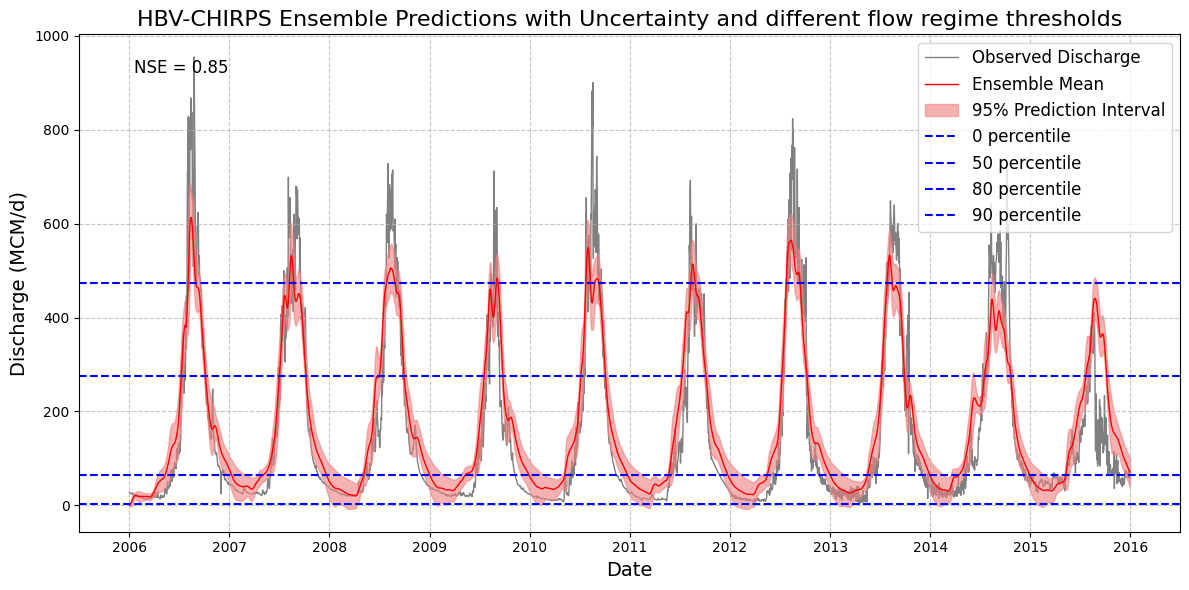

In [28]:
# prompt: # prompt: ok lets go with chirps testing plot it with 2-10 return periods line, apply the conversatoin factor

# Define the conversion factor
conversion_factor = 176000 / 1000

# Assuming 'hbv_chirps_results_testing' is your DataFrame
# Extract relevant columns and apply the conversion factor
hbv_chirps_results_testing['Date'] = pd.to_datetime(hbv_chirps_results_testing['Date'])
qobs = hbv_chirps_results_testing['Qobs'] * conversion_factor
qsims = hbv_chirps_results_testing[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                    'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']] * conversion_factor

# Calculate ensemble mean and standard deviation
ensemble_mean = qsims.mean(axis=1)
ensemble_std = qsims.std(axis=1)

# Calculate NSE
def nse(observed, simulated):
    return 1 - (np.sum((observed - simulated) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

nse_chirps_mean = nse(qobs, ensemble_mean)

# Plotting
plt.figure(figsize=(12, 6))

# Observed discharge
plt.plot(hbv_chirps_results_testing['Date'], qobs, label="Observed Discharge", color='gray', linewidth=1, zorder=1)

# Ensemble mean
plt.plot(hbv_chirps_results_testing['Date'], ensemble_mean, label="Ensemble Mean", color='red', linewidth=1)

# 95% prediction interval
plt.fill_between(hbv_chirps_results_testing['Date'],
                 ensemble_mean - 2 * ensemble_std,
                 ensemble_mean + 2 * ensemble_std,
                 color='lightcoral', alpha=0.6, label="95% Prediction Interval")

# Calculate and plot return periods

for rp in return_periods:
    threshold = np.percentile(qobs, 100 - (100 / rp))
    plt.axhline(y=threshold, color='blue', linestyle='--', label=f"{int(100-(1/rp)*100)} percentile")

plt.xlabel("Date", fontsize=14)
plt.ylabel("Discharge (MCM/d)", fontsize=14)  # Adjust units as needed
plt.title("HBV-CHIRPS Ensemble Predictions with Uncertainty and different flow regime thresholds", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display NSE value on the plot
plt.text(0.05, 0.95, f"NSE = {nse_chirps_mean:.2f}", transform=plt.gca().transAxes, fontsize=12, va='top')

plt.tight_layout()
plt.show()


In [29]:
# prompt: for each of the threasholds calcluate the nuber of events observed above it and below the next one, for the last one just calculate every thing above it

# Calculate return period thresholds
#return_periods = [1, 2, 5, 7, 10]
thresholds = {}
for rp in return_periods:
    thresholds[rp] = np.percentile(qobs, 100 - (100 / rp))

# Calculate events above each threshold but less than the next one
event_counts = {}
event_indices = {}
sorted_thresholds = sorted(thresholds.values())

for i in range(len(sorted_thresholds) - 1):
    lower_threshold = sorted_thresholds[i]
    upper_threshold = sorted_thresholds[i + 1]

    event_indices[i] = np.where((qobs > lower_threshold) & (qobs <= upper_threshold))[0]
    event_counts[i] = len(event_indices[i])

# Events above the last threshold
last_threshold = sorted_thresholds[-1]
event_indices[len(sorted_thresholds) - 1] = np.where(qobs > last_threshold)[0]
event_counts[len(sorted_thresholds) - 1] = len(event_indices[len(sorted_thresholds) - 1])

# Print the counts and indices
for i, count in event_counts.items():
    print(f"Events above threshold {i+1} but below threshold {i+2 if i < len(event_counts) - 1 else 'end'}: {count}")
    # print(f"Indices: {event_indices[i]}")


Events above threshold 1 but below threshold 2: 1827
Events above threshold 2 but below threshold 3: 1096
Events above threshold 3 but below threshold 4: 364
Events above threshold 4 but below threshold end: 364


In [30]:
# prompt: find the indexces of thsose events

# Calculate return period thresholds
#return_periods = [1, 2, 5, 7, 10]
thresholds = {}
for rp in return_periods:
    thresholds[rp] = np.percentile(qobs, 100 - (100 / rp))

# Calculate events above each threshold but less than the next one
event_counts = {}
event_indices = {}
sorted_thresholds = sorted(thresholds.values())

for i in range(len(sorted_thresholds) - 1):
    lower_threshold = sorted_thresholds[i]
    upper_threshold = sorted_thresholds[i + 1]

    event_indices[i] = np.where((qobs > lower_threshold) & (qobs <= upper_threshold))[0]
    event_counts[i] = len(event_indices[i])

# Events above the last threshold
last_threshold = sorted_thresholds[-1]
event_indices[len(sorted_thresholds) - 1] = np.where(qobs > last_threshold)[0]
event_counts[len(sorted_thresholds) - 1] = len(event_indices[len(sorted_thresholds) - 1])

# Print the counts and indices
for i, count in event_counts.items():
    print(f"Events above threshold {i+1} but below threshold {i+2 if i < len(event_counts) - 1 else 'end'}: {count}")
    print(f"Indices: {event_indices[i]}") # Print the indices for each event category


Events above threshold 1 but below threshold 2: 1827
Indices: [   0    1    2 ... 3649 3650 3651]
Events above threshold 2 but below threshold 3: 1096
Indices: [ 152  155  157 ... 3643 3644 3646]
Events above threshold 3 but below threshold 4: 364
Indices: [ 190  193  194  195  196  197  198  202  203  205  206  207  208  209
  210  217  259  260  261  262  263  264  265  266  267  268  269  270
  271  272  273  274  275  276  277  544  551  552  553  554  555  556
  557  558  559  560  561  562  565  566  567  568  569  570  571  572
  573  574  575  577  578  590  591  592  594  597  598  599  604  626
  627  628  629  630  631  632  633  634  635  636  637  638  639  640
  641  642  643  644  925  926  929  930  931  932  933  934  935  936
  973  974  975  976  978  982  983  984  985  986  987  988  989  990
  991  992  993  994  995  996  997  999 1000 1001 1303 1304 1305 1306
 1307 1308 1309 1310 1311 1312 1313 1315 1316 1317 1318 1319 1321 1322
 1323 1324 1325 1326 1327 1328 13

(364,)

In [ ]:
# prompt: calculate all the metrics by return periods and put them in a dictionary for chirps and ERA calibration and testing , for the ensemble mebers 10 values each





# Initialize dictionary to store metrics
metrics_by_return_period = {
    'CHIRPS': {
        'Calibration': {rp: {'nse': [], 'kge': [], 'pbias': [], 'rmse': [], 'mse': [], 'r2': []} for rp in return_periods},
        'Testing': {rp: {'nse': [], 'kge': [], 'pbias': [], 'rmse': [], 'mse': [], 'r2': []} for rp in return_periods}
    },
    'ERA5': {
        'Calibration': {rp: {'nse': [], 'kge': [], 'pbias': [], 'rmse': [], 'mse': [], 'r2': []} for rp in return_periods},
        'Testing': {rp: {'nse': [], 'kge': [], 'pbias': [], 'rmse': [], 'mse': [], 'r2': []} for rp in return_periods}
    }
}

# Calculate metrics for each product, period, return period, and ensemble member
for product in ['CHIRPS', 'ERA5']:
    for period in ['Calibration', 'Testing']:
        df = hbv_chirps_results_calibration if product == 'CHIRPS' and period == 'Calibration' else \
             hbv_chirps_results_testing if product == 'CHIRPS' and period == 'Testing' else \
             hbv_era_results_calibration if product == 'ERA5' and period == 'Calibration' else \
             hbv_era_results_testing
        qobs = df['Qobs'] * conversion_factor
        for ii,rp in enumerate(return_periods):
            threshold = np.percentile(qobs, 100 - (100 / rp))
            #event_indices = np.where(qobs >= threshold)[0]
            qobs_rp = qobs[event_indices[ii]]
            for i in range(1, 11):
                qsim = df[f'Qsim{i}'] * conversion_factor
                qsim_rp = qsim[event_indices[ii]]
                metrics_by_return_period[product][period][rp]['nse'].append(nse(qobs_rp, qsim_rp))
                metrics_by_return_period[product][period][rp]['kge'].append(kge(qobs_rp, qsim_rp))
                metrics_by_return_period[product][period][rp]['pbias'].append(pbias(qobs_rp, qsim_rp))
                metrics_by_return_period[product][period][rp]['rmse'].append(rmse(qobs_rp, qsim_rp))
                metrics_by_return_period[product][period][rp]['mse'].append(mse(qobs_rp, qsim_rp))
                metrics_by_return_period[product][period][rp]['r2'].append(r2(qobs_rp, qsim_rp))

# Print or save the results as needed
print(metrics_by_return_period)


{'CHIRPS': {'Calibration': {1: {'nse': [-4.114794277896771, -2.5630242949596984, -1.8052706103623568, -2.29499417925432, -2.15553377058607, -3.516922435403588, -3.827265377144065, -3.8328110922311387, -2.8846430208247034, -3.2525191721553055], 'kge': [-0.7716640614605703, -0.3865628348115684, -0.26708558206210253, -0.35438558217633864, -0.3284206655981956, -0.5374929028744142, -0.6885424704561509, -0.7118407644680951, -0.45341000305770596, -0.5155512552467212], 'pbias': [153.84045779498322, 120.65467731660702, 121.59988674910025, 121.1419828708014, 119.61527362615222, 118.02159389751883, 150.591028133048, 147.0568377953099, 127.80690721593352, 128.4662670216647], 'rmse': [32.94952495504297, 27.500745316665245, 24.401833145491896, 26.446146422947404, 25.88043003900498, 30.963952227409933, 32.00999892825636, 32.028380699790056, 28.715119635716068, 30.04403176029797], 'mse': [1085.6711947629994, 756.2909929720855, 595.4494608604269, 699.3986606239738, 669.7966590038315, 958.7663375413246,

NSE: -5.02008447813548


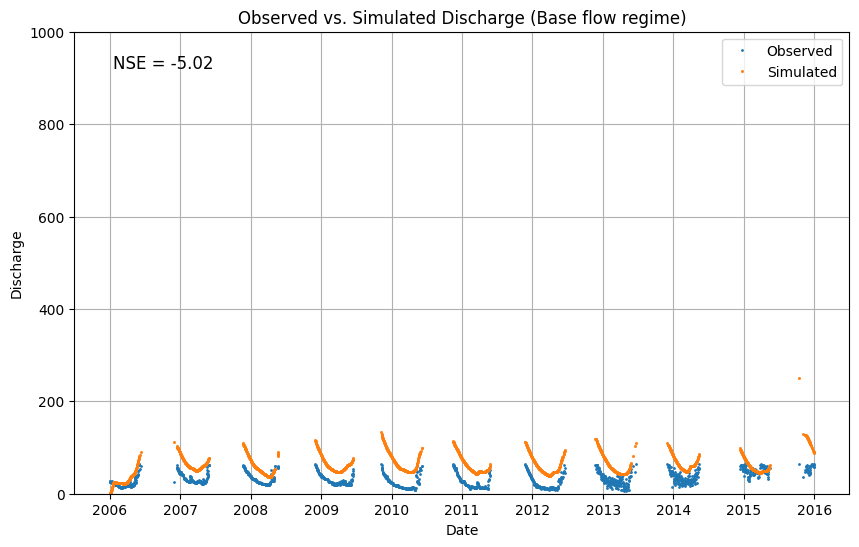

In [32]:
# prompt: xx=0
# print(nse(hbv_chirps_results_calibration['Qobs'][event_indices[xx]], hbv_chirps_results_calibration['Qsim4'][event_indices[xx]])):::: plt the two time series as markesr no lines  and shwo the nse values
ii=1
xx = 0
nse_value = nse(hbv_chirps_results_testing['Qobs'][event_indices[xx]],
                 hbv_chirps_results_testing[f'Qsim{ii}'][event_indices[xx]])
print(f"NSE: {nse_value}")

plt.figure(figsize=(10, 6))
plt.plot(hbv_chirps_results_testing['Date'][event_indices[xx]],
         hbv_chirps_results_testing['Qobs'][event_indices[xx]]*conversion_factor,
         'o', markersize=1, label='Observed')
plt.plot(hbv_chirps_results_testing['Date'][event_indices[xx]],
         hbv_chirps_results_testing[f'Qsim{ii}'][event_indices[xx]]*conversion_factor,
         's', markersize=1, label='Simulated')

plt.xlabel('Date')
plt.ylim(0,1000)
plt.ylabel('Discharge')
plt.title(f'Observed vs. Simulated Discharge (Base flow regime)')
plt.legend()
plt.grid(True)
plt.text(0.05, 0.95, f"NSE = {nse_value:.2f}", transform=plt.gca().transAxes, fontsize=12, va='top')
plt.show()


In [ ]:
# prompt: metrics_by_return_period save to teh output folder hbv_metrics_by_return_period

# Save the metrics to a pickle file
metrics_file_path = os.path.join(dir_output, 'hbv_metrics_by_return_period.pkl')
with open(metrics_file_path, 'wb') as f:
    pickle.dump(metrics_by_return_period, f)

print(f"HBV metrics by return period saved to: {metrics_file_path}")


HBV metrics by return period saved to: /content/drive/My Drive/Colab Notebooks/HBV_LSTM_UBNB/output/hbv_metrics_by_return_period.pkl


In [ ]:
# prompt: read it

# Load the metrics from the pickle file
metrics_file_path = os.path.join(dir_output, 'hbv_metrics_by_return_period.pkl')
with open(metrics_file_path, 'rb') as f:
    hbv_metrics_by_return_period = pickle.load(f)

# Now you can access and use the loaded metrics
print(hbv_metrics_by_return_period)


{'CHIRPS': {'Calibration': {1: {'nse': [-4.114794277896771, -2.5630242949596984, -1.8052706103623568, -2.29499417925432, -2.15553377058607, -3.516922435403588, -3.827265377144065, -3.8328110922311387, -2.8846430208247034, -3.2525191721553055], 'kge': [-0.7716640614605703, -0.3865628348115684, -0.26708558206210253, -0.35438558217633864, -0.3284206655981956, -0.5374929028744142, -0.6885424704561509, -0.7118407644680951, -0.45341000305770596, -0.5155512552467212], 'pbias': [153.84045779498322, 120.65467731660702, 121.59988674910025, 121.1419828708014, 119.61527362615222, 118.02159389751883, 150.591028133048, 147.0568377953099, 127.80690721593352, 128.4662670216647], 'rmse': [32.94952495504297, 27.500745316665245, 24.401833145491896, 26.446146422947404, 25.88043003900498, 30.963952227409933, 32.00999892825636, 32.028380699790056, 28.715119635716068, 30.04403176029797], 'mse': [1085.6711947629994, 756.2909929720855, 595.4494608604269, 699.3986606239738, 669.7966590038315, 958.7663375413246,

In [ ]:
# prompt: make a table reproting all the metrics for all the rerturn period groups

import pandas as pd

# Assuming 'hbv_metrics_by_return_period' is already loaded

# Create a multi-index for the DataFrame
index_tuples = []
for product in ['CHIRPS', 'ERA5']:
    for period in ['Calibration', 'Testing']:
        for rp in return_periods:
            index_tuples.append((product, period, rp))

index = pd.MultiIndex.from_tuples(index_tuples, names=['Product', 'Period', 'Return Period'])

# Create a list to store data for each metric
data = {
    'NSE': [],
    'KGE': [],
    'PBIAS': [],
    'RMSE': [],
    'MSE': [],
    'R2': []
}

# Extract data from the dictionary and calculate mean values
for product in ['CHIRPS', 'ERA5']:
    for period in ['Calibration', 'Testing']:
        for rp in return_periods:
            for metric in ['nse', 'kge', 'pbias', 'rmse', 'mse', 'r2']:
                values = hbv_metrics_by_return_period[product][period][rp][metric]
                mean_value = np.mean(values)
                data[metric.upper()].append(mean_value)

# Create the DataFrame
df_metrics = pd.DataFrame(data, index=index)

# Display the table
df_metrics

# Optionally, save the table to an Excel file
# df_metrics.to_excel(os.path.join(dir_output, 'hbv_metrics_table.xlsx'))


NSE       KGE       PBIAS        RMSE  \
Product Period      Return Period                                               
CHIRPS  Calibration 1             -3.024778 -0.501496  130.879491   29.094016   
                    2              0.606534  0.543832   29.008035   62.681455   
                    5              0.520642  0.467458   -8.644317   91.871783   
                    10             0.183019  0.286082  -14.822242  124.642385   
        Testing     1             -4.299876 -0.325372   77.238380   33.405095   
                    2             -1.223085  0.298460   46.543721   83.037126   
                    5             -0.242938  0.500421    1.488263   64.238852   
                    10            -1.720071  0.234279  -19.932018  148.305500   
ERA5    Calibration 1             -1.196925 -0.051470   90.141144   21.517652   
                    2              0.648194  0.625338   25.334162   59.464013   
                    5              0.577105  0.548195   -4.792168   86.278330   
                    10             0.322076  0.368116   -8.352160  113.667900   
        Testing     1             -4.839175 -0.433093   75.721769   35.296267   
                    2             -1.032994  0.306839   42.178003   79.416442   
                    5              0.014361  0.461449    1.114893   57.369081   
                    10            -2.985616 -0.190517  -26.090372  180.128658   

                                            MSE        R2  
Product Period      Return Period                          
CHIRPS  Calibration 1                854.303245 -3.024778  
                    2               3959.730665  0.606534  
                    5               8451.464591  0.520642  
                    10             15590.819292  0.183019  
        Testing     1               1150.434702 -4.299876  
                    2               6942.135811 -1.223085  
                    5               4175.369124 -0.242938  
                    10             22270.867524 -1.720071  
ERA5    Calibration 1                466.739343 -1.196925  
                    2               3540.550561  0.648194  
                    5               7456.455491  0.577105  
                    10             12937.956466  0.322076  
        Testing     1               1267.499491 -4.839175  
                    2               6348.527198 -1.032994  
                    5               3311.031550  0.014361  
                    10             32632.644467 -2.985616

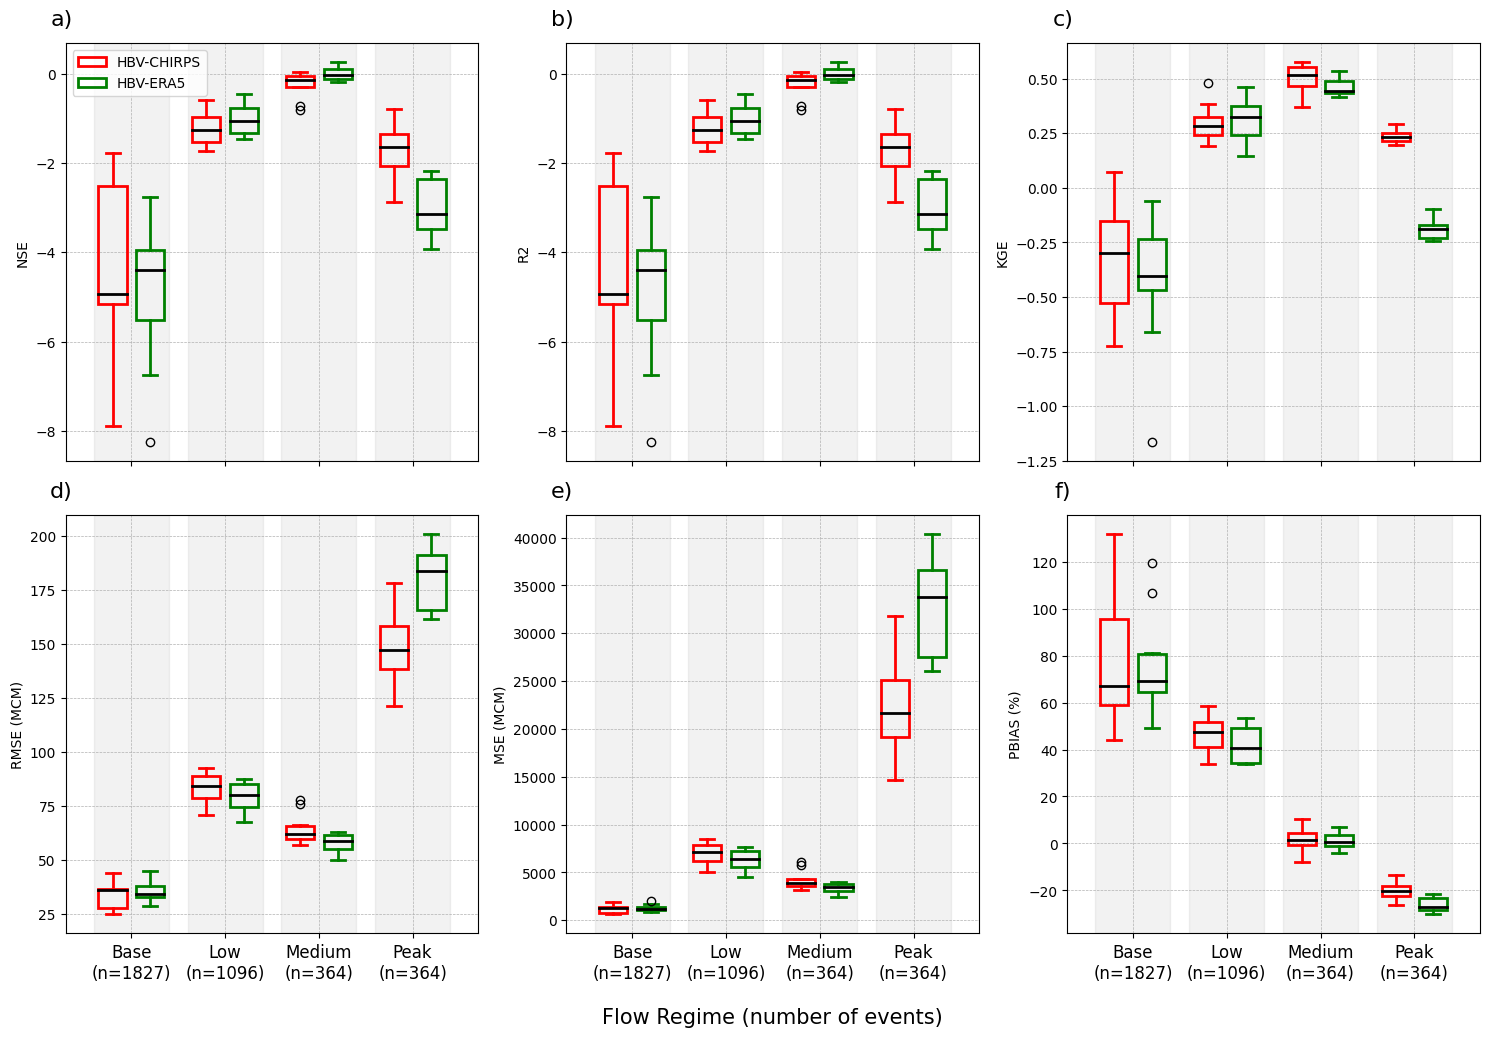

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the metrics to plot and corresponding labels
metrics_to_plot = ['nse', 'r2', 'kge', 'rmse', 'mse', 'pbias']
metric_labels = {'nse': 'NSE', 'r2': 'R2', 'kge': 'KGE',
                 'rmse': 'RMSE (MCM)', 'mse': 'MSE (MCM)', 'pbias': 'PBIAS (%)'}

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 11))
axes = axes.flatten()

# Colors for the outlines of the box plots for CHIRPS and ERA5
colors = ['red', 'green']

# Box plot settings
box_width = 0.3
spacing = 0.1
mid_points = np.arange(len(return_periods))  # Mid points for return periods
positions = [
    mid_points - (box_width + spacing) / 2, mid_points + (box_width + spacing) / 2
]

subplot_labels = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']  # Labels for subplots

# Iterate over metrics and plot
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    x_labels=[]
    # Extract data for the current metric
    data_chirps = [hbv_metrics_by_return_period['CHIRPS']['Testing'][rp][metric] for rp in return_periods]
    data_era5 = [hbv_metrics_by_return_period['ERA5']['Testing'][rp][metric] for rp in return_periods]

    # Create box plots
    bp_chirps = ax.boxplot(data_chirps, positions=positions[0], widths=box_width, patch_artist=True, notch=False,
                           boxprops=dict(facecolor='none', color=colors[0], linewidth=2),
                           whiskerprops=dict(color=colors[0], linewidth=2),
                           capprops=dict(color=colors[0], linewidth=2),
                           medianprops=dict(color='black', linewidth=2))
    bp_era5 = ax.boxplot(data_era5, positions=positions[1], widths=box_width, patch_artist=True, notch=False,
                         boxprops=dict(facecolor='none', color=colors[1], linewidth=2),
                         whiskerprops=dict(color=colors[1], linewidth=2),
                         capprops=dict(color=colors[1], linewidth=2),
                         medianprops=dict(color='black', linewidth=2))

    if i >= 3:
        for rp in range(4):  # Return period groups 0 to 3
            x_labels.append(f"{regimes[rp]}\n(n={event_counts[rp]})")

    # Set labels and title
    ax.set_ylabel(metric_labels[metric])
    ax.set_xticks(mid_points)
    ax.set_xticklabels(x_labels, fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)
    if i == 4:
        ax.set_xlabel('Flow Regime (number of events)', fontsize=15, labelpad=18)

    # Positioning subplot labels outside the subplot in the top center of each graph
    ax.text(-0.01, 1.08, subplot_labels[i], transform=ax.transAxes, fontsize=16, va='top', ha='center')

    # Highlighting return period lines
    for rp in range(4):
        ax.axvspan(rp -0.4, rp +0.4, color='grey', alpha=0.1)

    # Add legend in the first subplot
    if i == 0:
        ax.legend([bp_chirps["boxes"][0], bp_era5["boxes"][0]], ['HBV-CHIRPS', 'HBV-ERA5'], loc='upper left')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# prompt: in one talble reprot all of these metrics for hbv both chirps and era ensimble mean, for different return period , use the previously obtained values

# Calculate metrics for HBV-CHIRPS and HBV-ERA ensemble means for different return periods
metrics_df = pd.DataFrame(index=['NSE', 'KGE', 'PBIAS', 'R2'])

# HBV-CHIRPS
for i, indices in event_indices.items():
    y_obs_event = qobs.iloc[indices]
    y_pred_event_chirps = qsims.iloc[indices, :].mean(axis=1)  # Ensemble mean for CHIRPS

    if len(y_obs_event) > 0:
        metrics_df[f'HBV-CHIRPS (T={return_periods[i]})'] = [
            nse(y_obs_event, y_pred_event_chirps),
            kge(y_obs_event, y_pred_event_chirps),
            pbias(y_obs_event, y_pred_event_chirps),
            r2_score(y_obs_event, y_pred_event_chirps)
        ]

# HBV-ERA (assuming qobs_era is defined for observed discharge with ERA)
qsims_era = hbv_era_results_testing[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                    'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']] * conversion_factor
for i, indices in event_indices.items():
    y_obs_event = qobs.iloc[indices]  # Use the same observed discharge (qobs) as CHIRPS for comparison
    y_pred_event_era = qsims_era.iloc[indices, :].mean(axis=1)  # Ensemble mean for ERA

    if len(y_obs_event) > 0:
        metrics_df[f'HBV-ERA (T={return_periods[i]})'] = [
            nse(y_obs_event, y_pred_event_era),
            kge(y_obs_event, y_pred_event_era),
            pbias(y_obs_event, y_pred_event_era),
            r2_score(y_obs_event, y_pred_event_era)
        ]

# Transpose the DataFrame for better readability
metrics_df = metrics_df.transpose()
print(metrics_df)
metrics_df


                        NSE       KGE      PBIAS        R2
HBV-CHIRPS (T=1)  -3.471298 -0.192163  77.238380 -3.471298
HBV-CHIRPS (T=2)  -1.059987  0.346061  46.543721 -1.059987
HBV-CHIRPS (T=5)  -0.062278  0.530897   1.488263 -0.062278
HBV-CHIRPS (T=10) -1.632720  0.236075 -19.932018 -1.632720
HBV-ERA (T=1)     -3.863157 -0.248293  75.721769 -3.863157
HBV-ERA (T=2)     -0.837239  0.364010  42.178003 -0.837239
HBV-ERA (T=5)      0.183761  0.488562   1.114893  0.183761
HBV-ERA (T=10)    -2.928391 -0.203579 -26.090372 -2.928391


NSE       KGE      PBIAS        R2
HBV-CHIRPS (T=1)  -3.471298 -0.192163  77.238380 -3.471298
HBV-CHIRPS (T=2)  -1.059987  0.346061  46.543721 -1.059987
HBV-CHIRPS (T=5)  -0.062278  0.530897   1.488263 -0.062278
HBV-CHIRPS (T=10) -1.632720  0.236075 -19.932018 -1.632720
HBV-ERA (T=1)     -3.863157 -0.248293  75.721769 -3.863157
HBV-ERA (T=2)     -0.837239  0.364010  42.178003 -0.837239
HBV-ERA (T=5)      0.183761  0.488562   1.114893  0.183761
HBV-ERA (T=10)    -2.928391 -0.203579 -26.090372 -2.928391

In [ ]:
# prompt: in a table report the performance of the hbv model with chirps and era for testing and calibration in terms of NSE KGE PBIAS RMSE

from sklearn.metrics import mean_squared_error

# Define the conversion factor
conversion_factor = 176000 / 1000

# Function to calculate metrics
def calculate_metrics(observed, simulated):
    nse_val = nse(observed, simulated)
    kge_val = kge(observed, simulated)
    pbias_val = pbias(observed, simulated)
    rmse_val = np.sqrt(mean_squared_error(observed, simulated))
    return nse_val, kge_val, pbias_val, rmse_val

# Initialize a dictionary to store the results
results = {}

# HBV-CHIRPS Calibration
qobs_chirps_cal = hbv_chirps_results_calibration['Qobs'] * conversion_factor
qsim_chirps_cal = hbv_chirps_results_calibration[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                                'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']].mean(axis=1) * conversion_factor
results['HBV-CHIRPS (Calibration)'] = calculate_metrics(qobs_chirps_cal, qsim_chirps_cal)

# HBV-CHIRPS Testing
qobs_chirps_test = hbv_chirps_results_testing['Qobs'] * conversion_factor
qsim_chirps_test = hbv_chirps_results_testing[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                                'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']].mean(axis=1) * conversion_factor
results['HBV-CHIRPS (Testing)'] = calculate_metrics(qobs_chirps_test, qsim_chirps_test)

# HBV-ERA Calibration
qobs_era_cal = hbv_era_results_calibration['Qobs'] * conversion_factor
qsim_era_cal = hbv_era_results_calibration[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                            'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']].mean(axis=1) * conversion_factor
results['HBV-ERA (Calibration)'] = calculate_metrics(qobs_era_cal, qsim_era_cal)

# HBV-ERA Testing
qobs_era_test = hbv_era_results_testing['Qobs'] * conversion_factor
qsim_era_test = hbv_era_results_testing[['Qsim1', 'Qsim2', 'Qsim3', 'Qsim4', 'Qsim5',
                                            'Qsim6', 'Qsim7', 'Qsim8', 'Qsim9', 'Qsim10']].mean(axis=1) * conversion_factor
results['HBV-ERA (Testing)'] = calculate_metrics(qobs_era_test, qsim_era_test)

# Create a Pandas DataFrame for the results
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['NSE', 'KGE', 'PBIAS', 'RMSE'])
print(df_results)


                               NSE       KGE      PBIAS       RMSE
HBV-CHIRPS (Calibration)  0.847503  0.751365  10.457203  59.893022
HBV-CHIRPS (Testing)      0.853785  0.782364  12.635035  70.146398
HBV-ERA (Calibration)     0.874842  0.820443   9.010339  54.260605
HBV-ERA (Testing)         0.829750  0.758646   8.870153  75.692586


In [ ]:
df_results

NSE       KGE      PBIAS       RMSE
HBV-CHIRPS (Calibration)  0.847503  0.751365  10.457203  59.893022
HBV-CHIRPS (Testing)      0.853785  0.782364  12.635035  70.146398
HBV-ERA (Calibration)     0.874842  0.820443   9.010339  54.260605
HBV-ERA (Testing)         0.829750  0.758646   8.870153  75.692586

In [ ]:
# prompt: read mean hbv ens from the ouput foleer  it is on this file 'metrics_hbv_ensemble.pkl

import pickle
import os

# Assuming 'dir_output' is defined as the output directory path
metrics_file_path = os.path.join(dir_output, 'metrics_hbv_ensemble.pkl')

# Load the metrics from the pickle file
with open(metrics_file_path, 'rb') as f:
    metrics_hbv_ens = pickle.load(f)




0.39855908104792

## comparison between the models

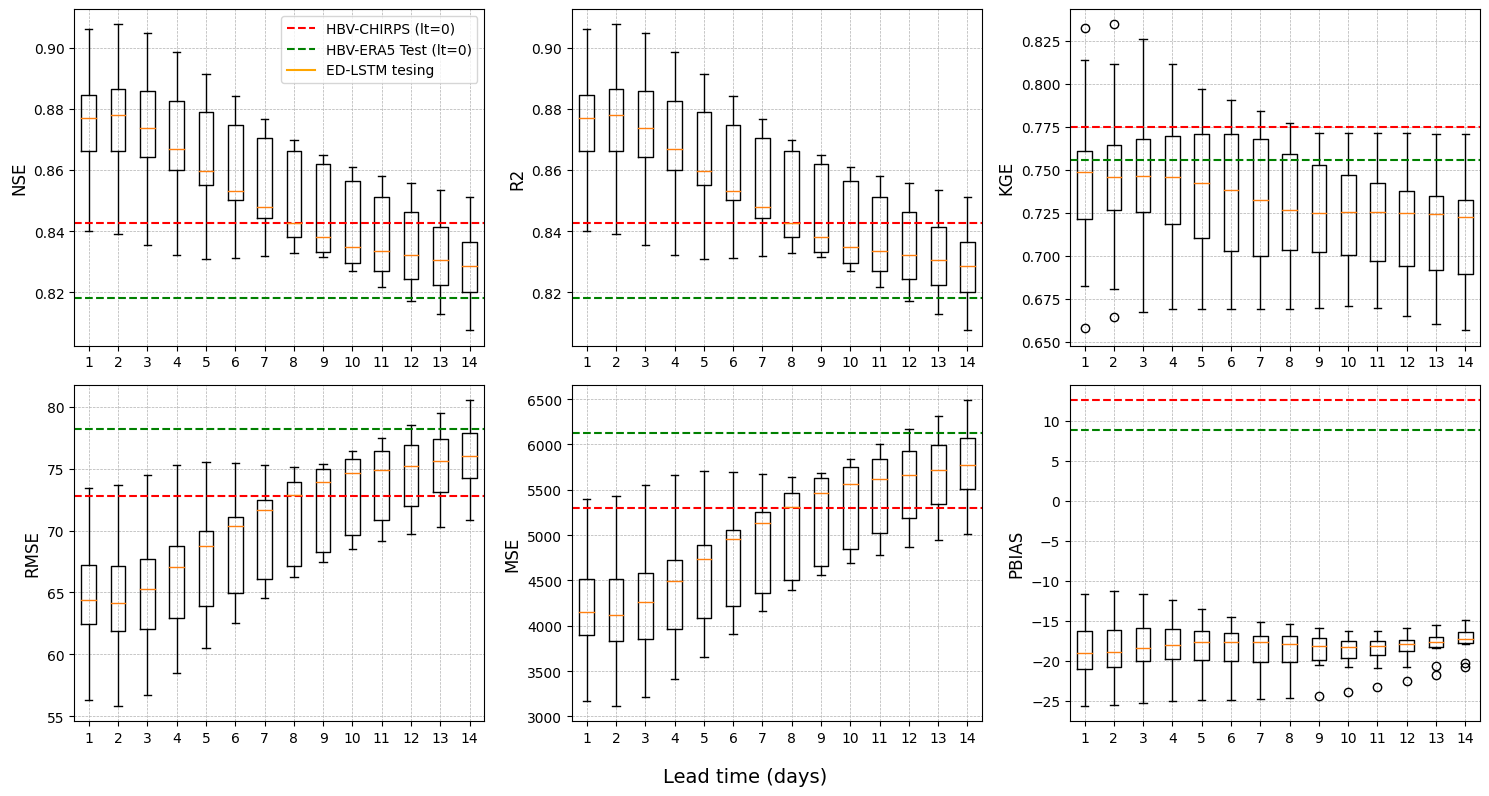

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming nse, r2, kge, rmse, msa, pbias functions are defined
# Define the number of lead times
lead_times = range(1, 15)

# Initialize dictionaries to store metric values for each lead time
nse_values = {lead_time: [] for lead_time in lead_times}
r2_values = {lead_time: [] for lead_time in lead_times}
kge_values = {lead_time: [] for lead_time in lead_times}
rmse_values = {lead_time: [] for lead_time in lead_times}
msa_values = {lead_time: [] for lead_time in lead_times}
pbias_values = {lead_time: [] for lead_time in lead_times}

# Fill the metric values for each lead time (example code, replace with actual data)
for lead_time in lead_times:
    for model_predictions in all_predictions[lead_time]:
        nse_values[lead_time].append(nse(y_test_destd[:, lead_time - 1], model_predictions))
        r2_values[lead_time].append(r2(y_test_destd[:, lead_time - 1], model_predictions))
        kge_values[lead_time].append(kge(y_test_destd[:, lead_time - 1], model_predictions))
        rmse_values[lead_time].append(rmse(y_test_destd[:, lead_time - 1], model_predictions))
        msa_values[lead_time].append(mse(y_test_destd[:, lead_time - 1], model_predictions))
        pbias_values[lead_time].append(pbias(y_test_destd[:, lead_time - 1], model_predictions))

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 8))  # 2 rows, 3 columns
axes = axes.flatten()

# List of metrics and their corresponding names
metrics = [nse_values, r2_values, kge_values, rmse_values, msa_values, pbias_values]
metric_names = ['NSE', 'R2', 'KGE', 'RMSE', 'MSE', 'PBIAS']

# Plot each metric vs. lead time with mean lines for HBV-CHIRPS and HBV-ERA5
for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i]
    boxplot_data = [metric[lead_time] for lead_time in lead_times]
    ax.boxplot(boxplot_data, labels=[str(lt) for lt in lead_times])
    ax.set_ylabel(metric_name, fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)

    # Use the pre-calculated mean values from metrics_hbv_mean
    mean_chirps_test = np.mean(metrics_hbv_ens['CHIRPS']['Testing'][metric_name.lower()])
    mean_era5_test = np.mean(metrics_hbv_ens['ERA5']['Testing'][metric_name.lower()])

    chirps_line = ax.axhline(y=mean_chirps_test, color='red', linestyle='--')
    era5_line = ax.axhline(y=mean_era5_test, color='green', linestyle='--')
    ed_lstm_line = Line2D([0], [0], color='orange', linestyle='-', label='ED-LSTM')

    # Add legend only to the first subplot
    if i == 0:
        ax.legend([chirps_line, era5_line,ed_lstm_line],
                  ['HBV-CHIRPS (lt=0)', 'HBV-ERA5 Test (lt=0)','ED-LSTM tesing'],
                  loc='upper right')

# Adjust layout and display the plot
fig.supxlabel('Lead time (days)', fontsize=14)
plt.tight_layout()
plt.show()

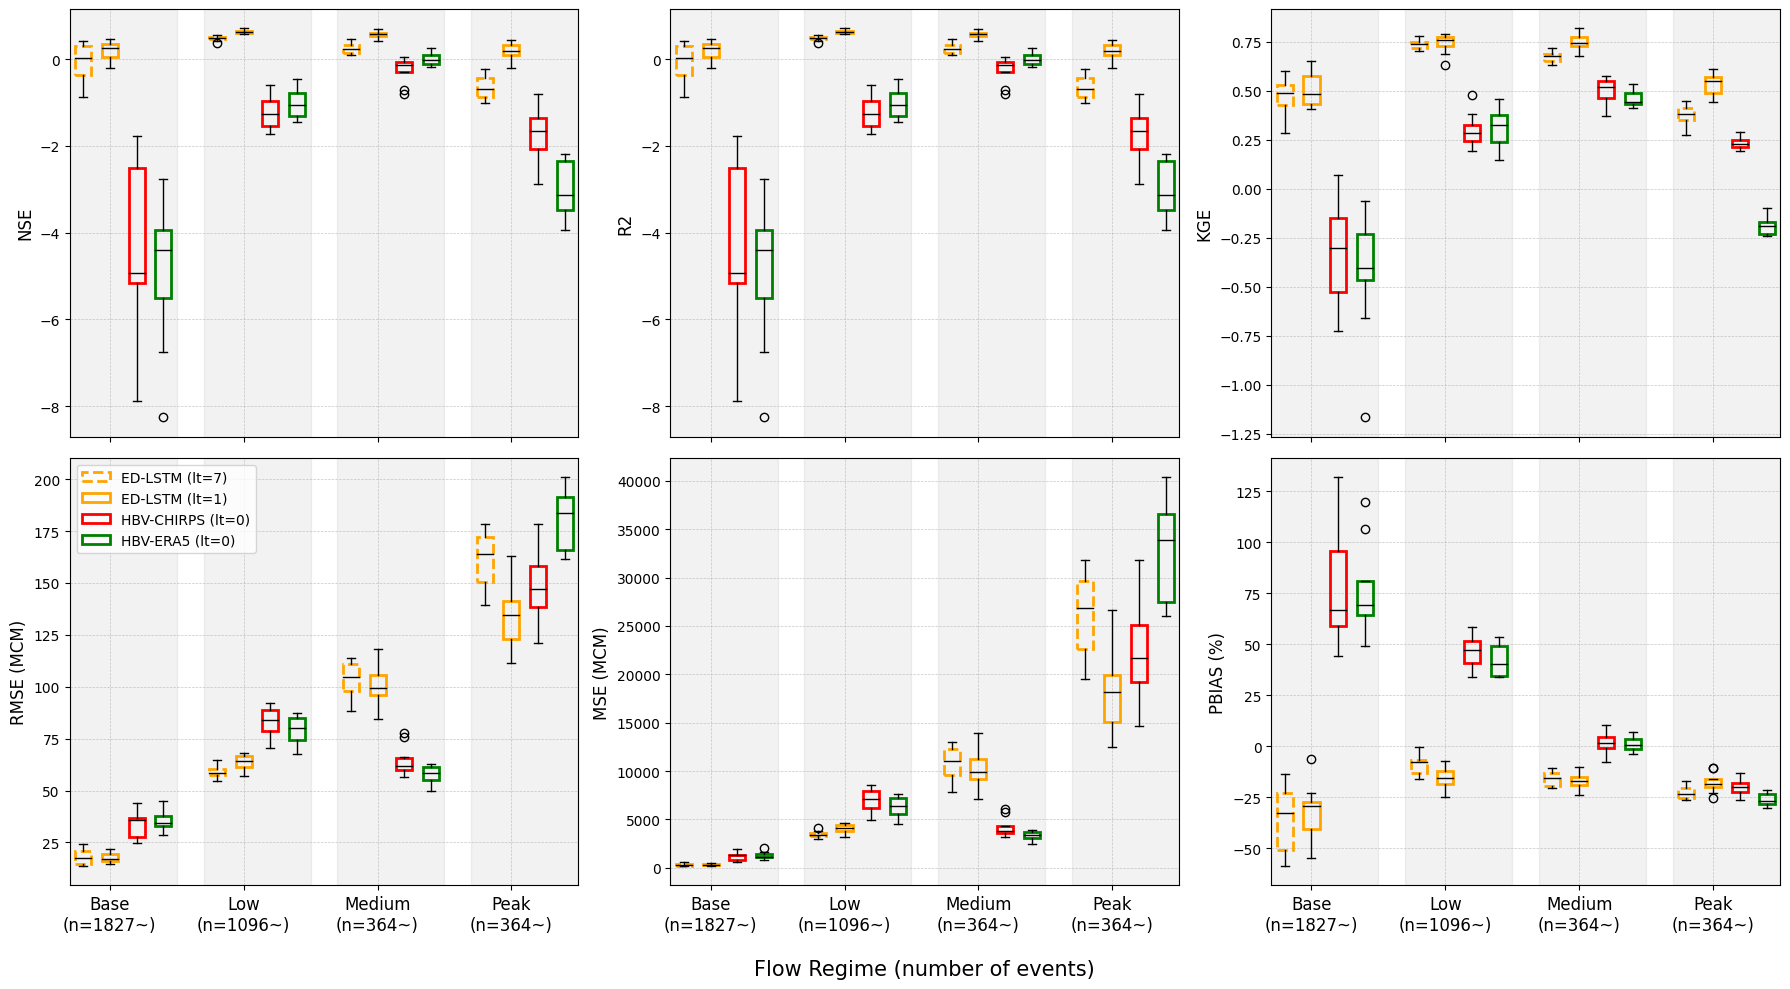

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Define metric names and their display labels
metric_names = ['nse', 'r2', 'kge', 'rmse', 'mse', 'pbias']
metric_labels = {'nse': 'NSE', 'r2': 'R2', 'kge': 'KGE',
                 'rmse': 'RMSE (MCM)', 'mse': 'MSE (MCM)', 'pbias': 'PBIAS (%)'}

# Colors for the outlines of the box plots
colors = ['orange', 'orange', 'red', 'green']
T=[1,2,5,10]

for i, metric_name in enumerate(metric_names):
    ax = axes[i]
    boxplot_data = []
    positions = []
    x_labels = []

    for rp in range(4):  # Return period groups 0 to 3
        boxplot_data.extend([
            all_metrics_by_return_period[7][rp][metric_name],
            all_metrics_by_return_period[1][rp][metric_name],
            hbv_metrics_by_return_period['CHIRPS']['Testing'][T[rp]][metric_name],
            hbv_metrics_by_return_period['ERA5']['Testing'][T[rp]][metric_name]
        ])
        positions.extend([rp * 5 - 1, rp * 5, rp * 5 + 1, rp*5+2])
        x_labels.append(f"{regimes[rp]}\n(n={event_counts[rp]}~)")

    # Creating box plots with hollow boxes
    bp = ax.boxplot(boxplot_data, positions=positions, patch_artist=True, widths=0.6, notch=False)

    # Set color and style for the outlines and make boxes hollow
    for j, (patch, medline, color) in enumerate(zip(bp['boxes'], bp['medians'], colors * 4)):
        patch.set_facecolor('none')  # Make box hollow
        if j % 4 == 0:  # First box in each group
            patch.set_edgecolor(color)
            patch.set_linestyle('--')
            patch.set_linewidth(0.01)# Dashed line for the first box
        else:
            patch.set_edgecolor(color)
        patch.set_linewidth(2)
        medline.set_color('black')

    ax.set_ylabel(metric_labels[metric_name], fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Set x-ticks and labels
    ax.set_xticks([rp * 5 for rp in range(4)])
    if i >= 3:  # Only set x-tick labels for the bottom row
        ax.set_xticklabels(x_labels, rotation=0, ha="center", fontsize=12)
    else:
        ax.set_xticklabels([])

    # Add legend in a specific subplot
    if i == 3:  # Add legend in the fourth subplot
        ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2], bp["boxes"][3]],
                  ["ED-LSTM (lt=7)","ED-LSTM (lt=1)", "HBV-CHIRPS (lt=0)", "HBV-ERA5 (lt=0)"],
                  loc='upper left', fontsize=10)

    # Highlighting return period lines
    for rp in range(4):
        ax.axvspan(rp * 5 - 1.5, rp * 5 + 2.5, color='grey', alpha=0.1)

# Set x-axis label for the bottom row
axes[4].set_xlabel('Flow Regime (number of events)', fontsize=15, labelpad=18)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## return period observations

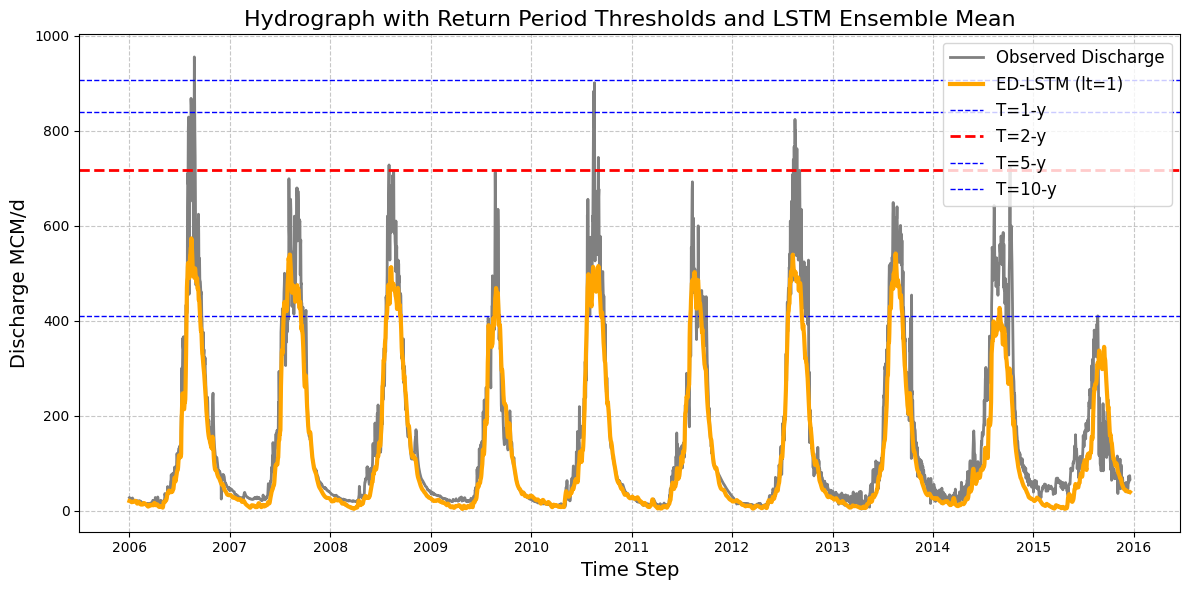

In [ ]:
# prompt: plot the observed hydrogph the performance of the ensemble mean of the LSTM for lead time1. and plot the thresholds line of T=1,2,5,10 for the return peroiod sort the annual maxima only maximum

# Calculate annual maxima for lead time 1
annual_maxima = []
for year in range(2006, 2016):
    start_index = (datetime(year, 1, 1) - datetime(2006, 1, 1)).days
    end_index = (datetime(year + 1, 1, 1) - datetime(2006, 1, 1)).days
    annual_maxima.append(np.max(y_test_destd[start_index:end_index, 0]))

# Calculate return period thresholds from annual maxima
return_periods = [1, 2, 5, 10]
thresholds_annual_maxima = {}
for rp in return_periods:
    thresholds_annual_maxima[rp] = np.percentile(annual_maxima, 100 - (100 / rp))

# Calculate ensemble mean of LSTM predictions for lead time 1
ensemble_mean_lead1 = np.mean(all_predictions[1], axis=0)  # Assuming all_predictions is defined

# Plot the hydrograph with return period thresholds and ensemble mean
plt.figure(figsize=(12, 6))

# Observed discharge
plt.plot(hbv_era_results_testing['Date'][:-13],y_test_destd[:, 0], label="Observed Discharge", color='gray', linewidth=2)

# Ensemble mean of LSTM predictions for lead time 1
plt.plot(hbv_era_results_testing['Date'][:-13],ensemble_mean_lead1, label="ED-LSTM (lt=1)", color='orange', linewidth=3, zorder=3)
#plt.plot(hbv_era_results_testing['Date'],hbv_chirps_results_testing['Qsim5'] * conversion_factor, label="HBV-CHIRPS", color='red', linewidth=1, linestyle='--')
#plt.plot(hbv_era_results_testing['Date'],hbv_era_results_testing['Qsim5'] * conversion_factor, label="HBV-ERA5", color='green', linewidth=1, linestyle='--')
# Return period thresholds (from annual maxima)
for rp, threshold in thresholds_annual_maxima.items():
    color ='blue'
    lw=1
    if rp==2:
      color ='red'
      lw=2
    plt.axhline(y=threshold, color=color, linestyle='--', label=f"T={rp}-y", linewidth=lw)

plt.xlabel("Time Step", fontsize=14)
plt.ylabel("Discharge MCM/d", fontsize=14)
plt.title("Hydrograph with Return Period Thresholds and LSTM Ensemble Mean", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


(10, 3639)